In [1]:
import pandas as pd; import numpy as np; import matplotlib as mtpl; import matplotlib.pyplot as plt;import time;import timeit
import random; from collections import Counter

font = {'family' : 'serif','weight' : 'ultralight','size'   : 14};mtpl.rc('font', **font)

In [2]:
def Smooth121(x):
    signal = x
    length = len(signal)
    output = np.zeros(length-2)
    coef= np.array([1,2,1])
    for i in range(length - 2):
        output[i]= np.sum(signal[i:i+3] * coef / 4)
    return output

def Haar(t,x,plot=False,smooth=False):
    x=np.array(x);t=np.array(t)    
    #Cálculo deltas
    deltas_t=[];epsilons=[]
    for i in range(1,int(len(t)/2)+1):  #steps: i from 1 to n/2 
        deltas_t.append(t[i:]-t[:-i]) #0= Delta_t1, 1= Delta_t2, ..., [n/2]-1 = Delta_tn/2
    for i in range(1,len(deltas_t)+1): #for all my deltas_t (all steps-differences, de 1 en 1, de 2 en 2, etc)
        epsilons.append(deltas_t[i-1][:-i]/(deltas_t[i-1][:-i]+deltas_t[i-1][i:]))
    x=x[:-1];t=t[:-1]
    print('t samples:',len(t))
    print('deltas_t steps: from 1 to',len(deltas_t))
    print('epsilons steps:',len(epsilons))

    #Cálculo fluctuaciones
    Hs=[]; delta_t=[]; ep_min=0.25; ep_max=1-ep_min; calib=2; counter=0
    for H in range(2,len(x)-1,2):
        for start in range(len(x)-H-1):
            int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])
            int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
            counter+=1
            if ep_min<epsilons[int(H/2)-1][start] and epsilons[int(H/2)-1][start]<ep_max:
                #Hs.append(calib*abs(int2-int1)) #S_1
                Hs.append((calib*(int2-int1))**2) #S_2 (falta despues sacar raíz)
                delta_t.append(deltas_t[int(H/2)-1][start]+deltas_t[int(H/2)-1][start+int(H/2)]) #No logaritmicos           

    print(counter-len(Hs),' fluctuaciones eliminadas (',(counter-len(Hs))/counter*100,'%)')
    
    #Paso a dataframes
    data_df=pd.DataFrame(data={'delta t':delta_t , 'Hs': Hs}); data_sorted=data_df.sort_values('delta t',axis=0).reset_index(drop=True)

    #plt.subplots(figsize=(15, 7))
    #plt.title(' Scatter Haar fluctuation',fontsize=20);plt.xlabel('Log\u2081\u2080\u0394 t (Ky)',fontsize=18);plt.ylabel('Log\u2081\u2080 S\u2082(\u0394 t)^1/2',fontsize=18)
    #plt.plot(data_df['delta t'],np.sqrt(data_df['Hs']),'.');plt.show()

    max_t=max(np.log10(data_sorted['delta t'])); min_t=min(np.log10(data_sorted['delta t']))
    n_bins=int(((max_t)-(min_t))*20); rango_int=(max_t-min_t)/n_bins; time=np.array([]); ave_values=np.array([]); upper=np.array([]); lower=np.array([]);
    for i in range(n_bins):
        interval=data_sorted[(i*rango_int+min_t<=np.log10(data_sorted['delta t']))&(np.log10(data_sorted['delta t'])<min_t+(i+1)*rango_int)]
        time=np.append(time,((i*rango_int+min_t)+((i+1)*rango_int+min_t))/2)
        ave_values=np.append(ave_values,np.sqrt(interval.mean()[1]))        ## Tomo el sqrt del <[2*(x1-x2)]^2> ...
        upper=np.append(upper,np.sqrt(interval.mean()[1]+interval.std()[1]/np.sqrt(len(interval))))
        lower=np.append(lower,np.sqrt(interval.mean()[1]-interval.std()[1]/np.sqrt(len(interval))))
        
    if smooth==False:
        smooth_val=ave_values
    if smooth==True:
        smooth_val=Smooth121(ave_values)
        upper=Smooth121(upper)
        lower=Smooth121(lower)
        time=time[1:-1]
    val_mask = np.isfinite(smooth_val)
    
    time=time[val_mask] #??
    smooth_val=smooth_val[val_mask] #??
    upper=upper[val_mask]
    lower=lower[val_mask]
    if plot=='plot':
        plt.subplots(figsize=(15, 7))
        plt.title(' Sin test Haar fluctuation',fontsize=20);plt.xlabel('Log\u2081\u2080\u0394 t (Ky)',fontsize=18);plt.ylabel('Log\u2081\u2080 S\u2082(\u0394 t)^1/2',fontsize=18)
        for i in range(n_bins):
            plt.axvline(x = i*rango_int+min_t,linestyle='-.',linewidth=0.5)
        plt.plot(time,np.log10(smooth_val),'.-',color='black',linewidth=2,label='Log binning')
        plt.legend()
        plt.show()

    return data_sorted['delta t'],data_sorted['Hs'],time,smooth_val,upper,lower

In [91]:
## TENGO YA CREADAS LAS FUNCIONES, AHORA TENGO QUE JUGAR CON LAS RESOLUCIONES Y EXTENSIONES
#LUEGO, UNIR TODO Y CORRER HAAR

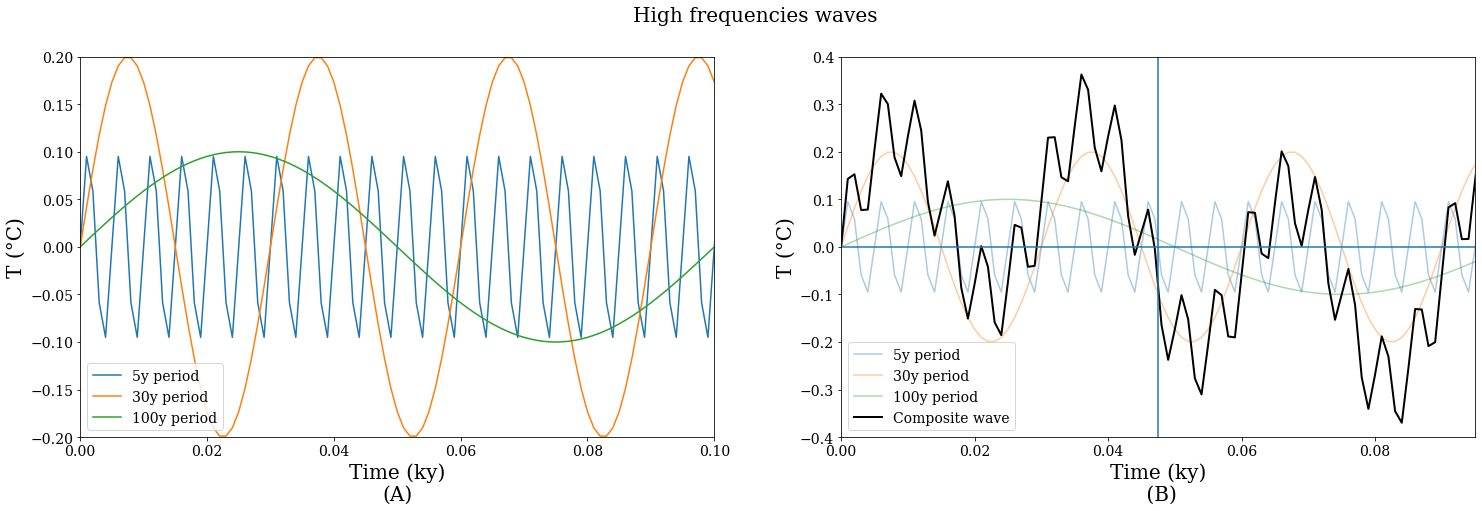

In [3]:
#High frequencies
kyears1=200;
t11 = np.arange(0, kyears1, 0.001); #5000 points
t21 = np.arange(0, kyears1, 0.001); #5000 points
t31 = np.arange(0, kyears1, 0.001); #5000 points

x11 = 0.1*np.sin(2000*np.pi*t11/5); #Periodo 5y
x21 = 0.2*np.sin(2000*np.pi*t21/30); #Periodo 30y
x31 = 0.1*np.sin(2000*np.pi*t31/100); #Periodo 100y


fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(25, 7))
fig.suptitle('High frequencies waves',fontsize=20)
ax1.plot(t11,x11,'-',label='5y period');
ax1.plot(t21,x21,'-',label='30y period');
ax1.plot(t31,x31,'-',label='100y period');
ax1.set_xlabel('Time (ky)\n(A)', fontsize = 20.0)
ax1.set_ylabel('T (°C)', fontsize = 20)
ax1.set(xlim=[0,0.1],ylim=[-0.2,0.2])
ax1.legend(loc=3)

ax2.plot(t11,x11,'-',label='5y period',color='#2D7FB8',alpha=0.4);
ax2.plot(t21,x21,'-',label='30y period',color='#FF7F17',alpha=0.4);
ax2.plot(t31,x31,'-',label='100y period',color='#2CA02C',alpha=0.4);
ax2.plot(t11,x11+x21+x31,'-',label='Composite wave',color='black',linewidth=2);
ax2.set_xlabel('Time (ky)\n (B)', fontsize = 20.0)
ax2.set_ylabel('T (°C)', fontsize = 20)
ax2.set(xlim=[0,0.095],ylim=[-0.4,0.4])
ax2.axvline(x=0.095/2)
ax2.axhline(y=0)
ax2.legend(loc=3)

#plt.savefig('13-SinteticA2-0-HF.pdf',bbox_inches='tight')

plt.show()


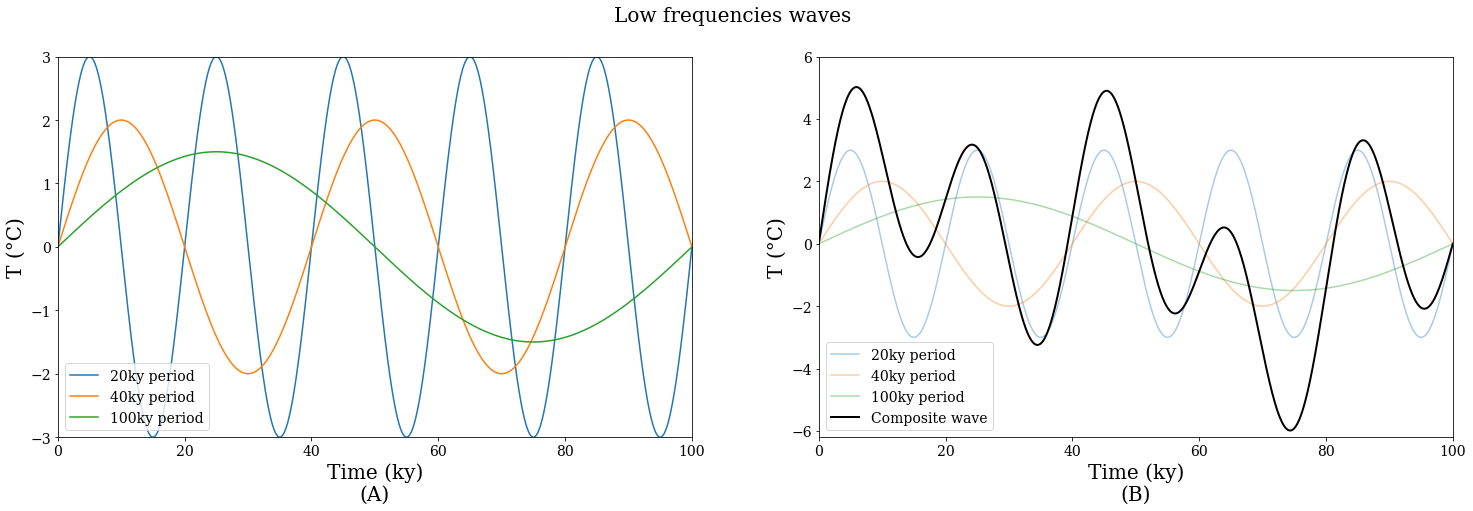

In [4]:
#Low frequencies
t41 = np.arange(0, kyears1, 0.001); #5000 points
t51 = np.arange(0, kyears1, 0.001);
t61 = np.arange(0, kyears1, 0.001);

x41 = 3*np.sin(2*np.pi*t41/20); #Periodo 20ky
x51 = 2*np.sin(2*np.pi*t51/40); #Periodo 40ky
x61 = 1.5*np.sin(2*np.pi*t61/100); #Periodo 100ky

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(25, 7))
fig.suptitle('Low frequencies waves',fontsize=20)
ax1.plot(t41,x41,'-',label='20ky period');
ax1.plot(t51,x51,'-',label='40ky period');
ax1.plot(t61,x61,'-',label='100ky period');
ax1.set_xlabel('Time (ky)\n(A)', fontsize = 20.0)
ax1.set_ylabel('T (°C)', fontsize = 20)
ax1.set(xlim=[0,100],ylim=[-3,3])
ax1.legend(loc=3)

ax2.plot(t41,x41,'-',label='20ky period',color='#2D7FB8',alpha=0.4);
ax2.plot(t51,x51,'-',label='40ky period',color='#FF7F17',alpha=0.4);
ax2.plot(t61,x61,'-',label='100ky period',color='#2CA02C',alpha=0.4);
ax2.plot(t41,x41+x51+x61,'-',label='Composite wave',color='black',linewidth=2);
ax2.set_xlabel('Time (ky)\n(B)', fontsize = 20.0)
ax2.set_ylabel('T (°C)', fontsize = 20)
ax2.set(xlim=[0,100],ylim=[-6.2,6])
ax2.legend(loc=3)

#plt.savefig('13-SinteticA2-1-LF.pdf',bbox_inches='tight')

plt.show()

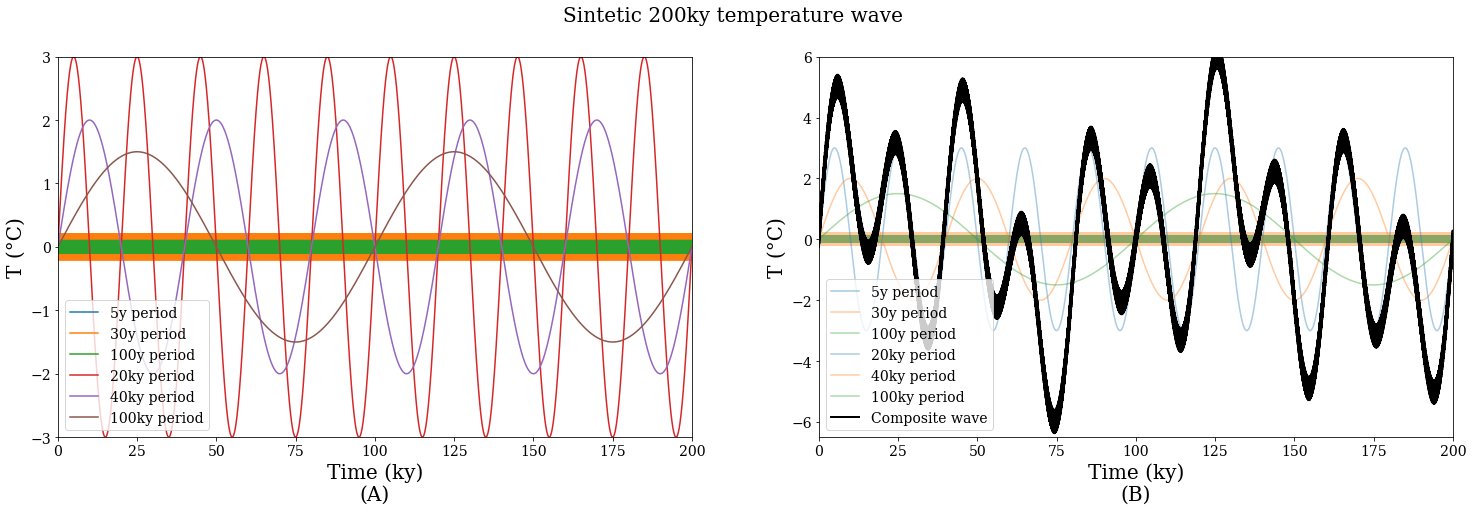

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(25, 7))
fig.suptitle('Sintetic 200ky temperature wave',fontsize=20)
ax1.plot(t11,x11,'-',label='5y period');
ax1.plot(t21,x21,'-',label='30y period');
ax1.plot(t31,x31,'-',label='100y period');

ax1.plot(t41,x41,'-',label='20ky period');
ax1.plot(t51,x51,'-',label='40ky period');
ax1.plot(t61,x61,'-',label='100ky period');
ax1.set_xlabel('Time (ky)\n(A)', fontsize = 20.0)
ax1.set_ylabel('T (°C)', fontsize = 20)
ax1.set(xlim=[0,200],ylim=[-3,3])
ax1.legend(loc=3)

ax2.plot(t11,x11,'-',label='5y period',alpha=0.4);
ax2.plot(t21,x21,'-',label='30y period',alpha=0.4);
ax2.plot(t31,x31,'-',label='100y period',alpha=0.4);

ax2.plot(t41,x41,'-',label='20ky period',color='#2D7FB8',alpha=0.4);
ax2.plot(t51,x51,'-',label='40ky period',color='#FF7F17',alpha=0.4);
ax2.plot(t61,x61,'-',label='100ky period',color='#2CA02C',alpha=0.4);
ax2.plot(t41,x11+x21+x31+x41+x51+x61,'-',label='Composite wave',color='black',linewidth=2);
ax2.set_xlabel('Time (ky)\n(B)', fontsize = 20.0)
ax2.set_ylabel('T (°C)', fontsize = 20)
ax2.set(xlim=[0,200],ylim=[-6.5,6])
ax2.legend(loc=3)

#plt.savefig('13-SinteticA2-2-Composite.pdf',bbox_inches='tight')

plt.show()

In [3]:
def wave(res1,res2,res3,res4,res5,res6,name):    
    kyears1=2; 
    kyears2=10;
    kyears3=20;
    kyears4=50;
    kyears5=100;
    kyears6=200;    
    
    t11 = np.arange(0, kyears1+res1, res1); t21 = np.arange(0, kyears1+res1, res1); t31 = np.arange(0, kyears1+res1, res1);
    x11 = 0.1*np.sin(2000*np.pi*t11/5); x21 = 0.2*np.sin(2000*np.pi*t21/30); x31 = 0.1*np.sin(2000*np.pi*t31/100);
    t41 = np.arange(0, kyears1+res1, res1); t51 = np.arange(0, kyears1+res1, res1); t61 = np.arange(0, kyears1+res1, res1);
    x41 = 3*np.sin(2*np.pi*t41/20); x51 = 2*np.sin(2*np.pi*t51/40); x61 = 1.5*np.sin(2*np.pi*t61/100); 
    T1=x11+x21+x31+x41+x51+x61

    t12 = np.arange(kyears1, kyears2+res2, res2); t22 = np.arange(kyears1, kyears2+res2, res2); t32 = np.arange(kyears1, kyears2+res2, res2);
    x12 = 0.1*np.sin(2000*np.pi*t12/5); x22 = 0.2*np.sin(2000*np.pi*t22/30); x32 = 0.1*np.sin(2000*np.pi*t32/100);
    t42 = np.arange(kyears1, kyears2+res2, res2); t52 = np.arange(kyears1, kyears2+res2, res2); t62 = np.arange(kyears1, kyears2+res2, res2);
    x42 = 3*np.sin(2*np.pi*t42/20); x52 = 2*np.sin(2*np.pi*t52/40); x62 = 1.5*np.sin(2*np.pi*t62/100); 
    T2=x12+x22+x32+x42+x52+x62

    t13 = np.arange(kyears2, kyears3+res3, res3); t23 = np.arange(kyears2, kyears3+res3, res3); t33 = np.arange(kyears2, kyears3+res3, res3);
    x13 = 0.1*np.sin(2000*np.pi*t13/5); x23 = 0.2*np.sin(2000*np.pi*t23/30); x33 = 0.1*np.sin(2000*np.pi*t33/100); 
    t43 = np.arange(kyears2, kyears3+res3, res3); t53 = np.arange(kyears2, kyears3+res3, res3); t63 = np.arange(kyears2, kyears3+res3, res3);
    x43 = 3*np.sin(2*np.pi*t43/20); x53 = 2*np.sin(2*np.pi*t53/40); x63 = 1.5*np.sin(2*np.pi*t63/100); 
    T3=x13+x23+x33+x43+x53+x63

    t14 = np.arange(kyears3, kyears4+res4, res4); t24 = np.arange(kyears3, kyears4+res4, res4); t34 = np.arange(kyears3, kyears4+res4, res4);
    x14 = 0.1*np.sin(2000*np.pi*t14/5); x24 = 0.2*np.sin(2000*np.pi*t24/30); x34 = 0.1*np.sin(2000*np.pi*t34/100);
    t44 = np.arange(kyears3, kyears4+res4, res4); t54 = np.arange(kyears3, kyears4+res4, res4); t64 = np.arange(kyears3, kyears4+res4, res4);
    x44 = 3*np.sin(2*np.pi*t44/20); x54 = 2*np.sin(2*np.pi*t54/40); x64 = 1.5*np.sin(2*np.pi*t64/100); 
    T4=x14+x24+x34+x44+x54+x64

    t15 = np.arange(kyears4, kyears5+res5, res5); t25 = np.arange(kyears4, kyears5+res5, res5); t35 = np.arange(kyears4, kyears5+res5, res5);
    x15 = 0.1*np.sin(2000*np.pi*t15/5); x25 = 0.2*np.sin(2000*np.pi*t25/30); x35 = 0.1*np.sin(2000*np.pi*t35/100); 
    t45 = np.arange(kyears4, kyears5+res5, res5); t55 = np.arange(kyears4, kyears5+res5, res5); t65 = np.arange(kyears4, kyears5+res5, res5);
    x45 = 3*np.sin(2*np.pi*t45/20); x55 = 2*np.sin(2*np.pi*t55/40); x65 = 1.5*np.sin(2*np.pi*t65/100); 
    T5=x15+x25+x35+x45+x55+x65

    t16 = np.arange(kyears5, kyears6+res6, res6); t26 = np.arange(kyears5, kyears6+res6, res6); t36 = np.arange(kyears5, kyears6+res6, res6);
    x16 = 0.1*np.sin(2000*np.pi*t16/5); x26 = 0.2*np.sin(2000*np.pi*t26/30); x36 = 0.1*np.sin(2000*np.pi*t36/100);
    t46 = np.arange(kyears5, kyears6+res6, res6); t56 = np.arange(kyears5, kyears6+res6, res6); t66 = np.arange(kyears5, kyears6+res6, res6);
    x46 = 3*np.sin(2*np.pi*t46/20); x56 = 2*np.sin(2*np.pi*t56/40); x66 = 1.5*np.sin(2*np.pi*t66/100); 
    T6=x16+x26+x36+x46+x56+x66

    T=np.concatenate((T1, T2, T3, T4, T5, T6)); t=np.concatenate((t11, t12, t13, t14, t15, t16))
    
    colors = ['#2D7FB8','#FF7F17','#2CA02C','#D62728','#9468BD','#A67D75']
    col_dic = {'0.005':'#2D7FB8','0.01':'#FF7F17','0.015':'#2CA02C','0.035':'#2CA02C','0.05':'#D62728','0.1':'#9468BD','0.2':'#A67D75'}

    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(25, 7))
    #fig.suptitle('Sintetic 200ky temperature wave - Resolution '+name,fontsize=20)
    ax1.plot(t,'--')
    ax1.set_xlabel('Samples\n(A)', fontsize = 20.0)
    ax1.set_ylabel('Time (Ky)', fontsize = 20)

    ax2.plot(t11,T1,'-',color=col_dic[str(res1)],label=str(int(res1*1000))+'y resolution')
    ax2.plot(t12,T2,'-',color=col_dic[str(res2)],label=str(int(res2*1000))+'y resolution')
    ax2.plot(t13,T3,'-',color=col_dic[str(res3)],label=str(int(res3*1000))+'y resolution')
    ax2.plot(t14,T4,'-',color=col_dic[str(res4)],label=str(int(res4*1000))+'y resolution')
    ax2.plot(t15,T5,'-',color=col_dic[str(res5)],label=str(int(res5*1000))+'y resolution')
    ax2.plot(t16,T6,'-',color=col_dic[str(res6)],label=str(int(res6*1000))+'y resolution')
    ax2.set_xlabel('Time (ky)\n(B)', fontsize = 20.0)
    ax2.set_ylabel('T (°C)', fontsize = 20)
    ax2.legend(loc=1)

    #plt.savefig('13-SinteticA2-3-Res'+name+'.pdf',bbox_inches='tight')
    plt.show()  
    
    return t,T

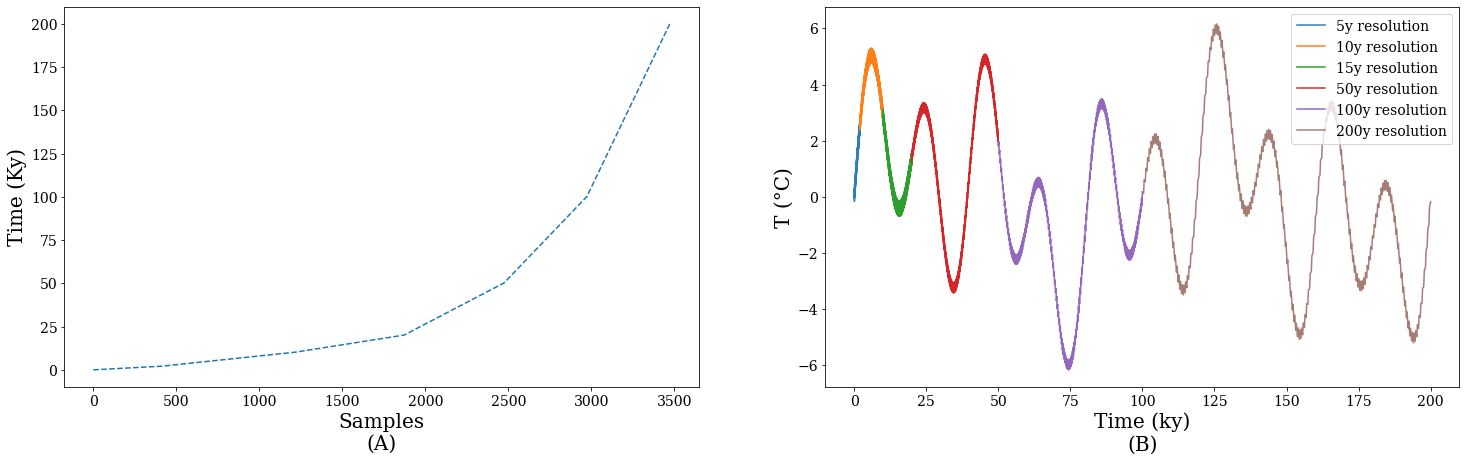

In [5]:
#[t1,T1]=wave(0.2,0.2,0.2,0.2,0.2,0.2,'Test 1')
#[t2,T2]=wave(0.1,0.1,0.1,0.1,0.1,0.2,'Test 2')
#[t3,T3]=wave(0.05,0.05,0.05,0.05,0.1,0.2,'Test 3')
#[t4,T4]=wave(0.015,0.015,0.015,0.05,0.1,0.2,'Test 4')
#[t5,T5]=wave(0.01,0.01,0.015,0.05,0.1,0.2,'Test 5')
[t6,T6]=wave(0.005,0.01,0.015,0.05,0.1,0.2,'Test 6')

In [7]:
#[uni_delta_t1,uni_hs1,uni_time1,uni_amp1,uni_app1,uni_low1]=Haar(t1,T1)
#[uni_delta_t2,uni_hs2,uni_time2,uni_amp2,uni_app2,uni_low2]=Haar(t2,T2)
#[uni_delta_t3,uni_hs3,uni_time3,uni_amp3,uni_app3,uni_low3]=Haar(t3,T3)
#[uni_delta_t4,uni_hs4,uni_time4,uni_amp4,uni_app4,uni_low4]=Haar(t4,T4)
#[uni_delta_t5,uni_hs5,uni_time5,uni_amp5,uni_app5,uni_low5]=Haar(t5,T5)
[uni_delta_t6,uni_hs6,uni_time6,uni_amp6,uni_app6,uni_low6]=Haar(t6,T6,True)

t samples: 3472
deltas_t steps: from 1 to 1736
epsilons steps: 1736


<ipython-input-4-b432793d649f>:28: RuntimeWarning: invalid value encountered in true_divide
  int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
<ipython-input-4-b432793d649f>:27: RuntimeWarning: invalid value encountered in true_divide
  int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])


861930  fluctuaciones eliminadas ( 28.633407801742393 %)


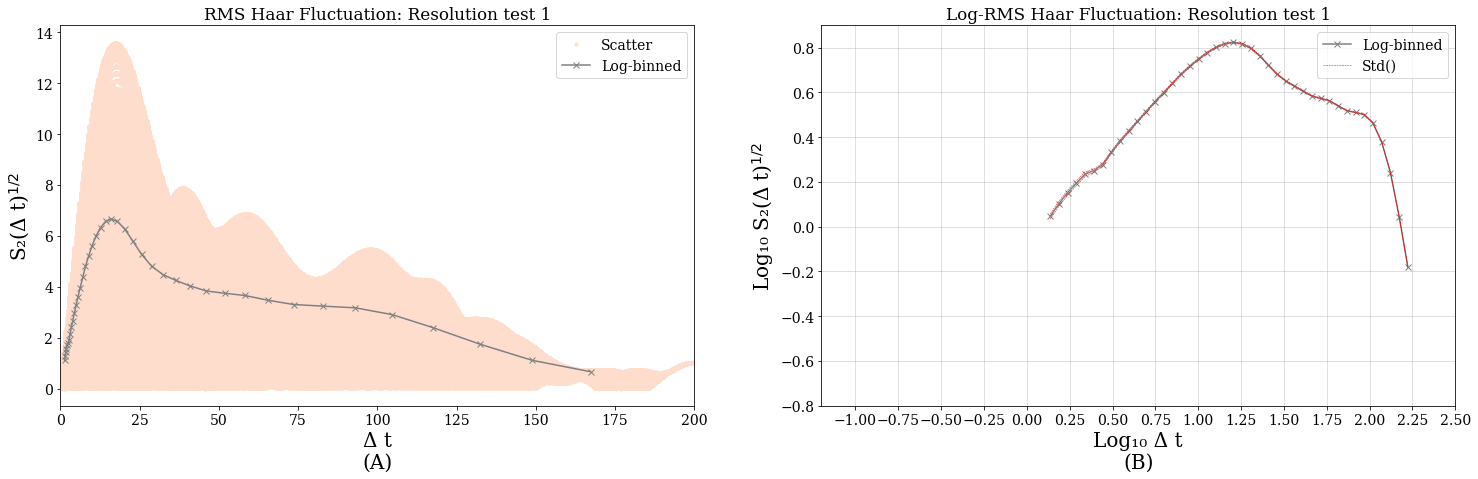

In [131]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(25, 7))
#fig.suptitle('Sintetic 200ky temperature wave - Haar Test 1',fontsize=20)

ax1.plot( uni_delta_t1,   np.sqrt(uni_hs1),'.',color='#FFDDCD',label='Scatter')
ax1.plot(10**uni_time1,          uni_amp1,'x-',color='grey',label='Log-binned')
ax1.set(title='RMS Haar Fluctuation: Resolution test 1')
ax1.set_xlabel('\u0394 t\n(A)', fontsize = 20.0)
ax1.set_ylabel('S\u2082(\u0394 t)'+r'$^{1/2}$', fontsize = 20)
ax1.set(xlim=[0,200])
ax1.legend(loc=1)

ax2.plot(uni_time1,np.log10(uni_amp1),'x-',color='grey',label='Log-binned')
ax2.plot(uni_time1,np.log10(uni_app1),'--',color='red',label='Std()',linewidth=0.5)
ax2.plot(uni_time1,np.log10(uni_low1),'--',color='red',linewidth=0.5)
ax2.set(title='Log-RMS Haar Fluctuation: Resolution test 1')
ax2.set_xlabel('Log\u2081\u2080 \u0394 t\n(B)', fontsize = 20.0)
ax2.set_ylabel('Log\u2081\u2080 S\u2082(\u0394 t)'+r'$^{1/2}$', fontsize = 20)
ax2.set_xticks([-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5])

ax2.set(xlim=[-1.2,2.5])
ax2.set(ylim=[-0.8,0.9])
ax2.legend(loc=1)
ax2.grid(alpha=0.5)

#plt.savefig('13-SinteticA2-4-Haar1.pdf',bbox_inches='tight')
plt.show()


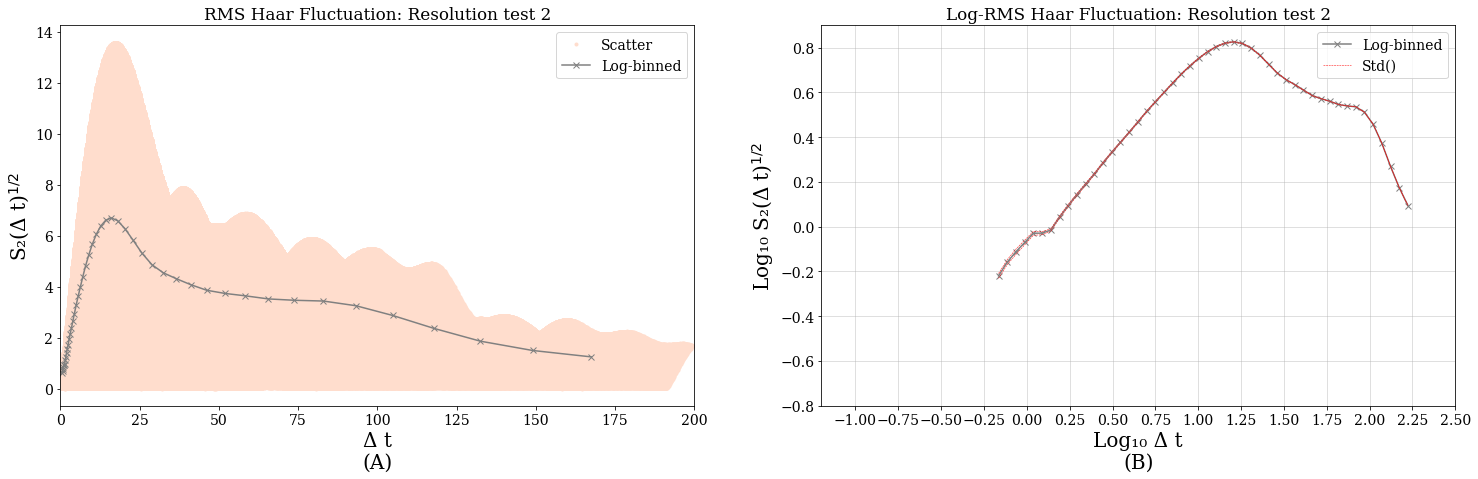

In [130]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(25, 7))
#fig.suptitle('Sintetic 200ky temperature wave - Haar Test 1',fontsize=20)

ax1.plot( uni_delta_t2,   np.sqrt(uni_hs2),'.',color='#FFDDCD',label='Scatter')
ax1.plot(10**uni_time2,          uni_amp2,'x-',color='grey',label='Log-binned')
ax1.set(title='RMS Haar Fluctuation: Resolution test 2')
ax1.set_xlabel('\u0394 t\n(A)', fontsize = 20.0)
ax1.set_ylabel('S\u2082(\u0394 t)'+r'$^{1/2}$', fontsize = 20)
ax1.set(xlim=[0,200])
ax1.legend(loc=1)

ax2.plot(uni_time2,np.log10(uni_amp2),'x-',color='grey',label='Log-binned')
ax2.plot(uni_time2,np.log10(uni_app2),'--',color='red',label='Std()',linewidth=0.5)
ax2.plot(uni_time2,np.log10(uni_low2),'--',color='red',linewidth=0.5)
ax2.set(title='Log-RMS Haar Fluctuation: Resolution test 2')
ax2.set_xlabel('Log\u2081\u2080 \u0394 t\n(B)', fontsize = 20.0)
ax2.set_ylabel('Log\u2081\u2080 S\u2082(\u0394 t)'+r'$^{1/2}$', fontsize = 20)
ax2.set_xticks([-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5])

ax2.set(xlim=[-1.2,2.5])
ax2.set(ylim=[-0.8,0.9])
ax2.legend(loc=1)
ax2.grid(alpha=0.5)

#plt.savefig('13-SinteticA2-4-Haar2.pdf',bbox_inches='tight')
plt.show()

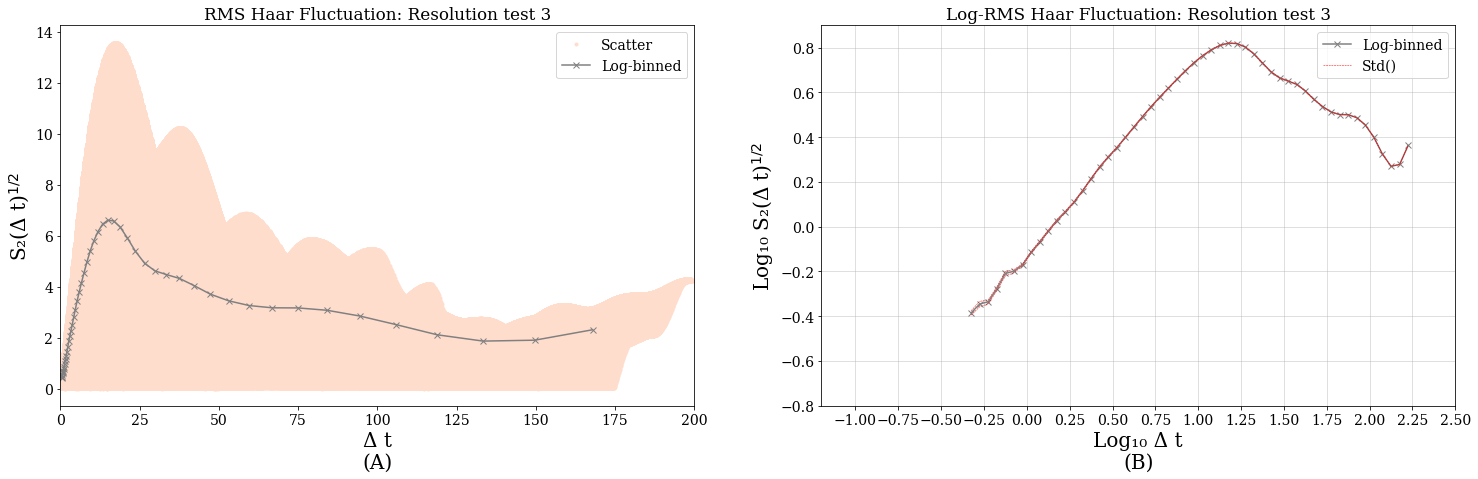

In [129]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(25, 7))

ax1.plot( uni_delta_t3,   np.sqrt(uni_hs3),'.',color='#FFDDCD',label='Scatter')
ax1.plot(10**uni_time3,          uni_amp3,'x-',color='grey',label='Log-binned')
ax1.set(title='RMS Haar Fluctuation: Resolution test 3')
ax1.set_xlabel('\u0394 t\n(A)', fontsize = 20.0)
ax1.set_ylabel('S\u2082(\u0394 t)'+r'$^{1/2}$', fontsize = 20)
ax1.set(xlim=[0,200])
ax1.legend(loc=1)

ax2.plot(uni_time3,np.log10(uni_amp3),'x-',color='grey',label='Log-binned')
ax2.plot(uni_time3,np.log10(uni_app3),'--',color='red',label='Std()',linewidth=0.5)
ax2.plot(uni_time3,np.log10(uni_low3),'--',color='red',linewidth=0.5)
ax2.set(title='Log-RMS Haar Fluctuation: Resolution test 3')
ax2.set_xlabel('Log\u2081\u2080 \u0394 t\n(B)', fontsize = 20.0)
ax2.set_ylabel('Log\u2081\u2080 S\u2082(\u0394 t)'+r'$^{1/2}$', fontsize = 20)
ax2.set_xticks([-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5])

ax2.set(xlim=[-1.2,2.5])
ax2.set(ylim=[-0.8,0.9])
ax2.legend(loc=1)
ax2.grid(alpha=0.5)

#plt.savefig('13-SinteticA2-4-Haar3.pdf',bbox_inches='tight')
plt.show()

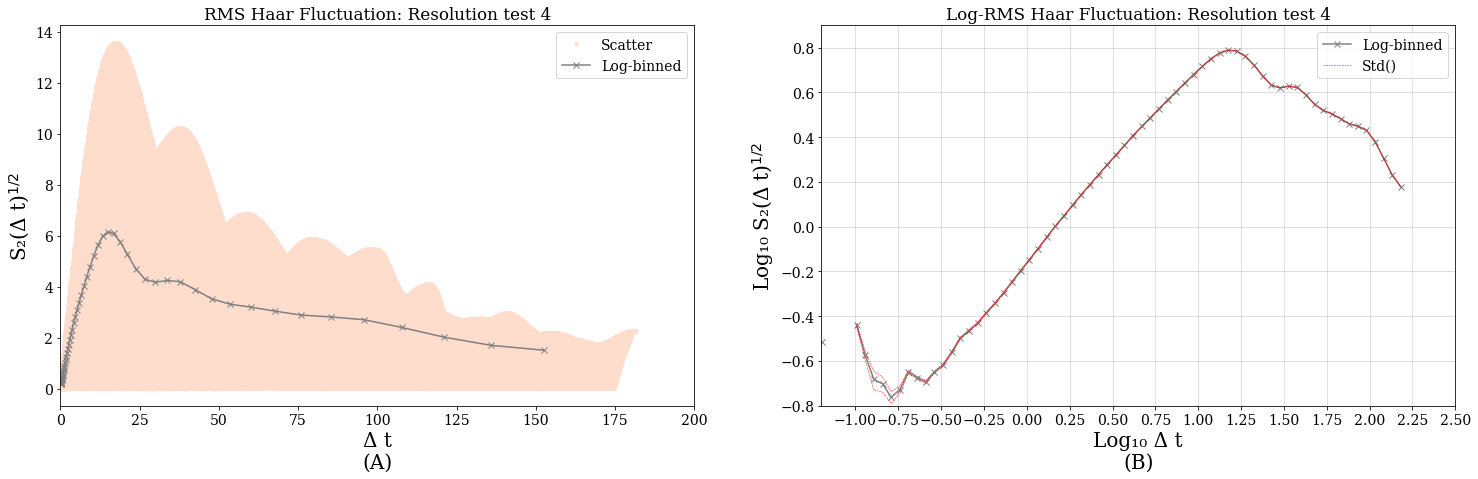

In [122]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(25, 7))

ax1.plot( uni_delta_t4,   np.sqrt(uni_hs4),'.',color='#FFDDCD',label='Scatter')
ax1.plot(10**uni_time4,          uni_amp4,'x-',color='grey',label='Log-binned')
ax1.set(title='RMS Haar Fluctuation: Resolution test 4')
ax1.set_xlabel('\u0394 t\n(A)', fontsize = 20.0)
ax1.set_ylabel('S\u2082(\u0394 t)'+r'$^{1/2}$', fontsize = 20)
ax1.set(xlim=[0,200])
ax1.legend(loc=1)

ax2.plot(uni_time4,np.log10(uni_amp4),'x-',color='grey',label='Log-binned')
ax2.plot(uni_time4,np.log10(uni_app4),'--',color='red',label='Std()',linewidth=0.5)
ax2.plot(uni_time4,np.log10(uni_low4),'--',color='red',linewidth=0.5)
ax2.set(title='Log-RMS Haar Fluctuation: Resolution test 4')
ax2.set_xlabel('Log\u2081\u2080 \u0394 t\n(B)', fontsize = 20.0)
ax2.set_ylabel('Log\u2081\u2080 S\u2082(\u0394 t)'+r'$^{1/2}$', fontsize = 20)
ax2.set_xticks([-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5])

ax2.set(xlim=[-1.2,2.5])
ax2.set(ylim=[-0.8,0.9])
ax2.legend(loc=1)
ax2.grid(alpha=0.5)

#plt.savefig('13-SinteticA2-4-Haar4.pdf',bbox_inches='tight')
plt.show()

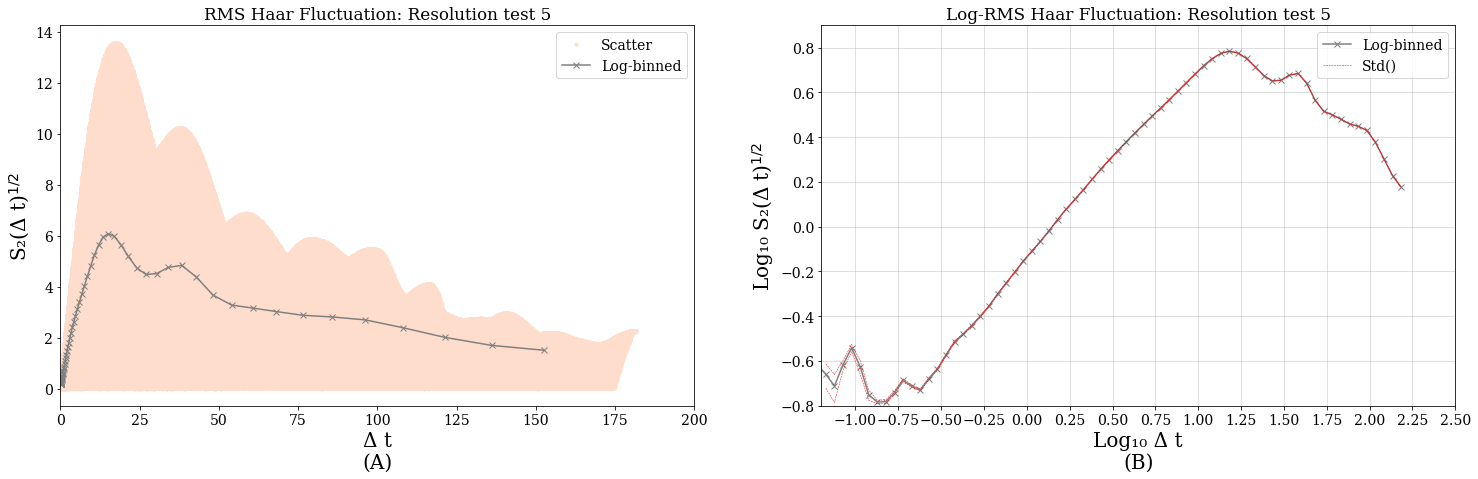

In [124]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(25, 7))

ax1.plot( uni_delta_t5,   np.sqrt(uni_hs5),'.',color='#FFDDCD',label='Scatter')
ax1.plot(10**uni_time5,          uni_amp5,'x-',color='grey',label='Log-binned')
ax1.set(title='RMS Haar Fluctuation: Resolution test 5')
ax1.set_xlabel('\u0394 t\n(A)', fontsize = 20.0)
ax1.set_ylabel('S\u2082(\u0394 t)'+r'$^{1/2}$', fontsize = 20)
ax1.set(xlim=[0,200])
ax1.legend(loc=1)

ax2.plot(uni_time5,np.log10(uni_amp5),'x-',color='grey',label='Log-binned')
ax2.plot(uni_time5,np.log10(uni_app5),'--',color='red',label='Std()',linewidth=0.5)
ax2.plot(uni_time5,np.log10(uni_low5),'--',color='red',linewidth=0.5)
ax2.set(title='Log-RMS Haar Fluctuation: Resolution test 5')
ax2.set_xlabel('Log\u2081\u2080 \u0394 t\n(B)', fontsize = 20.0)
ax2.set_ylabel('Log\u2081\u2080 S\u2082(\u0394 t)'+r'$^{1/2}$', fontsize = 20)
ax2.set_xticks([-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5])

ax2.set(xlim=[-1.2,2.5])
ax2.set(ylim=[-0.8,0.9])
ax2.legend(loc=1)
ax2.grid(alpha=0.5)

#plt.savefig('13-SinteticA2-4-Haar5.pdf',bbox_inches='tight')
plt.show()

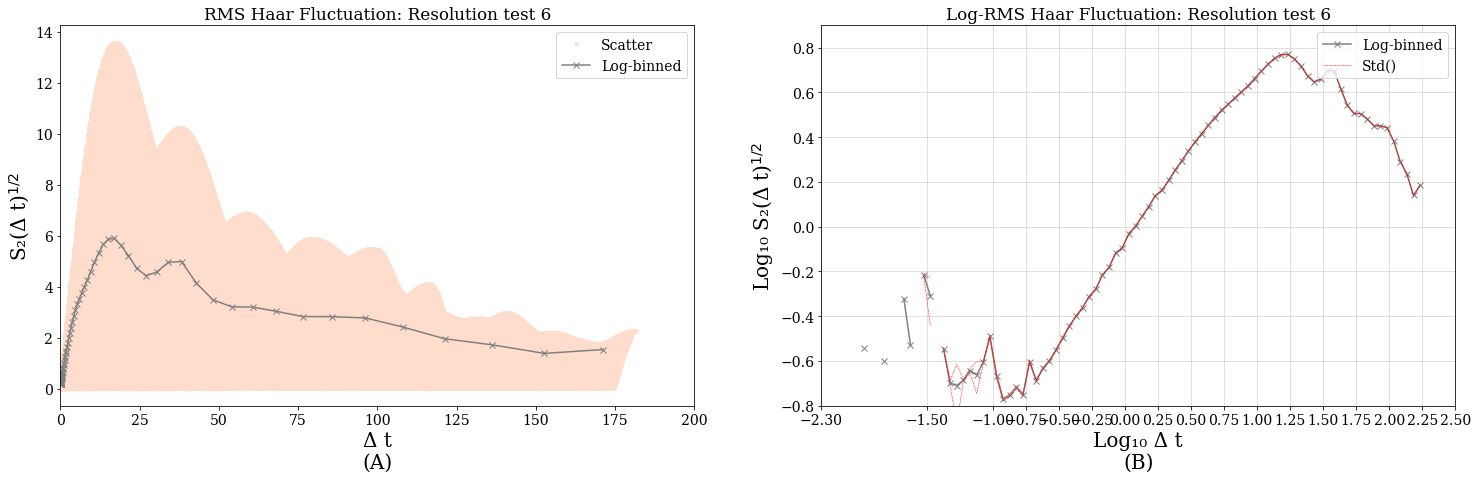

In [18]:
###ALGO ESTA DIFERENTE EN MI HAAAR! LA FUNCIÓN MUESTRA UNOS SPIKES MÁS MARCADOS A ALTAS FRECUENCIAS... SERÁ EL CAMBIO EN SMOOTH?
## ADEMÁS AGREGUÉ VALORES AL EJE X PARA VER SI PILLABA EL PEAK DE 30 Y 5Y

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(25, 7))

ax1.plot( uni_delta_t6,   np.sqrt(uni_hs6),'.',color='#FFDDCD',label='Scatter')
ax1.plot(10**uni_time6,          uni_amp6,'x-',color='grey',label='Log-binned')
ax1.set(title='RMS Haar Fluctuation: Resolution test 6')
ax1.set_xlabel('\u0394 t\n(A)', fontsize = 20.0)
ax1.set_ylabel('S\u2082(\u0394 t)'+r'$^{1/2}$', fontsize = 20)
ax1.set(xlim=[0,200])
ax1.legend(loc=1)

ax2.plot(uni_time6,np.log10(uni_amp6),'x-',color='grey',label='Log-binned')
ax2.plot(uni_time6,np.log10(uni_app6),'--',color='red',label='Std()',linewidth=0.5)
ax2.plot(uni_time6,np.log10(uni_low6),'--',color='red',linewidth=0.5)
ax2.set(title='Log-RMS Haar Fluctuation: Resolution test 6')
ax2.set_xlabel('Log\u2081\u2080 \u0394 t\n(B)', fontsize = 20.0)
ax2.set_ylabel('Log\u2081\u2080 S\u2082(\u0394 t)'+r'$^{1/2}$', fontsize = 20)
ax2.set_xticks([-2.3,-1.5,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5])

#ax2.set(xlim=[-1.2,2.5])
ax2.set(ylim=[-0.8,0.9])
ax2.legend(loc=1)
ax2.grid(alpha=0.5)

#plt.savefig('13-SinteticA2-4-Haar6.pdf',bbox_inches='tight')
plt.show()

In [ ]:
############################
##Ahora testeo el ruido ####
############################

In [7]:
from scipy import stats

def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

In [6]:
#pip install signalz

In [3]:
import signalz

In [33]:
noise1 = np.random.normal(0,0.05,len(T6))
noise2 = np.random.normal(0,0.1,len(T6))
noise3 = np.random.normal(0,0.15,len(T6))
noise4 = np.random.normal(0,0.2,len(T6))

red_noise1 = signalz.brownian_noise(len(T6), leak=0.001, start=0, std=0.05, source="gaussian")
red_noise2 = signalz.brownian_noise(len(T6), leak=0.001, start=0, std=0.1, source="gaussian")
red_noise3 = signalz.brownian_noise(len(T6), leak=0.001, start=0, std=0.15, source="gaussian")
red_noise4 = signalz.brownian_noise(len(T6), leak=0.001, start=0, std=0.2, source="gaussian")

In [4]:
t=np.linspace(0,10000,1000)

### Testeo meter ruido de forma más real! 

In [4]:
from scipy.stats import linregress
import signalz

In [6]:
#t_white=t6[t6>=100]
#t_red = t6[t6<100]
t_white=t6
t_red=t6
white_noise1=np.random.normal(1,0.05,len(t_white))
white_noise2=np.random.normal(1,0.1,len(t_white))

red_noise1=signalz.brownian_noise(len(t_red), leak=0.001, start=0, std=0.05, source="gaussian")
red_noise2=signalz.brownian_noise(len(t_red), leak=0.001, start=0, std=0.1, source="gaussian")

In [6]:
red=signalz.brownian_noise(1000, leak=0.001, start=0, std=0.1, source="gaussian")
t=np.linspace(0,100,1000)
[uni_delta_t4,uni_hs4,uni_time4,uni_amp4,uni_app4,uni_low4]=Haar(t,red)

t samples: 999
deltas_t steps: from 1 to 500
epsilons steps: 500
0  fluctuaciones eliminadas ( 0.0 %)


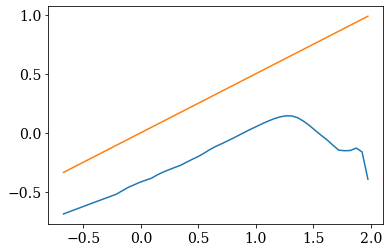

In [8]:
plt.plot(uni_time4,np.log10(uni_amp4))
plt.plot(uni_time4,0.5*uni_time4)

In [13]:
print(len(white_noise1),len(t_white))
print(len(red_noise1),len(t_red))

502 502
2971 2971


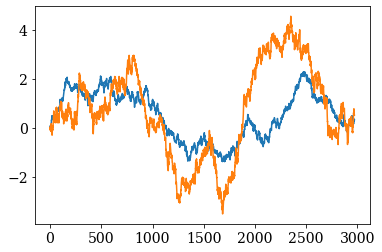

In [113]:
plt.plot(red_noise1)
plt.plot(red_noise2)

In [7]:
[uni_delta_t1,uni_hs1,uni_time1,uni_amp1,uni_app1,uni_low1]=Haar(t_white,white_noise1)
[uni_delta_t2,uni_hs2,uni_time2,uni_amp2,uni_app2,uni_low2]=Haar(t_white,white_noise2)
[uni_delta_t3,uni_hs3,uni_time3,uni_amp3,uni_app3,uni_low3]=Haar(t_red,red_noise1)
[uni_delta_t4,uni_hs4,uni_time4,uni_amp4,uni_app4,uni_low4]=Haar(t_red,red_noise2)

t samples: 3472
deltas_t steps: from 1 to 1736
epsilons steps: 1736


<ipython-input-2-b432793d649f>:28: RuntimeWarning: invalid value encountered in true_divide
  int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
<ipython-input-2-b432793d649f>:27: RuntimeWarning: invalid value encountered in true_divide
  int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])


861930  fluctuaciones eliminadas ( 28.633407801742393 %)
t samples: 3472
deltas_t steps: from 1 to 1736
epsilons steps: 1736


<ipython-input-2-b432793d649f>:28: RuntimeWarning: invalid value encountered in true_divide
  int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
<ipython-input-2-b432793d649f>:27: RuntimeWarning: invalid value encountered in true_divide
  int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])


861930  fluctuaciones eliminadas ( 28.633407801742393 %)
t samples: 3472
deltas_t steps: from 1 to 1736
epsilons steps: 1736


<ipython-input-2-b432793d649f>:28: RuntimeWarning: invalid value encountered in true_divide
  int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
<ipython-input-2-b432793d649f>:27: RuntimeWarning: invalid value encountered in true_divide
  int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])


861930  fluctuaciones eliminadas ( 28.633407801742393 %)
t samples: 3472
deltas_t steps: from 1 to 1736
epsilons steps: 1736


<ipython-input-2-b432793d649f>:28: RuntimeWarning: invalid value encountered in true_divide
  int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
<ipython-input-2-b432793d649f>:27: RuntimeWarning: invalid value encountered in true_divide
  int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])


861930  fluctuaciones eliminadas ( 28.633407801742393 %)


In [8]:
print('slope W1 ',linregress(uni_time1, np.log10(uni_amp1))[0])
print('slope W2 ',linregress(uni_time2, np.log10(uni_amp2))[0])
print('slope R1 ',linregress(uni_time3, np.log10(uni_amp3))[0])
print('slope R2 ',linregress(uni_time4, np.log10(uni_amp4))[0])


slope W1  -0.39442023963764583
slope W2  -0.22661498662090343
slope R1  0.14989015307383513
slope R2  0.3253627940937907


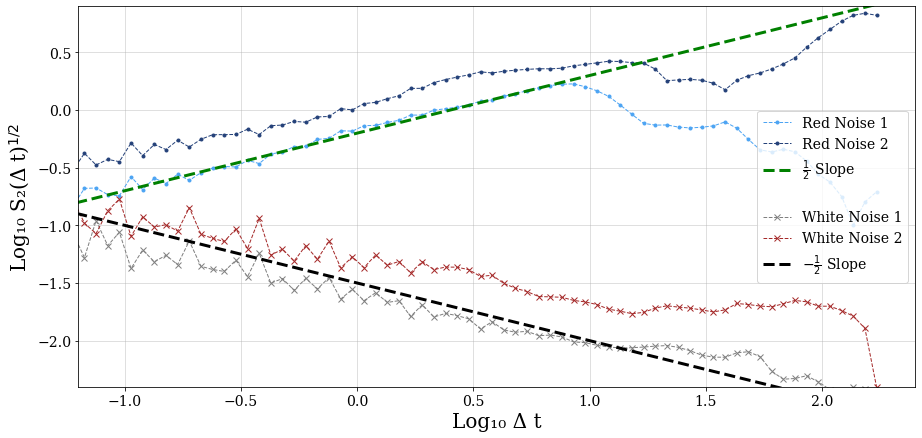

In [11]:
plt.subplots(figsize=(15, 7))

plt.plot(uni_time3,np.log10(uni_amp3),'.--',color='#4CA4F3',label='Red Noise 1',linewidth=1)
plt.plot(uni_time4,np.log10(uni_amp4),'.--',color='#244179',label='Red Noise 2',linewidth=1)
plt.plot(uni_time3,0.5*uni_time3-0.2,linestyle='--',linewidth=3,color='g',label=r'$\frac{1}{2}$ Slope')
plt.plot(uni_time1,np.log10(uni_amp2)-10,color='white',label=' ')

plt.plot(uni_time1,np.log10(uni_amp1),'x--',color='grey',label='White Noise 1',linewidth=1)
plt.plot(uni_time2,np.log10(uni_amp2),'x--',color='brown',label='White Noise 2',linewidth=1)
plt.plot(uni_time1,-0.5*uni_time1-1.5,linestyle='--',linewidth=3,color='black',label=r'$-\frac{1}{2}$ Slope')


plt.xlabel('Log\u2081\u2080 \u0394 t', fontsize = 20.0)
plt.ylabel('Log\u2081\u2080 S\u2082(\u0394 t)'+r'$^{1/2}$', fontsize = 20)
#plt.xticks([-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5])

#ax2.set(ylim=[-0.8,0.9])
plt.legend(loc=0)
plt.grid(alpha=0.5)
plt.xlim([-1.2,2.4])
plt.ylim([-2.4,0.9])
#plt.savefig('13-SinteticA2-5-Noises slopes.pdf',bbox_inches='tight')
#plt.savefig('13-SinteticA2-5-Noises slopes.jpg',bbox_inches='tight')
plt.show()

In [13]:
Noise1=red_noise1+white_noise1#np.concatenate((red_noise1,white_noise1))
Noise2=red_noise2+white_noise2#np.concatenate((red_noise2,white_noise2))

In [14]:
[uni_delta_t11,uni_hs11,uni_time11,uni_amp11,uni_app11,uni_low11]=Haar(t6,Noise1)
[uni_delta_t22,uni_hs22,uni_time22,uni_amp22,uni_app22,uni_low22]=Haar(t6,Noise2)

t samples: 3472
deltas_t steps: from 1 to 1736
epsilons steps: 1736


<ipython-input-2-b432793d649f>:28: RuntimeWarning: invalid value encountered in true_divide
  int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
<ipython-input-2-b432793d649f>:27: RuntimeWarning: invalid value encountered in true_divide
  int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])


861930  fluctuaciones eliminadas ( 28.633407801742393 %)
t samples: 3472
deltas_t steps: from 1 to 1736
epsilons steps: 1736


<ipython-input-2-b432793d649f>:28: RuntimeWarning: invalid value encountered in true_divide
  int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
<ipython-input-2-b432793d649f>:27: RuntimeWarning: invalid value encountered in true_divide
  int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])


861930  fluctuaciones eliminadas ( 28.633407801742393 %)


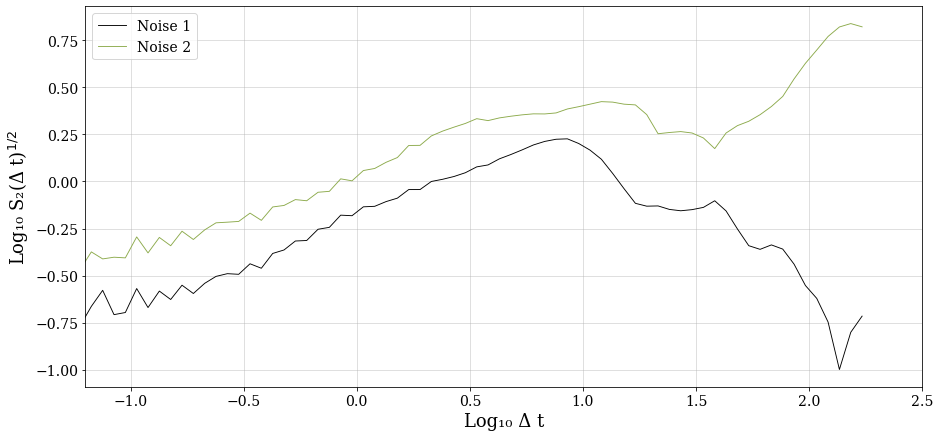

In [16]:
plt.subplots(figsize=(15, 7))
plt.plot(uni_time11,np.log10(uni_amp11),'-',label='Noise 1',color='black',linewidth=0.9)
plt.plot(uni_time22,np.log10(uni_amp22),'-',label='Noise 2',color='#8caa4b',linewidth=0.9)


#plt.plot(uni_time6,-0.5*uni_time6-0.9,linestyle='--',linewidth=3,color='black',label=r'$-\frac{1}{2}$ Slope')
#plt.plot(uni_time6[:65],0.5*uni_time6[:65]-0.1,linestyle='--',linewidth=2,color='r',label=r'$\frac{1}{2}$ Slope')
#plt.plot(uni_time6[55:79],-0.5*uni_time6[55:79]+1.3,linestyle='--',linewidth=2,color='orange',label=r'$-\frac{1}{2}$ Slope')

plt.xlabel('Log\u2081\u2080 \u0394 t',fontsize=18);plt.ylabel('Log\u2081\u2080 S\u2082(\u0394 t)'+r'$^{1/2}$',fontsize=18)
plt.xlim([-1.2,2.5])
plt.legend()
plt.grid(alpha=0.5)


#plt.savefig('13-SinteticA2-5-Noises slopes2.pdf',bbox_inches='tight')
#plt.savefig('13-SinteticA2-5-Noises slopes2.jpg',bbox_inches='tight')

plt.show()

In [123]:
len(uni_time6)

79

In [147]:
#[uni_delta_t77,uni_hs77,uni_time77,uni_amp77,uni_app77,uni_low77]=Haar(t6,T6+Noise1)
[uni_delta_t88,uni_hs88,uni_time88,uni_amp88,uni_app88,uni_low88]=Haar(t6,T6+Noise2)

t samples: 3472
deltas_t steps: from 1 to 1736
epsilons steps: 1736


<ipython-input-4-b432793d649f>:28: RuntimeWarning: invalid value encountered in true_divide
  int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
<ipython-input-4-b432793d649f>:27: RuntimeWarning: invalid value encountered in true_divide
  int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])


861930  fluctuaciones eliminadas ( 28.633407801742393 %)


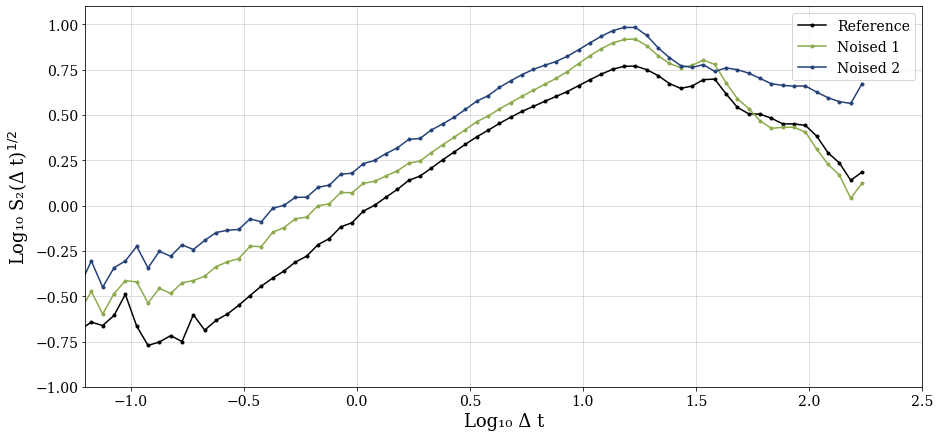

In [187]:
plt.subplots(figsize=(15, 7))
plt.plot(uni_time6,np.log10(uni_amp6),'.-',label='Reference',color='black')
#plt.plot(uni_time6,np.log10(uni_app6),'-',color='grey')
#plt.plot(uni_time6,np.log10(uni_low6),'-',color='grey')

plt.plot(uni_time77,np.log10(uni_amp77),'.-',label='Noised 1',color='#8caa4b')
#plt.plot(uni_time77,np.log10(uni_app77),'-',color='g')
#plt.plot(uni_time77,np.log10(uni_low77),'-',color='g')

plt.plot(uni_time88,np.log10(uni_amp88),'.-',label='Noised 2',color='#244179')
#plt.plot(uni_time88,np.log10(uni_app88),'-',color='c')
#plt.plot(uni_time88,np.log10(uni_low88),'-',color='c')

#plt.title('Length Test - Haar Fluctuation')
plt.xlabel('Log\u2081\u2080 \u0394 t',fontsize=18);plt.ylabel('Log\u2081\u2080 S\u2082(\u0394 t)'+r'$^{1/2}$',fontsize=18)
plt.xlim([-1.2,2.5]);
plt.ylim([-1,1.1]);
plt.legend()
plt.grid(alpha=0.5)

#plt.axvline(x=np.log10(10))#plt.axvline(x=np.log10(50))#plt.axvline(x=np.log10(100))#plt.axvline(x=np.log10(150))

#plt.savefig('13-SinteticA2-5-Noises haar.pdf',bbox_inches='tight')
#plt.savefig('13-SinteticA2-5-Noises haar.jpg',bbox_inches='tight')

plt.show()

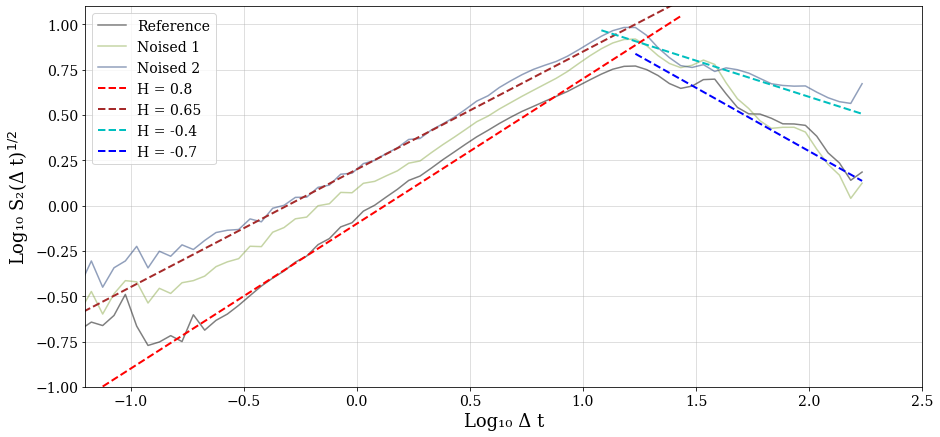

In [188]:
plt.subplots(figsize=(15, 7))
plt.plot(uni_time6,np.log10(uni_amp6),'-',label='Reference',color='black',alpha=0.5)
#plt.plot(uni_time6,np.log10(uni_app6),'-',color='grey')
#plt.plot(uni_time6,np.log10(uni_low6),'-',color='grey')

plt.plot(uni_time77,np.log10(uni_amp77),'-',label='Noised 1',color='#8caa4b',alpha=0.5)
#plt.plot(uni_time77,np.log10(uni_app77),'-',color='g')
#plt.plot(uni_time77,np.log10(uni_low77),'-',color='g')

plt.plot(uni_time88,np.log10(uni_amp88),'-',label='Noised 2',color='#244179',alpha=0.5)
#plt.plot(uni_time88,np.log10(uni_app88),'-',color='c')
#plt.plot(uni_time88,np.log10(uni_low88),'-',color='c')

plt.plot(uni_time6[:63],0.8*uni_time6[:63]-0.1,linestyle='--',linewidth=2,color='r',label='H = 0.8')
plt.plot(uni_time6[:63],0.65*uni_time6[:63]+0.2,linestyle='--',linewidth=2,color='brown',label='H = 0.65')

plt.plot(uni_time6[55:79],-0.4*uni_time6[55:79]+1.4,linestyle='--',linewidth=2,color='c',label='H = -0.4')
plt.plot(uni_time6[58:79],-0.7*uni_time6[58:79]+1.7,linestyle='--',linewidth=2,color='b',label='H = -0.7')


#plt.title('Length Test - Haar Fluctuation')
plt.xlabel('Log\u2081\u2080 \u0394 t',fontsize=18);plt.ylabel('Log\u2081\u2080 S\u2082(\u0394 t)'+r'$^{1/2}$',fontsize=18)
plt.xlim([-1.2,2.5]);
plt.ylim([-1,1.1]);
plt.legend()
plt.grid(alpha=0.5)

#plt.axvline(x=np.log10(10))#plt.axvline(x=np.log10(50))#plt.axvline(x=np.log10(100))#plt.axvline(x=np.log10(150))

#plt.savefig('13-SinteticA2-5-Noises haar-slope.pdf',bbox_inches='tight')
#plt.savefig('13-SinteticA2-5-Noises haar-slope.jpg',bbox_inches='tight')

plt.show()

In [189]:
10**1.5

31.622776601683793

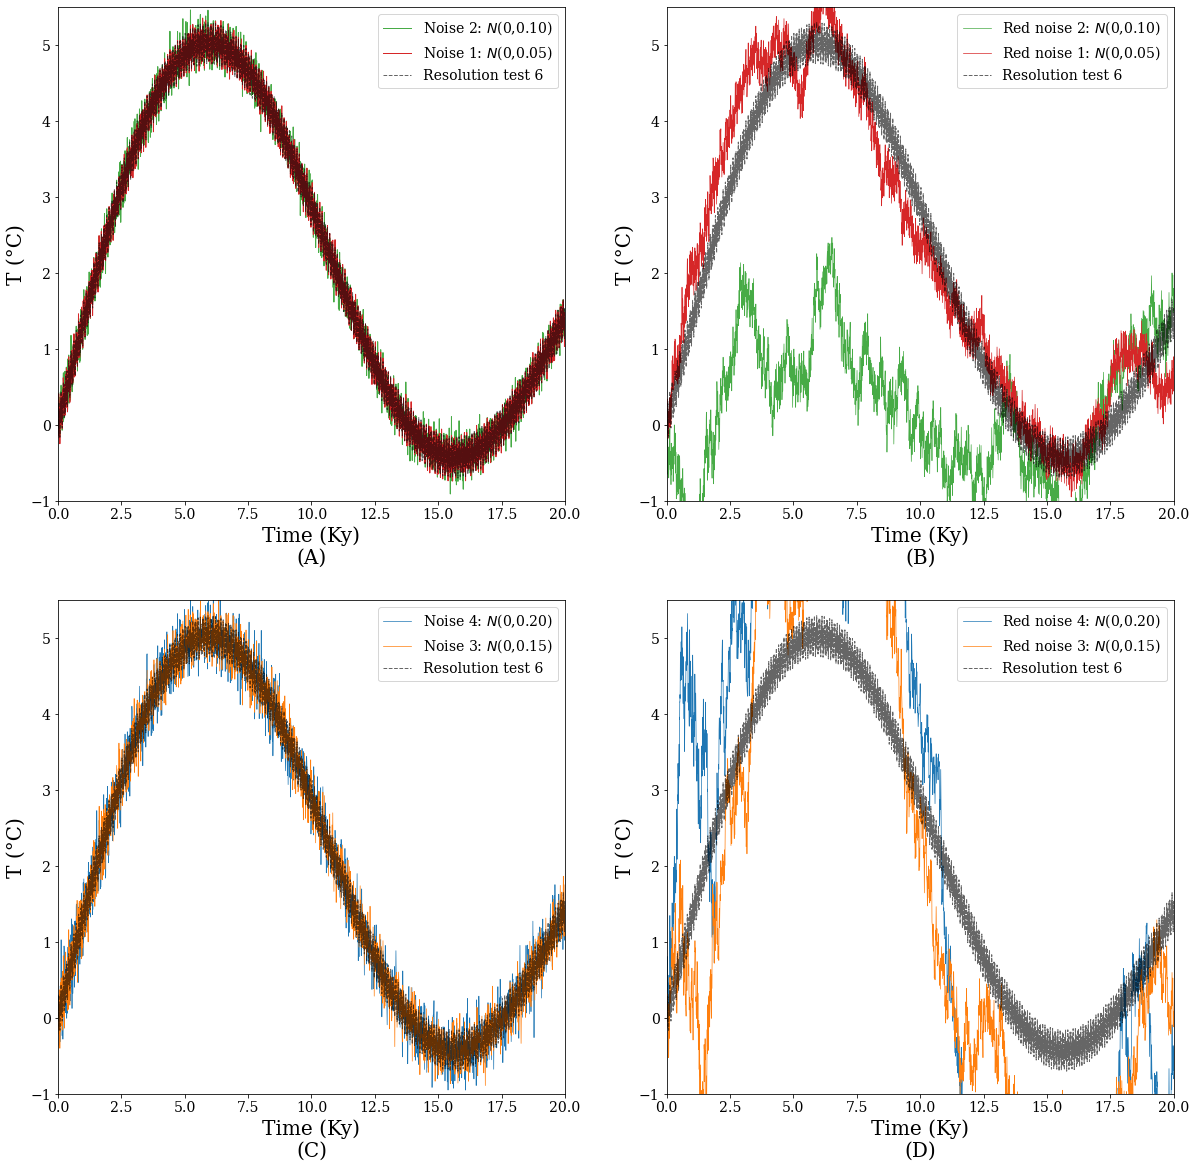

In [34]:
fig, axs = plt.subplots(2, 2,figsize=(20, 20))
#fig.suptitle('White and Red Noise waves')

axs[0,0].plot(t6,T6+noise2,label='Noise 2: '+ r'$N$(0,0.10)',color='#47AB46',linewidth=1)
axs[0,0].plot(t6,T6+noise1,label='Noise 1: '+ r'$N$(0,0.05)',color='#D62728',linewidth=1)
axs[0,0].plot(t6,T6,label='Resolution test 6',linestyle='--',color='black',linewidth=1,alpha=0.6)
axs[0,0].set_xlabel('Time (Ky)\n(A)', fontsize = 20.0)
axs[0,0].set_ylabel('T (°C)', fontsize = 20.0)
#axs[0,0].set(title='White noise 1&2')
axs[0,0].legend()
axs[0,0].set(xlim=[0,20],ylim=[-1,5.5])

axs[1,0].plot(t6,T6+noise4,label='Noise 4: '+ r'$N$(0,0.20)',linewidth=0.7)
axs[1,0].plot(t6,T6+noise3,label='Noise 3: '+ r'$N$(0,0.15)',linewidth=0.7)
axs[1,0].plot(t6,T6,label='Resolution test 6',linestyle='--',color='black',linewidth=1,alpha=0.6)
#axs[1,0].set(title='White noise 3&4')
axs[1,0].set_xlabel('Time (Ky)\n(C)', fontsize = 20.0)
axs[1,0].set_ylabel('T (°C)', fontsize = 20.0)
axs[1,0].legend()
axs[1,0].set(xlim=[0,20],ylim=[-1,5.5])

axs[0,1].plot(t6,T6+red_noise2,label='Red noise 2: '+ r'$N$(0,0.10)',color='#47AB46',linewidth=0.7)
axs[0,1].plot(t6,T6+red_noise1,label='Red noise 1: '+ r'$N$(0,0.05)',color='#D62728',linewidth=0.7)
axs[0,1].plot(t6,T6,label='Resolution test 6',linestyle='--',color='black',linewidth=1,alpha=0.6)
axs[0,1].set_xlabel('Time (Ky)\n(B)', fontsize = 20.0)
axs[0,1].set_ylabel('T (°C)', fontsize = 20.0)
#axs[0,1].set(title='Resolution test 6 & red noise (leak:0.3)')
axs[0,1].legend()
axs[0,1].set(xlim=[0,20],ylim=[-1,5.5])

axs[1,1].plot(t6,T6+red_noise4,label='Red noise 4: '+ r'$N$(0,0.20)',linewidth=0.7)
axs[1,1].plot(t6,T6+red_noise3,label='Red noise 3: '+ r'$N$(0,0.15)',linewidth=0.7)
axs[1,1].plot(t6,T6,label='Resolution test 6',linestyle='--',color='black',linewidth=1,alpha=0.6)
axs[1,1].set_xlabel('Time (Ky)\n(D)', fontsize = 20.0)
axs[1,1].set_ylabel('T (°C)', fontsize = 20.0)
#axs[1,1].set(title='Resolution test 6 & red noise (leak:0.3)')
axs[1,1].legend()
axs[1,1].set(xlim=[0,20],ylim=[-1,5.5])

#plt.savefig('13-SinteticA2-5-Noises.pdf',bbox_inches='tight')
plt.show()

In [140]:
print(signaltonoise(T6+noise1, axis = 0, ddof = 0))
print(signaltonoise(T6+noise2, axis = 0, ddof = 0))
print(signaltonoise(T6+noise3, axis = 0, ddof = 0))
print(signaltonoise(T6+noise4, axis = 0, ddof = 0))

0.4851273159178229
0.4846168464510677
0.4860183913536037
0.4836921938784322


In [141]:
print(signaltonoise(T6+red_noise1, axis = 0, ddof = 0))
print(signaltonoise(T6+red_noise2, axis = 0, ddof = 0))
print(signaltonoise(T6+red_noise3, axis = 0, ddof = 0))
print(signaltonoise(T6+red_noise4, axis = 0, ddof = 0))

0.48618212774796365
0.48625754953622524
0.48615503475580324
0.4795432127641611


In [35]:
[uni_delta_t7,uni_hs7,uni_time7,uni_amp7,uni_app7,uni_low7]=Haar(t6,T6+noise1)
[uni_delta_t8,uni_hs8,uni_time8,uni_amp8,uni_app8,uni_low8]=Haar(t6,T6+noise2)
[uni_delta_t9,uni_hs9,uni_time9,uni_amp9,uni_app9,uni_low9]=Haar(t6,T6+noise3)
[uni_delta_t10,uni_hs10,uni_time10,uni_amp10,uni_app10,uni_low10]=Haar(t6,T6+noise4)

t samples: 3472
deltas_t steps: from 1 to 1736
epsilons steps: 1736


<ipython-input-2-b432793d649f>:28: RuntimeWarning: invalid value encountered in true_divide
  int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
<ipython-input-2-b432793d649f>:27: RuntimeWarning: invalid value encountered in true_divide
  int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])


861930  fluctuaciones eliminadas ( 28.633407801742393 %)
t samples: 3472
deltas_t steps: from 1 to 1736
epsilons steps: 1736


<ipython-input-2-b432793d649f>:28: RuntimeWarning: invalid value encountered in true_divide
  int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
<ipython-input-2-b432793d649f>:27: RuntimeWarning: invalid value encountered in true_divide
  int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])


861930  fluctuaciones eliminadas ( 28.633407801742393 %)
t samples: 3472
deltas_t steps: from 1 to 1736
epsilons steps: 1736


<ipython-input-2-b432793d649f>:28: RuntimeWarning: invalid value encountered in true_divide
  int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
<ipython-input-2-b432793d649f>:27: RuntimeWarning: invalid value encountered in true_divide
  int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])


861930  fluctuaciones eliminadas ( 28.633407801742393 %)
t samples: 3472
deltas_t steps: from 1 to 1736
epsilons steps: 1736


<ipython-input-2-b432793d649f>:28: RuntimeWarning: invalid value encountered in true_divide
  int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
<ipython-input-2-b432793d649f>:27: RuntimeWarning: invalid value encountered in true_divide
  int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])


861930  fluctuaciones eliminadas ( 28.633407801742393 %)


In [36]:
[uni_delta_t11,uni_hs11,uni_time11,uni_amp11,uni_app11,uni_low11]=Haar(t6,T6+red_noise1)
[uni_delta_t12,uni_hs12,uni_time12,uni_amp12,uni_app12,uni_low12]=Haar(t6,T6+red_noise2)
[uni_delta_t13,uni_hs13,uni_time13,uni_amp13,uni_app13,uni_low13]=Haar(t6,T6+red_noise3)
[uni_delta_t14,uni_hs14,uni_time14,uni_amp14,uni_app14,uni_low14]=Haar(t6,T6+red_noise4)

t samples: 3472
deltas_t steps: from 1 to 1736
epsilons steps: 1736


<ipython-input-2-b432793d649f>:28: RuntimeWarning: invalid value encountered in true_divide
  int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
<ipython-input-2-b432793d649f>:27: RuntimeWarning: invalid value encountered in true_divide
  int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])


861930  fluctuaciones eliminadas ( 28.633407801742393 %)
t samples: 3472
deltas_t steps: from 1 to 1736
epsilons steps: 1736


<ipython-input-2-b432793d649f>:28: RuntimeWarning: invalid value encountered in true_divide
  int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
<ipython-input-2-b432793d649f>:27: RuntimeWarning: invalid value encountered in true_divide
  int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])


861930  fluctuaciones eliminadas ( 28.633407801742393 %)
t samples: 3472
deltas_t steps: from 1 to 1736
epsilons steps: 1736


<ipython-input-2-b432793d649f>:28: RuntimeWarning: invalid value encountered in true_divide
  int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
<ipython-input-2-b432793d649f>:27: RuntimeWarning: invalid value encountered in true_divide
  int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])


861930  fluctuaciones eliminadas ( 28.633407801742393 %)
t samples: 3472
deltas_t steps: from 1 to 1736
epsilons steps: 1736


<ipython-input-2-b432793d649f>:28: RuntimeWarning: invalid value encountered in true_divide
  int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
<ipython-input-2-b432793d649f>:27: RuntimeWarning: invalid value encountered in true_divide
  int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])


861930  fluctuaciones eliminadas ( 28.633407801742393 %)


In [56]:
#plt.plot(t6[t6<=100])
len(t6[t6<=100])

2972

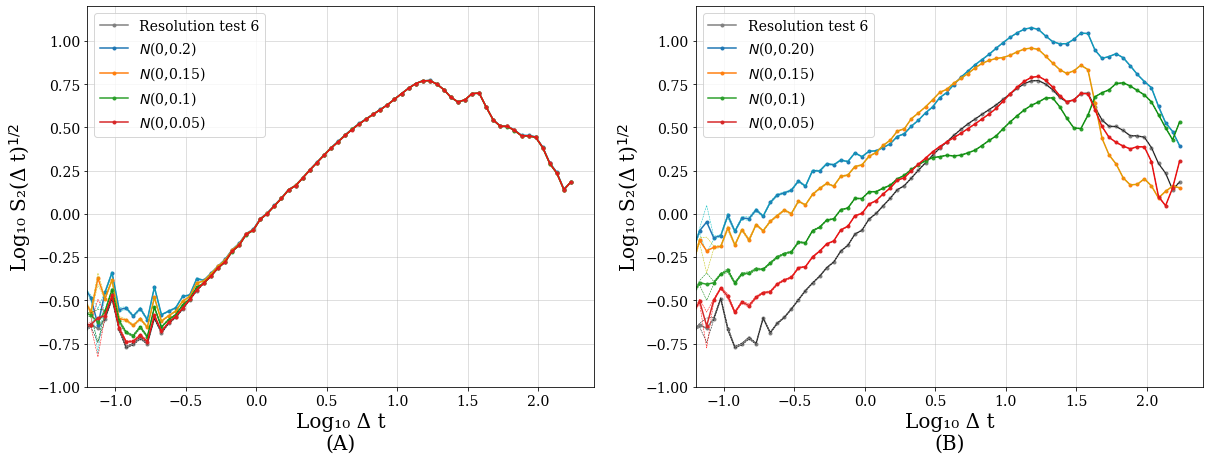

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20, 7))
#fig.suptitle('Test 6 & noise Haar Fluctuation comparison')

ax1.plot(uni_time6,np.log10(uni_amp6),'.-',color='grey',label='Resolution test 6')
ax1.plot(uni_time6,np.log10(uni_app6),'--',color='black',linewidth=0.5)
ax1.plot(uni_time6,np.log10(uni_low6),'--',color='black',linewidth=0.5)

ax1.plot(uni_time10,np.log10(uni_amp10),'.-',label=r'$N$(0,0.2)')
ax1.plot(uni_time10,np.log10(uni_app10),'--',color='c',linewidth=0.5)
ax1.plot(uni_time10,np.log10(uni_low10),'--',color='c',linewidth=0.5)

ax1.plot(uni_time9,np.log10(uni_amp9),'.-',label=r'$N$(0,0.15)')
ax1.plot(uni_time9,np.log10(uni_app9),'--',color='y',linewidth=0.5)
ax1.plot(uni_time9,np.log10(uni_low9),'--',color='y',linewidth=0.5)

ax1.plot(uni_time8,np.log10(uni_amp8),'.-',label=r'$N$(0,0.1)')
ax1.plot(uni_time8,np.log10(uni_app8),'--',color='g',linewidth=0.5)
ax1.plot(uni_time8,np.log10(uni_low8),'--',color='g',linewidth=0.5)

ax1.plot(uni_time7,np.log10(uni_amp7),'.-',label=r'$N$(0,0.05)')
ax1.plot(uni_time7,np.log10(uni_app7),'--',color='r',linewidth=0.5)
ax1.plot(uni_time7,np.log10(uni_low7),'--',color='r',linewidth=0.5)

ax1.set_xlabel('Log\u2081\u2080 \u0394 t\n(A)', fontsize = 20.0)
ax1.set_ylabel('Log\u2081\u2080 S\u2082(\u0394 t)'+r'$^{1/2}$', fontsize = 20.0)
ax1.grid(alpha=0.5)
ax1.legend()

ax2.plot(uni_time6,np.log10(uni_amp6),'.-',color='grey',label='Resolution test 6')
ax2.plot(uni_time6,np.log10(uni_app6),'--',color='black',linewidth=0.5)
ax2.plot(uni_time6,np.log10(uni_low6),'--',color='black',linewidth=0.5)

ax2.plot(uni_time14,np.log10(uni_amp14),'.-',label=r'$N$(0,0.20)')
ax2.plot(uni_time14,np.log10(uni_app14),'--',color='c',linewidth=0.5)
ax2.plot(uni_time14,np.log10(uni_low14),'--',color='c',linewidth=0.5)

ax2.plot(uni_time13,np.log10(uni_amp13),'.-',label=r'$N$(0,0.15)')
ax2.plot(uni_time13,np.log10(uni_app13),'--',color='y',linewidth=0.5)
ax2.plot(uni_time13,np.log10(uni_low13),'--',color='y',linewidth=0.5)

ax2.plot(uni_time12,np.log10(uni_amp12),'.-',label=r'$N$(0,0.1)')
ax2.plot(uni_time12,np.log10(uni_app12),'--',color='g',linewidth=0.5)
ax2.plot(uni_time12,np.log10(uni_low12),'--',color='g',linewidth=0.5)

ax2.plot(uni_time11,np.log10(uni_amp11),'.-',label=r'$N$(0,0.05)')
ax2.plot(uni_time11,np.log10(uni_app11),'--',color='r',linewidth=0.5)
ax2.plot(uni_time11,np.log10(uni_low11),'--',color='r',linewidth=0.5)

ax2.set_xlabel('Log\u2081\u2080 \u0394 t\n(B)', fontsize = 20.0)
ax2.set_ylabel('Log\u2081\u2080 S\u2082(\u0394 t)'+r'$^{1/2}$', fontsize = 20.0)
ax2.grid(alpha=0.5)
ax2.legend()

ax1.set_xlim([-1.2,2.4])
ax2.set_xlim([-1.2,2.4])
ax1.set_ylim([-1,1.2])
ax2.set_ylim([-1,1.2])

#plt.savefig('13-SinteticA2-6-Haar Noises.pdf',bbox_inches='tight')
plt.show()

In [ ]:
### CREO QUE AQUÍ LO INTERESANTE ES CÓMO EL RUIDO DESPLAZA A LA DERECHA MI POSIBLE ESTIMACIÓN DE tau_C
# La cosa es que el ruido rojo lo hace pico... y el sig/noise no me indica mucho... 

## Ahora testeo el efecto de cortar el dataset

In [57]:
s1,S1=np.copy([t6[t6<10],T6[t6<10]])
s2,S2=np.copy([t6[t6<50],T6[t6<50]])
s3,S3=np.copy([t6[t6<100],T6[t6<100]])
s4,S4=np.copy([t6[t6<150],T6[t6<150]])

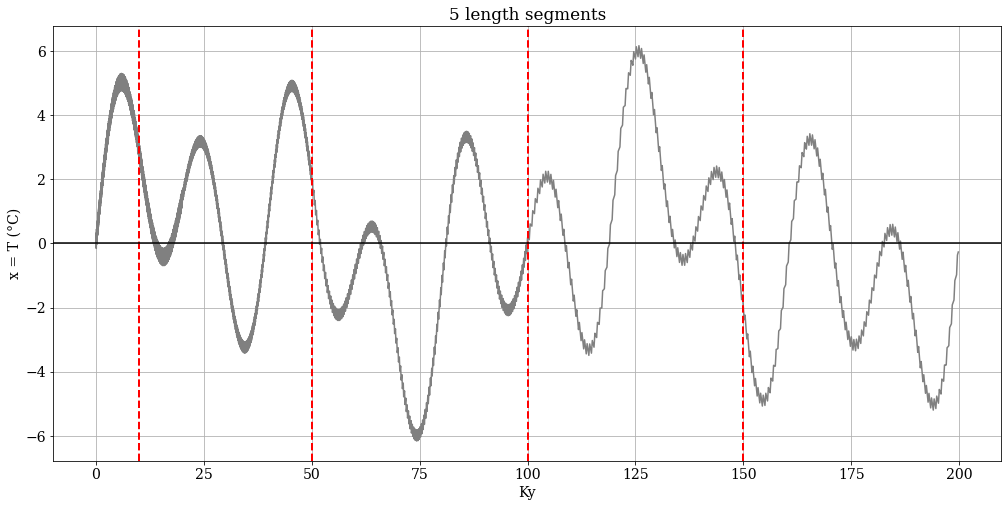

In [105]:
plt.subplots(figsize=(17, 8))
plt.plot(t6, T6,'-',label='Full lenght',color='grey')

plt.axvline(x=10,color='red',linestyle='--',linewidth=2)
plt.axvline(x=50,color='red',linestyle='--',linewidth=2)
plt.axvline(x=100,color='red',linestyle='--',linewidth=2)
plt.axvline(x=150,color='red',linestyle='--',linewidth=2)

plt.title('5 length segments');plt.xlabel('Ky');plt.ylabel('x = T (°C)')
plt.grid(True, which='both');plt.axhline(y=0, color='k')
#plt.legend()
#plt.xlim([2,4])

#plt.savefig('Wave 5 segments.jpg',bbox_inches='tight')
plt.show()

In [58]:
[uni_delta_s1,uni_hss1,uni_times1,uni_amps1,uni_apps1,uni_lows1]=Haar(s1,S1)
[uni_delta_s2,uni_hss2,uni_times2,uni_amps2,uni_apps2,uni_lows2]=Haar(s2,S2)
[uni_delta_s3,uni_hss3,uni_times3,uni_amps3,uni_apps3,uni_lows3]=Haar(s3,S3)
[uni_delta_s4,uni_hss4,uni_times4,uni_amps4,uni_apps4,uni_lows4]=Haar(s4,S4)

t samples: 1201
deltas_t steps: from 1 to 601
epsilons steps: 601


<ipython-input-2-f4857a5efce7>:28: RuntimeWarning: invalid value encountered in true_divide
  int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
<ipython-input-2-f4857a5efce7>:27: RuntimeWarning: invalid value encountered in true_divide
  int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])


3  fluctuaciones eliminadas ( 0.0008347245409015025 %)
Min t:  -2.0000000000000093   Max t:  0.9989129043587784
t samples: 2469
deltas_t steps: from 1 to 1235
epsilons steps: 1235


<ipython-input-2-f4857a5efce7>:28: RuntimeWarning: invalid value encountered in true_divide
  int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
<ipython-input-2-f4857a5efce7>:27: RuntimeWarning: invalid value encountered in true_divide
  int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])


117947  fluctuaciones eliminadas ( 7.7519089438075826 %)
Min t:  -2.0000000000000093   Max t:  1.6333674451170106
t samples: 2970
deltas_t steps: from 1 to 1485
epsilons steps: 1485


<ipython-input-2-f4857a5efce7>:28: RuntimeWarning: invalid value encountered in true_divide
  int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
<ipython-input-2-f4857a5efce7>:27: RuntimeWarning: invalid value encountered in true_divide
  int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])


449617  fluctuaciones eliminadas ( 20.41620047805523 %)
Min t:  -2.0000000000000093   Max t:  1.9438406264012642
t samples: 3221
deltas_t steps: from 1 to 1611
epsilons steps: 1611


<ipython-input-2-f4857a5efce7>:28: RuntimeWarning: invalid value encountered in true_divide
  int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
<ipython-input-2-f4857a5efce7>:27: RuntimeWarning: invalid value encountered in true_divide
  int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])


643309  fluctuaciones eliminadas ( 24.833487100895972 %)
Min t:  -2.0000000000000093   Max t:  2.118215108501


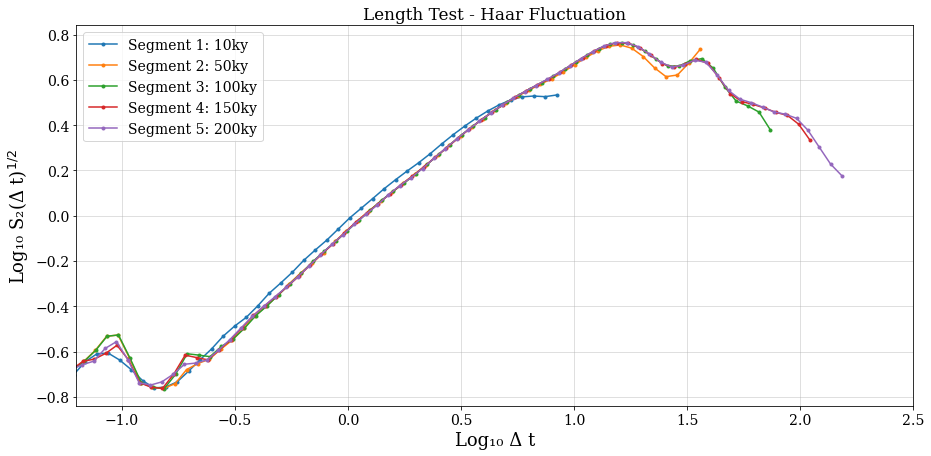

In [60]:
plt.subplots(figsize=(15, 7))
plt.plot(uni_times1,np.log10(uni_amps1),'.-',label='Segment 1: 10ky')
plt.plot(uni_times2,np.log10(uni_amps2),'.-',label='Segment 2: 50ky')
plt.plot(uni_times3,np.log10(uni_amps3),'.-',label='Segment 3: 100ky')
plt.plot(uni_times4,np.log10(uni_amps4),'.-',label='Segment 4: 150ky')
plt.plot(uni_time6,np.log10(uni_amp6),'.-',label='Segment 5: 200ky')

plt.title('Length Test - Haar Fluctuation')
plt.xlabel('Log\u2081\u2080 \u0394 t',fontsize=18);plt.ylabel('Log\u2081\u2080 S\u2082(\u0394 t)'+r'$^{1/2}$',fontsize=18)
plt.xlim([-1.2,2.5]);plt.legend()
plt.grid(alpha=0.5)

#plt.axvline(x=np.log10(10))#plt.axvline(x=np.log10(50))#plt.axvline(x=np.log10(100))#plt.axvline(x=np.log10(150))

#plt.savefig('13-SinteticA2-7-length test.pdf',bbox_inches='tight')
plt.show()

### Amplitud test
###### Comparo con test6 + pi/4

In [195]:
## IMPORTANTE: Desface de pi/4 en la onda de periodo 5 para poder ver los efectos de su amplitud
#cómo estaba sampleado a max 5y, no me estaba aportando nada en los resultados... 
def wave_amps(res1,res2,res3,res4,res5,res6,name,amp1,amp2,amp3):    
    kyears1=2; 
    kyears2=10;
    kyears3=20;
    kyears4=50;
    kyears5=100;
    kyears6=200;    
    
    t11 = np.arange(0, kyears1+res1, res1); t21 = np.arange(0, kyears1+res1, res1); t31 = np.arange(0, kyears1+res1, res1);
    x11 = amp1*np.sin(2000*np.pi*t11/5+np.pi/4); x21 = amp2*np.sin(2000*np.pi*t21/30); x31 = amp3*np.sin(2000*np.pi*t31/100);
    t41 = np.arange(0, kyears1+res1, res1); t51 = np.arange(0, kyears1+res1, res1); t61 = np.arange(0, kyears1+res1, res1);
    x41 = 3*np.sin(2*np.pi*t41/20); x51 = 2*np.sin(2*np.pi*t51/40); x61 = 1.5*np.sin(2*np.pi*t61/100); 
    T1=x11+x21+x31+x41+x51+x61

    t12 = np.arange(kyears1, kyears2+res2, res2); t22 = np.arange(kyears1, kyears2+res2, res2); t32 = np.arange(kyears1, kyears2+res2, res2);
    x12 = amp1*np.sin(2000*np.pi*t12/5+np.pi/4); x22 = amp2*np.sin(2000*np.pi*t22/30); x32 = amp3*np.sin(2000*np.pi*t32/100);
    t42 = np.arange(kyears1, kyears2+res2, res2); t52 = np.arange(kyears1, kyears2+res2, res2); t62 = np.arange(kyears1, kyears2+res2, res2);
    x42 = 3*np.sin(2*np.pi*t42/20); x52 = 2*np.sin(2*np.pi*t52/40); x62 = 1.5*np.sin(2*np.pi*t62/100); 
    T2=x12+x22+x32+x42+x52+x62

    t13 = np.arange(kyears2, kyears3+res3, res3); t23 = np.arange(kyears2, kyears3+res3, res3); t33 = np.arange(kyears2, kyears3+res3, res3);
    x13 = amp1*np.sin(2000*np.pi*t13/5+np.pi/4); x23 = amp2*np.sin(2000*np.pi*t23/30); x33 = amp3*np.sin(2000*np.pi*t33/100); 
    t43 = np.arange(kyears2, kyears3+res3, res3); t53 = np.arange(kyears2, kyears3+res3, res3); t63 = np.arange(kyears2, kyears3+res3, res3);
    x43 = 3*np.sin(2*np.pi*t43/20); x53 = 2*np.sin(2*np.pi*t53/40); x63 = 1.5*np.sin(2*np.pi*t63/100); 
    T3=x13+x23+x33+x43+x53+x63

    t14 = np.arange(kyears3, kyears4+res4, res4); t24 = np.arange(kyears3, kyears4+res4, res4); t34 = np.arange(kyears3, kyears4+res4, res4);
    x14 = amp1*np.sin(2000*np.pi*t14/5+np.pi/4); x24 = amp2*np.sin(2000*np.pi*t24/30); x34 = amp3*np.sin(2000*np.pi*t34/100);
    t44 = np.arange(kyears3, kyears4+res4, res4); t54 = np.arange(kyears3, kyears4+res4, res4); t64 = np.arange(kyears3, kyears4+res4, res4);
    x44 = 3*np.sin(2*np.pi*t44/20); x54 = 2*np.sin(2*np.pi*t54/40); x64 = 1.5*np.sin(2*np.pi*t64/100); 
    T4=x14+x24+x34+x44+x54+x64

    t15 = np.arange(kyears4, kyears5+res5, res5); t25 = np.arange(kyears4, kyears5+res5, res5); t35 = np.arange(kyears4, kyears5+res5, res5);
    x15 = amp1*np.sin(2000*np.pi*t15/5+np.pi/4); x25 = amp2*np.sin(2000*np.pi*t25/30); x35 = amp3*np.sin(2000*np.pi*t35/100); 
    t45 = np.arange(kyears4, kyears5+res5, res5); t55 = np.arange(kyears4, kyears5+res5, res5); t65 = np.arange(kyears4, kyears5+res5, res5);
    x45 = 3*np.sin(2*np.pi*t45/20); x55 = 2*np.sin(2*np.pi*t55/40); x65 = 1.5*np.sin(2*np.pi*t65/100); 
    T5=x15+x25+x35+x45+x55+x65

    t16 = np.arange(kyears5, kyears6+res6, res6); t26 = np.arange(kyears5, kyears6+res6, res6); t36 = np.arange(kyears5, kyears6+res6, res6);
    x16 = amp1*np.sin(2000*np.pi*t16/5+np.pi/4); x26 = amp2*np.sin(2000*np.pi*t26/30); x36 = amp3*np.sin(2000*np.pi*t36/100);
    t46 = np.arange(kyears5, kyears6+res6, res6); t56 = np.arange(kyears5, kyears6+res6, res6); t66 = np.arange(kyears5, kyears6+res6, res6);
    x46 = 3*np.sin(2*np.pi*t46/20); x56 = 2*np.sin(2*np.pi*t56/40); x66 = 1.5*np.sin(2*np.pi*t66/100); 
    T6=x16+x26+x36+x46+x56+x66

    T=np.concatenate((T1, T2, T3, T4, T5, T6)); t=np.concatenate((t11, t12, t13, t14, t15, t16)) 
    
    return t,T

In [196]:
[t,T]=wave_amps(0.005,0.01,0.015,0.05,0.1,0.2,'Amplitud A1',0.1,0.2,0.1) #"Original" -test 6 + pi/4 

In [208]:
[delta_t,hs,time,amp,app,low]=Haar(t,T,smooth=True)

t samples: 3472
deltas_t steps: from 1 to 1736
epsilons steps: 1736


<ipython-input-4-b432793d649f>:28: RuntimeWarning: invalid value encountered in true_divide
  int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
<ipython-input-4-b432793d649f>:27: RuntimeWarning: invalid value encountered in true_divide
  int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])


861930  fluctuaciones eliminadas ( 28.633407801742393 %)


In [133]:
#                ( ...   ...       ...        ... TEST 6    ,0.1,0.2,0.1)
[a1,A1]=wave_amps(0.005,0.01,0.015,0.05,0.1,0.2,'Amplitud A1',0.1*2,0.2,0.1) #only 5yp
[a2,A2]=wave_amps(0.005,0.01,0.015,0.05,0.1,0.2,'Amplitud A2',0.1*5,0.2,0.1) 
[a3,A3]=wave_amps(0.005,0.01,0.015,0.05,0.1,0.2,'Amplitud A3',0.1*10,0.2,0.1) 

In [124]:
#                ( ...   ...       ...        ... TEST 6    ,0.1,0.2,0.1)
[b1,B1]=wave_amps(0.005,0.01,0.015,0.05,0.1,0.2,'Amplitud B1',0.1,0.2*2,0.1) #only 30yp
[b2,B2]=wave_amps(0.005,0.01,0.015,0.05,0.1,0.2,'Amplitud B2',0.1,0.2*5,0.1) 
[b3,B3]=wave_amps(0.005,0.01,0.015,0.05,0.1,0.2,'Amplitud B3',0.1,0.2*10,0.1) 

In [125]:
#                ( ...   ...       ...        ... TEST 6    ,0.1,0.2,0.1)
[c1,C1]=wave_amps(0.005,0.01,0.015,0.05,0.1,0.2,'Amplitud B1',0.1,0.2,0.1*2) #only 100yp
[c2,C2]=wave_amps(0.005,0.01,0.015,0.05,0.1,0.2,'Amplitud B2',0.1,0.2,0.1*5) 
[c3,C3]=wave_amps(0.005,0.01,0.015,0.05,0.1,0.2,'Amplitud B3',0.1,0.2,0.1*10) 

In [69]:
#                ( ...   ...       ...        ... TEST 6    ,0.1,0.2,0.1)
[z1,Z1]=wave_amps(0.005,0.01,0.015,0.05,0.1,0.2,'Amplitud Z1',0.1,0.2*2,0.1*5) #combined


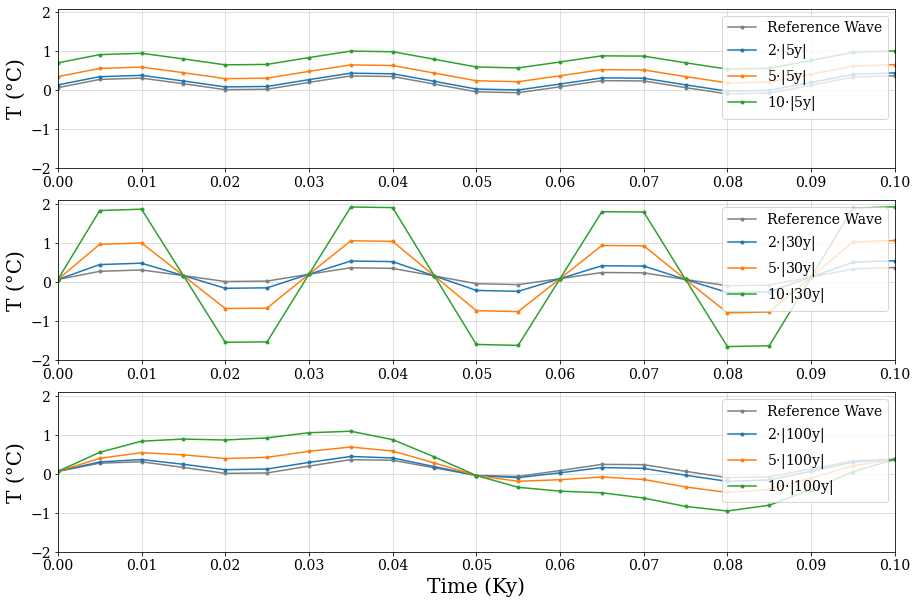

In [134]:
fig, (ax1, ax2,ax3) = plt.subplots(3,figsize=(15, 10))
ax1.plot(t,T,'.-',color='grey',label='Reference Wave')
ax1.plot(a1,A1,'.-',label='2'+r'$\cdot$|5y|')
ax1.plot(a2,A2,'.-',label='5'+r'$\cdot$|5y|')
ax1.plot(a3,A3,'.-',label='10'+r'$\cdot$|5y|')
#ax1.set_xlabel('Time (Ky)\n(A)', fontsize = 20.0)
ax1.set_ylabel('T (°C)', fontsize = 20.0)
ax1.set_xticks([0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1])
ax1.grid(alpha=0.5)
ax1.set(xlim=[0,0.1],ylim=[-2,2.1])
ax1.legend(loc=1)

ax2.plot(t,T,'.-',color='grey',label='Reference Wave')
ax2.plot(b1,B1,'.-',label='2'+r'$\cdot$|30y|')
ax2.plot(b2,B2,'.-',label='5'+r'$\cdot$|30y|')
ax2.plot(b3,B3,'.-',label='10'+r'$\cdot$|30y|')
#ax2.set_xlabel('Time (Ky)\n(A)', fontsize = 20.0)
ax2.set_ylabel('T (°C)', fontsize = 20.0)
ax2.set_xticks([0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1])
ax2.grid(alpha=0.5)
ax2.set(xlim=[0,0.1],ylim=[-2,2.1])
ax2.legend(loc=1)

ax3.plot(t,T,'.-',color='grey',label='Reference Wave')
ax3.plot(c1,C1,'.-',label='2'+r'$\cdot$|100y|')
ax3.plot(c2,C2,'.-',label='5'+r'$\cdot$|100y|')
ax3.plot(c3,C3,'.-',label='10'+r'$\cdot$|100y|')
ax3.set_xlabel('Time (Ky)', fontsize = 20.0)
ax3.set_ylabel('T (°C)', fontsize = 20.0)
ax3.set_xticks([0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1])
ax3.grid(alpha=0.5)
ax3.set(xlim=[0,0.1],ylim=[-2,2.1])
ax3.legend(loc=1)

#plt.savefig('13-SinteticA2-8-amplitude0.pdf',bbox_inches='tight')
#plt.savefig('13-SinteticA2-8-amplitude0.jpg',bbox_inches='tight')

plt.show()

In [9]:
[delta_t_amplitudA1,hs_amplitudA1,time_amplitudA1,amp_amplitudA1,app_amplitudA1,low_amplitudA1]=Haar(a1,A1)
[delta_t_amplitudA2,hs_amplitudA2,time_amplitudA2,amp_amplitudA2,app_amplitudA2,low_amplitudA2]=Haar(a2,A2)
[delta_t_amplitudA3,hs_amplitudA3,time_amplitudA3,amp_amplitudA3,app_amplitudA3,low_amplitudA3]=Haar(a3,A3)

t samples: 3472
deltas_t steps: from 1 to 1736
epsilons steps: 1736


<ipython-input-2-7d6b804121ce>:28: RuntimeWarning: invalid value encountered in true_divide
  int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
<ipython-input-2-7d6b804121ce>:27: RuntimeWarning: invalid value encountered in true_divide
  int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])


861930  fluctuaciones eliminadas ( 28.633407801742393 %)
Min t:  -2.0000000000000093   Max t:  2.258876629372134 rango_int:  0.05010443093378991
t samples: 3472
deltas_t steps: from 1 to 1736
epsilons steps: 1736


<ipython-input-2-7d6b804121ce>:28: RuntimeWarning: invalid value encountered in true_divide
  int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
<ipython-input-2-7d6b804121ce>:27: RuntimeWarning: invalid value encountered in true_divide
  int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])


861930  fluctuaciones eliminadas ( 28.633407801742393 %)
Min t:  -2.0000000000000093   Max t:  2.258876629372134 rango_int:  0.05010443093378991
t samples: 3472
deltas_t steps: from 1 to 1736
epsilons steps: 1736


<ipython-input-2-7d6b804121ce>:28: RuntimeWarning: invalid value encountered in true_divide
  int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
<ipython-input-2-7d6b804121ce>:27: RuntimeWarning: invalid value encountered in true_divide
  int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])


861930  fluctuaciones eliminadas ( 28.633407801742393 %)
Min t:  -2.0000000000000093   Max t:  2.258876629372134 rango_int:  0.05010443093378991


In [10]:
[delta_t_amplitudB1,hs_amplitudB1,time_amplitudB1,amp_amplitudB1,app_amplitudB1,low_amplitudB1]=Haar(b1,B1)
[delta_t_amplitudB2,hs_amplitudB2,time_amplitudB2,amp_amplitudB2,app_amplitudB2,low_amplitudB2]=Haar(b2,B2)
[delta_t_amplitudB3,hs_amplitudB3,time_amplitudB3,amp_amplitudB3,app_amplitudB3,low_amplitudB3]=Haar(b3,B3)

t samples: 3472
deltas_t steps: from 1 to 1736
epsilons steps: 1736


<ipython-input-2-7d6b804121ce>:28: RuntimeWarning: invalid value encountered in true_divide
  int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
<ipython-input-2-7d6b804121ce>:27: RuntimeWarning: invalid value encountered in true_divide
  int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])


861930  fluctuaciones eliminadas ( 28.633407801742393 %)
Min t:  -2.0000000000000093   Max t:  2.258876629372134 rango_int:  0.05010443093378991
t samples: 3472
deltas_t steps: from 1 to 1736
epsilons steps: 1736


<ipython-input-2-7d6b804121ce>:28: RuntimeWarning: invalid value encountered in true_divide
  int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
<ipython-input-2-7d6b804121ce>:27: RuntimeWarning: invalid value encountered in true_divide
  int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])


861930  fluctuaciones eliminadas ( 28.633407801742393 %)
Min t:  -2.0000000000000093   Max t:  2.258876629372134 rango_int:  0.05010443093378991
t samples: 3472
deltas_t steps: from 1 to 1736
epsilons steps: 1736


<ipython-input-2-7d6b804121ce>:28: RuntimeWarning: invalid value encountered in true_divide
  int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
<ipython-input-2-7d6b804121ce>:27: RuntimeWarning: invalid value encountered in true_divide
  int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])


861930  fluctuaciones eliminadas ( 28.633407801742393 %)
Min t:  -2.0000000000000093   Max t:  2.258876629372134 rango_int:  0.05010443093378991


In [11]:
[delta_t_amplitudC1,hs_amplitudC1,time_amplitudC1,amp_amplitudC1,app_amplitudC1,low_amplitudC1]=Haar(c1,C1)
[delta_t_amplitudC2,hs_amplitudC2,time_amplitudC2,amp_amplitudC2,app_amplitudC2,low_amplitudC2]=Haar(c2,C2)
[delta_t_amplitudC3,hs_amplitudC3,time_amplitudC3,amp_amplitudC3,app_amplitudC3,low_amplitudC3]=Haar(c3,C3)

t samples: 3472
deltas_t steps: from 1 to 1736
epsilons steps: 1736


<ipython-input-2-7d6b804121ce>:28: RuntimeWarning: invalid value encountered in true_divide
  int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
<ipython-input-2-7d6b804121ce>:27: RuntimeWarning: invalid value encountered in true_divide
  int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])


861930  fluctuaciones eliminadas ( 28.633407801742393 %)
Min t:  -2.0000000000000093   Max t:  2.258876629372134 rango_int:  0.05010443093378991
t samples: 3472
deltas_t steps: from 1 to 1736
epsilons steps: 1736


<ipython-input-2-7d6b804121ce>:28: RuntimeWarning: invalid value encountered in true_divide
  int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
<ipython-input-2-7d6b804121ce>:27: RuntimeWarning: invalid value encountered in true_divide
  int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])


861930  fluctuaciones eliminadas ( 28.633407801742393 %)
Min t:  -2.0000000000000093   Max t:  2.258876629372134 rango_int:  0.05010443093378991
t samples: 3472
deltas_t steps: from 1 to 1736
epsilons steps: 1736


<ipython-input-2-7d6b804121ce>:28: RuntimeWarning: invalid value encountered in true_divide
  int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
<ipython-input-2-7d6b804121ce>:27: RuntimeWarning: invalid value encountered in true_divide
  int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])


861930  fluctuaciones eliminadas ( 28.633407801742393 %)
Min t:  -2.0000000000000093   Max t:  2.258876629372134 rango_int:  0.05010443093378991


In [70]:
[delta_t_amplitudZ1,hs_amplitudZ1,time_amplitudZ1,amp_amplitudZ1,app_amplitudZ1,low_amplitudZ1]=Haar(z1,Z1)

t samples: 3472
deltas_t steps: from 1 to 1736
epsilons steps: 1736


<ipython-input-2-7d6b804121ce>:28: RuntimeWarning: invalid value encountered in true_divide
  int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
<ipython-input-2-7d6b804121ce>:27: RuntimeWarning: invalid value encountered in true_divide
  int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])


861930  fluctuaciones eliminadas ( 28.633407801742393 %)
Min t:  -2.0000000000000093   Max t:  2.258876629372134 rango_int:  0.05010443093378991


In [66]:
#[delta_t_amplitudD1,hs_amplitudD1,time_amplitudD1,amp_amplitudD1,app_amplitudD1,low_amplitudD1]=Haar(d1,D1)
#[delta_t_amplitudD2,hs_amplitudD2,time_amplitudD2,amp_amplitudD2,app_amplitudD2,low_amplitudD2]=Haar(d2,D2)
#[delta_t_amplitudD3,hs_amplitudD3,time_amplitudD3,amp_amplitudD3,app_amplitudD3,low_amplitudD3]=Haar(d3,D3)

t samples: 3472
deltas_t steps: from 1 to 1736
epsilons steps: 1736


<ipython-input-2-f4857a5efce7>:28: RuntimeWarning: invalid value encountered in true_divide
  int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
<ipython-input-2-f4857a5efce7>:27: RuntimeWarning: invalid value encountered in true_divide
  int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])


861930  fluctuaciones eliminadas ( 28.633407801742393 %)
Min t:  -2.0000000000000093   Max t:  2.258876629372134
t samples: 3472
deltas_t steps: from 1 to 1736
epsilons steps: 1736


<ipython-input-2-f4857a5efce7>:28: RuntimeWarning: invalid value encountered in true_divide
  int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
<ipython-input-2-f4857a5efce7>:27: RuntimeWarning: invalid value encountered in true_divide
  int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])


861930  fluctuaciones eliminadas ( 28.633407801742393 %)
Min t:  -2.0000000000000093   Max t:  2.258876629372134
t samples: 3472
deltas_t steps: from 1 to 1736
epsilons steps: 1736


<ipython-input-2-f4857a5efce7>:28: RuntimeWarning: invalid value encountered in true_divide
  int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
<ipython-input-2-f4857a5efce7>:27: RuntimeWarning: invalid value encountered in true_divide
  int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])


861930  fluctuaciones eliminadas ( 28.633407801742393 %)
Min t:  -2.0000000000000093   Max t:  2.258876629372134


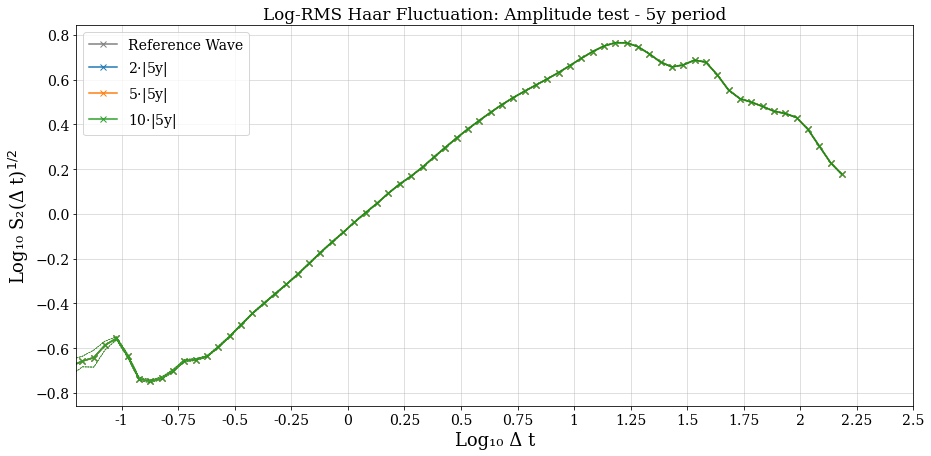

In [14]:
plt.subplots(figsize=(15, 7))
plt.plot(time,np.log10(amp),'x-',color='grey',label='Reference Wave')
plt.plot(time,np.log10(app),'--',color='black',linewidth=0.5)
plt.plot(time,np.log10(low),'--',color='black',linewidth=0.5)

plt.plot(time_amplitudA1,np.log10(amp_amplitudA1),'x-',label='2'+r'$\cdot$|5y|')
plt.plot(time_amplitudA1,np.log10(app_amplitudA1),'--',color='c',linewidth=0.5)
plt.plot(time_amplitudA1,np.log10(low_amplitudA1),'--',color='c',linewidth=0.5)

plt.plot(time_amplitudA2,np.log10(amp_amplitudA2),'x-',label='5'+r'$\cdot$|5y|')
plt.plot(time_amplitudA2,np.log10(app_amplitudA2),'--',color='y',linewidth=0.5)
plt.plot(time_amplitudA2,np.log10(low_amplitudA2),'--',color='y',linewidth=0.5)

plt.plot(time_amplitudA3,np.log10(amp_amplitudA3),'x-',label='10'+r'$\cdot$|5y|')
plt.plot(time_amplitudA3,np.log10(app_amplitudA3),'--',color='g',linewidth=0.5)
plt.plot(time_amplitudA3,np.log10(low_amplitudA3),'--',color='g',linewidth=0.5)


x_ticks  = [-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5]
x_labels = [-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5]
plt.xticks(ticks=x_ticks, labels=x_labels)


plt.title('Log-RMS Haar Fluctuation: Amplitude test - 5y period')
plt.xlabel('Log\u2081\u2080 \u0394 t',fontsize=18);plt.ylabel('Log\u2081\u2080 S\u2082(\u0394 t)'+r'$^{1/2}$',fontsize=18)
plt.xlim([-1.2,2.5]);plt.legend()
plt.grid(alpha=0.5)



#plt.savefig('13-SinteticA2-8-amplitude1.pdf',bbox_inches='tight')
#plt.savefig('13-SinteticA2-8-amplitude1.jpg',bbox_inches='tight')
plt.show()

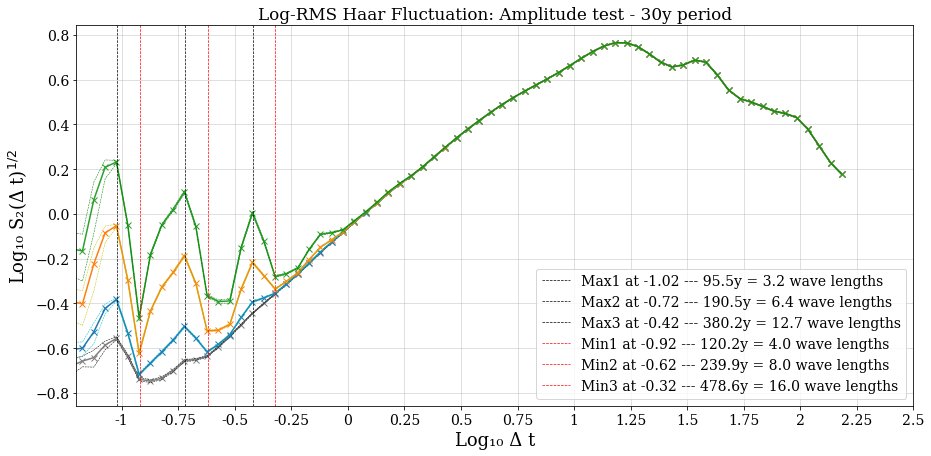

In [43]:
plt.subplots(figsize=(15, 7))
plt.plot(time,np.log10(amp),'x-',color='grey')#,label='Reference Wave')
plt.plot(time,np.log10(app),'--',color='black',linewidth=0.5)
plt.plot(time,np.log10(low),'--',color='black',linewidth=0.5)

plt.plot(time_amplitudB1,np.log10(amp_amplitudB1),'x-')#,label='2'+r'$\cdot$|30y|')
plt.plot(time_amplitudB1,np.log10(app_amplitudB1),'--',color='c',linewidth=0.5)
plt.plot(time_amplitudB1,np.log10(low_amplitudB1),'--',color='c',linewidth=0.5)

plt.plot(time_amplitudB2,np.log10(amp_amplitudB2),'x-')#,label='5'+r'$\cdot$|30y|')
plt.plot(time_amplitudB2,np.log10(app_amplitudB2),'--',color='y',linewidth=0.5)
plt.plot(time_amplitudB2,np.log10(low_amplitudB2),'--',color='y',linewidth=0.5)

plt.plot(time_amplitudB3,np.log10(amp_amplitudB3),'x-')#,label='10'+r'$\cdot$|30y|')
plt.plot(time_amplitudB3,np.log10(app_amplitudB3),'--',color='g',linewidth=0.5)
plt.plot(time_amplitudB3,np.log10(low_amplitudB3),'--',color='g',linewidth=0.5)


x_ticks  = [-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5]
x_labels = [-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5]
plt.xticks(ticks=x_ticks, labels=x_labels)

plt.title('Log-RMS Haar Fluctuation: Amplitude test - 30y period')
plt.xlabel('Log\u2081\u2080 \u0394 t',fontsize=18);plt.ylabel('Log\u2081\u2080 S\u2082(\u0394 t)'+r'$^{1/2}$',fontsize=18)
plt.xlim([-1.2,2.5]);
plt.grid(alpha=0.5)

p1=np.round(-1.0229636,2)
v1=np.round(-0.92275473,2)
p2=np.round(-0.72233701,2)
v2=np.round(-0.62212815,2)
p3=np.round(-0.42171043,2)
v3=np.round(-0.32150156,2)

a1='Max1 at '+str(p1)+' --- '+str(np.round(10**p1*1000,1))+'y = '+str(np.round(10**p1*1000/30,1))+' wave lengths'
a2='Min1 at '+str(v1)+' --- '+str(np.round(10**v1*1000,1))+'y = '+str(np.round(10**v1*1000/30,1))+' wave lengths'
a3='Max2 at '+str(p2)+' --- '+str(np.round(10**p2*1000,1))+'y = '+str(np.round(10**p2*1000/30,1))+' wave lengths'
a4='Min2 at '+str(v2)+' --- '+str(np.round(10**v2*1000,1))+'y = '+str(np.round(10**v2*1000/30,1))+' wave lengths'
a5='Max3 at '+str(p3)+' --- '+str(np.round(10**p3*1000,1))+'y = '+str(np.round(10**p3*1000/30,1))+' wave lengths'
a6='Min3 at '+str(v3)+' --- '+str(np.round(10**v3*1000,1))+'y = '+str(np.round(10**v3*1000/30,1))+' wave lengths'

plt.axvline(x=p1,linestyle='--',linewidth=0.7,color='black',label=a1)
plt.axvline(x=p2,linestyle='--',linewidth=0.7,color='black',label=a3)
plt.axvline(x=p3,linestyle='--',linewidth=0.7,color='black',label=a5)
plt.axvline(x=v1,linestyle='--',linewidth=0.7,color='r',label=a2)
plt.axvline(x=v2,linestyle='--',linewidth=0.7,color='r',label=a4)
plt.axvline(x=v3,linestyle='--',linewidth=0.7,color='r',label=a6)
#plt.axvline(x=-0.12,linestyle='--',linewidth=0.7,color='black',label='') 

plt.legend()
#plt.savefig('13-SinteticA2-8-amplitude2.pdf',bbox_inches='tight')
#plt.savefig('13-SinteticA2-8-amplitude2 with vertical lines.jpg',bbox_inches='tight')
plt.show()

In [39]:
a1='Peak1 at '+str(p1)+' --- '+str(np.round(10**p1*1000,1))+'y = '+str(np.round(10**p1*1000/30,1))+' wave lengths'
a2='Valley1 at '+str(v1)+' --- '+str(np.round(10**v1*1000,1))+'y = '+str(np.round(10**v1*1000/30,1))+' wave lengths'
a3='Peak2 at '+str(p2)+' --- '+str(np.round(10**p2*1000,1))+'y = '+str(np.round(10**p2*1000/30,1))+' wave lengths'
a4='Valley2 at '+str(v2)+' --- '+str(np.round(10**v2*1000,1))+'y = '+str(np.round(10**v2*1000/30,1))+' wave lengths'
a5='Peak3 at '+str(p3)+' --- '+str(np.round(10**p3*1000,1))+'y = '+str(np.round(10**p3*1000/30,1))+' wave lengths'
a6='Valley3 at '+str(v3)+' --- '+str(np.round(10**v3*1000,1))+'y = '+str(np.round(10**v3*1000/30,1))+' wave lengths'

In [16]:
p1=np.round(-1.0229636,2)
v1=np.round(-0.92275473,2)
p2=np.round(-0.72233701,2)
v2=np.round(-0.62212815,2)
p3=np.round(-0.42171043,2)
v3=np.round(-0.32150156,2)

print(p1)
print(v1)
print(p2)
print(v2)
print(p3)
print(v3)

-1.02
-0.92
-0.72
-0.62
-0.42
-0.32


In [337]:
print(10**-1.0229636, '1st peak at ',np.round(10**-1.0229636*1000),' years -> ',10**-1.0229636*1000/30,'wls = integrales de ',np.round(10**-1.0229636*1000/2))
print(10**-0.92275473, '1st min at ',np.round(10**-0.92275473*1000),' years -> ',10**-0.92275473*1000/30,'wls = integrales de ',np.round(10**-0.92275473*1000/2))
print(10**-0.72233701, '2nd peak at ',np.round(10**-0.72233701*1000),' years -> ',10**-0.72233701*1000/30,'wls = integrales de ',np.round(10**-0.72233701*1000/2))
print(10**-0.62212815, '2nd "min" at ',np.round(10**-0.62212815*1000),' years -> ',10**-0.62212815*1000/30,'wls = integrales de ',np.round(10**-0.62212815*1000/2))
print(10**-0.42171043, '3rd peak at ',np.round(10**-0.42171043*1000),' years -> ',10**-0.42171043*1000/30,'wls = integrales de ',np.round(10**-0.42171043*1000/2))
print(10**-0.32150156, '3rd min at ',np.round(10**-0.32150156*1000),' years -> ',10**-0.32150156*1000/30,'wls = integrales de ',np.round(10**-0.32150156*1000/2))

time

0.09484979574696614 1st peak at  95.0  years ->  3.1616598582322046 wls = integrales de  47.0
0.11946626057169106 1st min at  119.0  years ->  3.9822086857230357 wls = integrales de  60.0
0.18952346593322 2nd peak at  190.0  years ->  6.317448864440666 wls = integrales de  95.0
0.23871068003864215 2nd "min" at  239.0  years ->  7.957022667954738 wls = integrales de  119.0
0.37869499907089105 3rd peak at  379.0  years ->  12.62316663569637 wls = integrales de  189.0
0.47697810079518754 3rd min at  477.0  years ->  15.899270026506251 wls = integrales de  238.0


<module 'time' (built-in)>

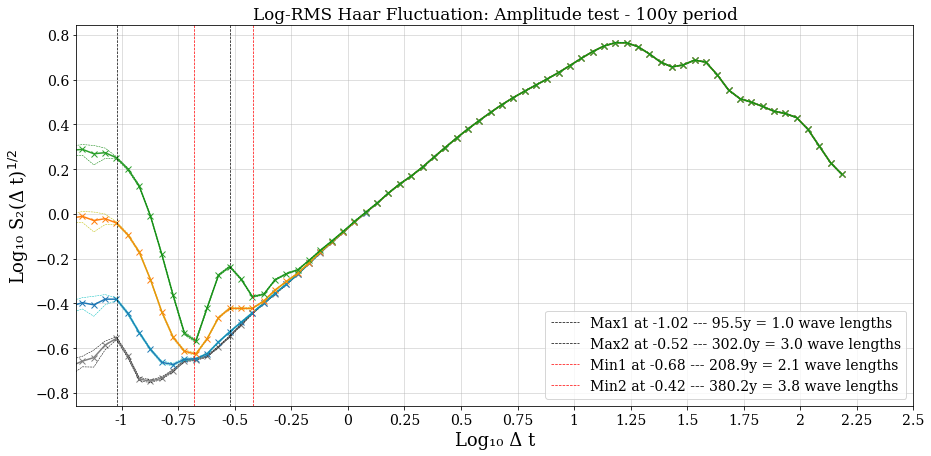

In [67]:
plt.subplots(figsize=(15, 7))
plt.plot(time,np.log10(amp),'x-',color='grey')#,label='Reference Wave')
plt.plot(time,np.log10(app),'--',color='black',linewidth=0.5)
plt.plot(time,np.log10(low),'--',color='black',linewidth=0.5)

plt.plot(time_amplitudC1,np.log10(amp_amplitudC1),'x-')#,label='2'+r'$\cdot$|100y|')
plt.plot(time_amplitudC1,np.log10(app_amplitudC1),'--',color='c',linewidth=0.5)
plt.plot(time_amplitudC1,np.log10(low_amplitudC1),'--',color='c',linewidth=0.5)

plt.plot(time_amplitudC2,np.log10(amp_amplitudC2),'x-')#,label='5'+r'$\cdot$|100y|')
plt.plot(time_amplitudC2,np.log10(app_amplitudC2),'--',color='y',linewidth=0.5)
plt.plot(time_amplitudC2,np.log10(low_amplitudC2),'--',color='y',linewidth=0.5)

plt.plot(time_amplitudC3,np.log10(amp_amplitudC3),'x-')#,label='10'+r'$\cdot$|100y|')
plt.plot(time_amplitudC3,np.log10(app_amplitudC3),'--',color='g',linewidth=0.5)
plt.plot(time_amplitudC3,np.log10(low_amplitudC3),'--',color='g',linewidth=0.5)


x_ticks  = [-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5]
x_labels = [-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5]
plt.xticks(ticks=x_ticks, labels=x_labels)


plt.title('Log-RMS Haar Fluctuation: Amplitude test - 100y period')
plt.xlabel('Log\u2081\u2080 \u0394 t',fontsize=18);plt.ylabel('Log\u2081\u2080 S\u2082(\u0394 t)'+r'$^{1/2}$',fontsize=18)
plt.xlim([-1.2,2.5]);
plt.grid(alpha=0.5)

p12=np.round(np.log10(95/1000),2)
v12=np.round(np.log10(210/1000),2)
p22=np.round(np.log10(300/1000),2)
v22=np.round(np.log10(380/1000),2)
#p32=np.round(-0.42171043,2)
#v32=np.round(-0.32150156,2)

b1='Max1 at '+str(p12)+' --- '+str(np.round(10**p12*1000,1))+'y = '+str(np.round(10**p12*1000/100,1))+' wave lengths'
b2='Min1 at '+str(v12)+' --- '+str(np.round(10**v12*1000,1))+'y = '+str(np.round(10**v12*1000/100,1))+' wave lengths'
b3='Max2 at '+str(p22)+' --- '+str(np.round(10**p22*1000,1))+'y = '+str(np.round(10**p22*1000/100,1))+' wave lengths'
b4='Min2 at '+str(v22)+' --- '+str(np.round(10**v22*1000,1))+'y = '+str(np.round(10**v22*1000/100,1))+' wave lengths'
#b5='Max3 at '+str(p32)+' --- '+str(np.round(10**p32*1000,1))+'y = '+str(np.round(10**p32*1000/100,1))+' wave lengths'
#b6='Min3 at '+str(v32)+' --- '+str(np.round(10**v32*1000,1))+'y = '+str(np.round(10**v32*1000/100,1))+' wave lengths'

plt.axvline(x=p12,linestyle='--',linewidth=0.7,color='black',label=b1)
plt.axvline(x=p22,linestyle='--',linewidth=0.7,color='black',label=b3)
plt.axvline(x=v12,linestyle='--',linewidth=0.7,color='r',label=b2)
plt.axvline(x=v22,linestyle='--',linewidth=0.7,color='r',label=b4)

plt.legend()

#plt.savefig('13-SinteticA2-8-amplitude3.pdf',bbox_inches='tight')
#plt.savefig('13-SinteticA2-8-amplitude3 with vertical lines.jpg',bbox_inches='tight')
plt.show()

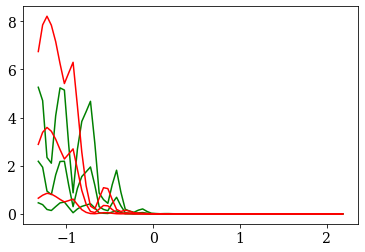

In [85]:
plt.plot(time,(amp_amplitudB1-amp)/amp,color='g')
plt.plot(time,(amp_amplitudB2-amp)/amp,color='g')
plt.plot(time,(amp_amplitudB3-amp)/amp,color='g')

plt.plot(time,(amp_amplitudC1-amp)/amp,color='r')
plt.plot(time,(amp_amplitudC2-amp)/amp,color='r')
plt.plot(time,(amp_amplitudC3-amp)/amp,color='r')
plt.show()

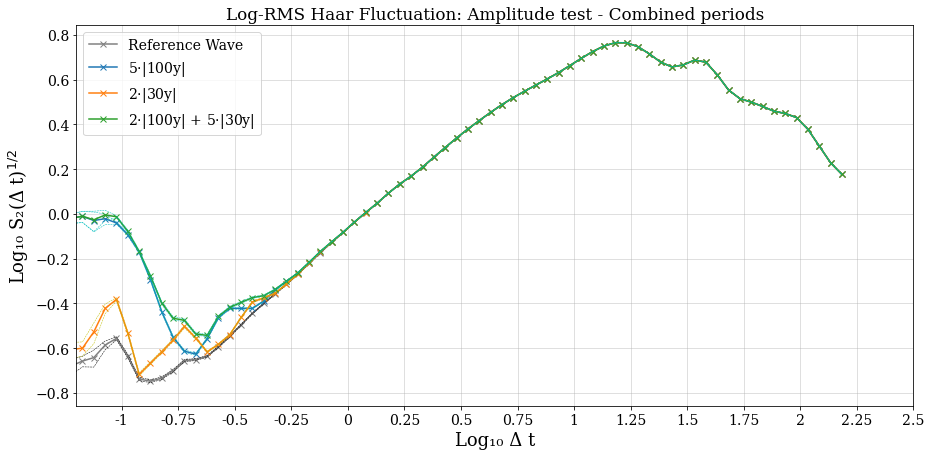

In [77]:
plt.subplots(figsize=(15, 7))
plt.plot(time,np.log10(amp),'x-',color='grey',label='Reference Wave')
plt.plot(time,np.log10(app),'--',color='black',linewidth=0.5)
plt.plot(time,np.log10(low),'--',color='black',linewidth=0.5)

plt.plot(time_amplitudC2,np.log10(amp_amplitudC2),'x-',label='5'+r'$\cdot$|100y|')
plt.plot(time_amplitudC2,np.log10(app_amplitudC2),'--',color='c',linewidth=0.5)
plt.plot(time_amplitudC2,np.log10(low_amplitudC2),'--',color='c',linewidth=0.5)

plt.plot(time_amplitudB1,np.log10(amp_amplitudB1),'x-',label='2'+r'$\cdot$|30y|')
plt.plot(time_amplitudB1,np.log10(app_amplitudB1),'--',color='y',linewidth=0.5)
plt.plot(time_amplitudB1,np.log10(low_amplitudB1),'--',color='y',linewidth=0.5)


plt.plot(time_amplitudZ1,np.log10(amp_amplitudZ1),'x-',label='2'+r'$\cdot$|100y| + 5'+r'$\cdot$|30y|')
plt.plot(time_amplitudZ1,np.log10(app_amplitudZ1),'--',color='c',linewidth=0.5)
plt.plot(time_amplitudZ1,np.log10(low_amplitudZ1),'--',color='c',linewidth=0.5)


x_ticks  = [-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5]
x_labels = [-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5]
plt.xticks(ticks=x_ticks, labels=x_labels)


plt.title('Log-RMS Haar Fluctuation: Amplitude test - Combined periods')
plt.xlabel('Log\u2081\u2080 \u0394 t',fontsize=18);plt.ylabel('Log\u2081\u2080 S\u2082(\u0394 t)'+r'$^{1/2}$',fontsize=18)
plt.xlim([-1.2,2.5]);
plt.grid(alpha=0.5)
plt.legend()

#plt.savefig('13-SinteticA2-8-amplitude3.pdf',bbox_inches='tight')
#plt.savefig('13-SinteticA2-8-amplitude3 Combineed.jpg',bbox_inches='tight')
plt.show()

In [370]:
print(np.log10(16))
print()

1.2041199826559248
peak máximo a  0.027659781790626007  wls->1/36 wls


In [14]:
#######################################################
### VEO EL MISMO EFECTO, PERO EN LAS LOW FREQUENCIES ##
#######################################################

In [191]:
def wave_amps2(res1,res2,res3,res4,res5,res6,name,amp4,amp5,amp6):    
    kyears1=2; 
    kyears2=10;
    kyears3=20;
    kyears4=50;
    kyears5=100;
    kyears6=200;    
    
    t11 = np.arange(0, kyears1+res1, res1); t21 = np.arange(0, kyears1+res1, res1); t31 = np.arange(0, kyears1+res1, res1);
    x11 = 0.1*np.sin(2000*np.pi*t11/5+np.pi/4); x21 = 0.2*np.sin(2000*np.pi*t21/30); x31 = 0.1*np.sin(2000*np.pi*t31/100);
    t41 = np.arange(0, kyears1+res1, res1); t51 = np.arange(0, kyears1+res1, res1); t61 = np.arange(0, kyears1+res1, res1);
    x41 = amp4*np.sin(2*np.pi*t41/20); x51 = amp5*np.sin(2*np.pi*t51/40); x61 = amp6*np.sin(2*np.pi*t61/100); 
    T1=x11+x21+x31+x41+x51+x61

    t12 = np.arange(kyears1, kyears2+res2, res2); t22 = np.arange(kyears1, kyears2+res2, res2); t32 = np.arange(kyears1, kyears2+res2, res2);
    x12 = 0.1*np.sin(2000*np.pi*t12/5+np.pi/4); x22 = 0.2*np.sin(2000*np.pi*t22/30); x32 = 0.1*np.sin(2000*np.pi*t32/100);
    t42 = np.arange(kyears1, kyears2+res2, res2); t52 = np.arange(kyears1, kyears2+res2, res2); t62 = np.arange(kyears1, kyears2+res2, res2);
    x42 = amp4*np.sin(2*np.pi*t42/20); x52 = amp5*np.sin(2*np.pi*t52/40); x62 = amp6*np.sin(2*np.pi*t62/100); 
    T2=x12+x22+x32+x42+x52+x62

    t13 = np.arange(kyears2, kyears3+res3, res3); t23 = np.arange(kyears2, kyears3+res3, res3); t33 = np.arange(kyears2, kyears3+res3, res3);
    x13 = 0.1*np.sin(2000*np.pi*t13/5+np.pi/4); x23 = 0.2*np.sin(2000*np.pi*t23/30); x33 = 0.1*np.sin(2000*np.pi*t33/100); 
    t43 = np.arange(kyears2, kyears3+res3, res3); t53 = np.arange(kyears2, kyears3+res3, res3); t63 = np.arange(kyears2, kyears3+res3, res3);
    x43 = amp4*np.sin(2*np.pi*t43/20); x53 = amp5*np.sin(2*np.pi*t53/40); x63 = amp6*np.sin(2*np.pi*t63/100); 
    T3=x13+x23+x33+x43+x53+x63

    t14 = np.arange(kyears3, kyears4+res4, res4); t24 = np.arange(kyears3, kyears4+res4, res4); t34 = np.arange(kyears3, kyears4+res4, res4);
    x14 = 0.1*np.sin(2000*np.pi*t14/5+np.pi/4); x24 = 0.2*np.sin(2000*np.pi*t24/30); x34 = 0.1*np.sin(2000*np.pi*t34/100);
    t44 = np.arange(kyears3, kyears4+res4, res4); t54 = np.arange(kyears3, kyears4+res4, res4); t64 = np.arange(kyears3, kyears4+res4, res4);
    x44 = amp4*np.sin(2*np.pi*t44/20); x54 = amp5*np.sin(2*np.pi*t54/40); x64 = amp6*np.sin(2*np.pi*t64/100); 
    T4=x14+x24+x34+x44+x54+x64

    t15 = np.arange(kyears4, kyears5+res5, res5); t25 = np.arange(kyears4, kyears5+res5, res5); t35 = np.arange(kyears4, kyears5+res5, res5);
    x15 = 0.1*np.sin(2000*np.pi*t15/5+np.pi/4); x25 = 0.2*np.sin(2000*np.pi*t25/30); x35 = 0.1*np.sin(2000*np.pi*t35/100); 
    t45 = np.arange(kyears4, kyears5+res5, res5); t55 = np.arange(kyears4, kyears5+res5, res5); t65 = np.arange(kyears4, kyears5+res5, res5);
    x45 = amp4*np.sin(2*np.pi*t45/20); x55 = amp5*np.sin(2*np.pi*t55/40); x65 = amp6*np.sin(2*np.pi*t65/100); 
    T5=x15+x25+x35+x45+x55+x65

    t16 = np.arange(kyears5, kyears6+res6, res6); t26 = np.arange(kyears5, kyears6+res6, res6); t36 = np.arange(kyears5, kyears6+res6, res6);
    x16 = 0.1*np.sin(2000*np.pi*t16/5+np.pi/4); x26 = 0.2*np.sin(2000*np.pi*t26/30); x36 = 0.1*np.sin(2000*np.pi*t36/100);
    t46 = np.arange(kyears5, kyears6+res6, res6); t56 = np.arange(kyears5, kyears6+res6, res6); t66 = np.arange(kyears5, kyears6+res6, res6);
    x46 = amp4*np.sin(2*np.pi*t46/20); x56 = amp5*np.sin(2*np.pi*t56/40); x66 = amp6*np.sin(2*np.pi*t66/100); 
    T6=x16+x26+x36+x46+x56+x66

    T=np.concatenate((T1, T2, T3, T4, T5, T6)); t=np.concatenate((t11, t12, t13, t14, t15, t16)) 
    
    return t,T

In [192]:
[d1,D1]=wave_amps2(0.005,0.01,0.015,0.05,0.1,0.2,'Amplitud D1',3*2,2,1.5) 
[d2,D2]=wave_amps2(0.005,0.01,0.015,0.05,0.1,0.2,'Amplitud D2',3*5,2,1.5) 
[d3,D3]=wave_amps2(0.005,0.01,0.015,0.05,0.1,0.2,'Amplitud D3',3*10,2,1.5)

[e1,E1]=wave_amps2(0.005,0.01,0.015,0.05,0.1,0.2,'Amplitud E1',3,2*2,1.5) 
[e2,E2]=wave_amps2(0.005,0.01,0.015,0.05,0.1,0.2,'Amplitud E2',3,2*5,1.5) 
[e3,E3]=wave_amps2(0.005,0.01,0.015,0.05,0.1,0.2,'Amplitud E3',3,2*10,1.5)

[f1,F1]=wave_amps2(0.005,0.01,0.015,0.05,0.1,0.2,'Amplitud F1',3,2,1.5*2) 
[f2,F2]=wave_amps2(0.005,0.01,0.015,0.05,0.1,0.2,'Amplitud F2',3,2,1.5*5) 
[f3,F3]=wave_amps2(0.005,0.01,0.015,0.05,0.1,0.2,'Amplitud F3',3,2,1.5*10)

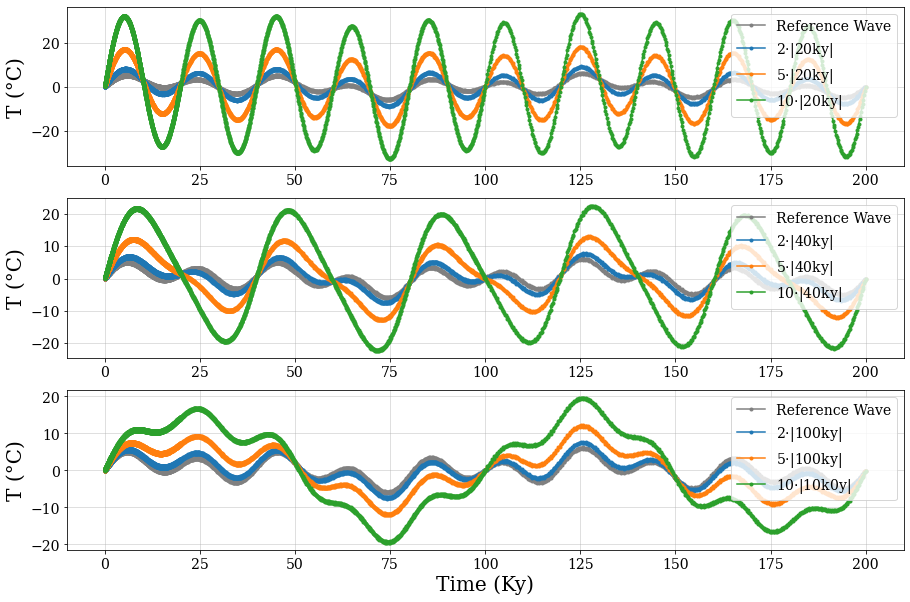

In [198]:
fig, (ax1, ax2,ax3) = plt.subplots(3,figsize=(15, 10))
ax1.plot(t,T,'.-',color='grey',label='Reference Wave')
ax1.plot(d1,D1,'.-',label='2'+r'$\cdot$|20ky|')
ax1.plot(d2,D2,'.-',label='5'+r'$\cdot$|20ky|')
ax1.plot(d3,D3,'.-',label='10'+r'$\cdot$|20ky|')
#ax1.set_xlabel('Time (Ky)\n(A)', fontsize = 20.0)
ax1.set_ylabel('T (°C)', fontsize = 20.0)
#ax1.set_xticks([0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1])
ax1.grid(alpha=0.5)
#ax1.set(xlim=[0,0.1],ylim=[-2,2.1])
ax1.legend(loc=1)

ax2.plot(t,T,'.-',color='grey',label='Reference Wave')
ax2.plot(e1,E1,'.-',label='2'+r'$\cdot$|40ky|')
ax2.plot(e2,E2,'.-',label='5'+r'$\cdot$|40ky|')
ax2.plot(e3,E3,'.-',label='10'+r'$\cdot$|40ky|')
#ax2.set_xlabel('Time (Ky)\n(A)', fontsize = 20.0)
ax2.set_ylabel('T (°C)', fontsize = 20.0)
#ax2.set_xticks([0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1])
ax2.grid(alpha=0.5)
#ax2.set(xlim=[0,0.1],ylim=[-2,2.1])
ax2.legend(loc=1)

ax3.plot(t,T,'.-',color='grey',label='Reference Wave')
ax3.plot(f1,F1,'.-',label='2'+r'$\cdot$|100ky|')
ax3.plot(f2,F2,'.-',label='5'+r'$\cdot$|100ky|')
ax3.plot(f3,F3,'.-',label='10'+r'$\cdot$|10k0y|')
ax3.set_xlabel('Time (Ky)', fontsize = 20.0)
ax3.set_ylabel('T (°C)', fontsize = 20.0)
#ax3.set_xticks([0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1])
ax3.grid(alpha=0.5)
#ax3.set(xlim=[0,0.1],ylim=[-2,2.1])
ax3.legend(loc=1)

#plt.savefig('13-SinteticA2-8-amplitude0.pdf',bbox_inches='tight')
#plt.savefig('13-SinteticA2-8-amplitude0LF.jpg',bbox_inches='tight')

plt.show()

In [204]:
[delta_t_amplitudD1,hs_amplitudD1,time_amplitudD1,amp_amplitudD1,app_amplitudD1,low_amplitudD1]=Haar(d1,D1,smooth=True)
[delta_t_amplitudD2,hs_amplitudD2,time_amplitudD2,amp_amplitudD2,app_amplitudD2,low_amplitudD2]=Haar(d2,D2,smooth=True)
[delta_t_amplitudD3,hs_amplitudD3,time_amplitudD3,amp_amplitudD3,app_amplitudD3,low_amplitudD3]=Haar(d3,D3,smooth=True)

t samples: 3472
deltas_t steps: from 1 to 1736
epsilons steps: 1736


<ipython-input-4-b432793d649f>:28: RuntimeWarning: invalid value encountered in true_divide
  int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
<ipython-input-4-b432793d649f>:27: RuntimeWarning: invalid value encountered in true_divide
  int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])


861930  fluctuaciones eliminadas ( 28.633407801742393 %)
t samples: 3472
deltas_t steps: from 1 to 1736
epsilons steps: 1736


<ipython-input-4-b432793d649f>:28: RuntimeWarning: invalid value encountered in true_divide
  int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
<ipython-input-4-b432793d649f>:27: RuntimeWarning: invalid value encountered in true_divide
  int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])


861930  fluctuaciones eliminadas ( 28.633407801742393 %)
t samples: 3472
deltas_t steps: from 1 to 1736
epsilons steps: 1736


<ipython-input-4-b432793d649f>:28: RuntimeWarning: invalid value encountered in true_divide
  int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
<ipython-input-4-b432793d649f>:27: RuntimeWarning: invalid value encountered in true_divide
  int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])


861930  fluctuaciones eliminadas ( 28.633407801742393 %)


In [205]:
[delta_t_amplitudE1,hs_amplitudE1,time_amplitudE1,amp_amplitudE1,app_amplitudE1,low_amplitudE1]=Haar(e1,E1,smooth=True)
[delta_t_amplitudE2,hs_amplitudE2,time_amplitudE2,amp_amplitudE2,app_amplitudE2,low_amplitudE2]=Haar(e2,E2,smooth=True)
[delta_t_amplitudE3,hs_amplitudE3,time_amplitudE3,amp_amplitudE3,app_amplitudE3,low_amplitudE3]=Haar(e3,E3,smooth=True)

t samples: 3472
deltas_t steps: from 1 to 1736
epsilons steps: 1736


<ipython-input-4-b432793d649f>:28: RuntimeWarning: invalid value encountered in true_divide
  int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
<ipython-input-4-b432793d649f>:27: RuntimeWarning: invalid value encountered in true_divide
  int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])


861930  fluctuaciones eliminadas ( 28.633407801742393 %)
t samples: 3472
deltas_t steps: from 1 to 1736
epsilons steps: 1736


<ipython-input-4-b432793d649f>:28: RuntimeWarning: invalid value encountered in true_divide
  int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
<ipython-input-4-b432793d649f>:27: RuntimeWarning: invalid value encountered in true_divide
  int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])


861930  fluctuaciones eliminadas ( 28.633407801742393 %)
t samples: 3472
deltas_t steps: from 1 to 1736
epsilons steps: 1736


<ipython-input-4-b432793d649f>:28: RuntimeWarning: invalid value encountered in true_divide
  int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
<ipython-input-4-b432793d649f>:27: RuntimeWarning: invalid value encountered in true_divide
  int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])


861930  fluctuaciones eliminadas ( 28.633407801742393 %)


In [206]:
[delta_t_amplitudF1,hs_amplitudF1,time_amplitudF1,amp_amplitudF1,app_amplitudF1,low_amplitudF1]=Haar(f1,F1,smooth=True)
[delta_t_amplitudF2,hs_amplitudF2,time_amplitudF2,amp_amplitudF2,app_amplitudF2,low_amplitudF2]=Haar(f2,F2,smooth=True)
[delta_t_amplitudF3,hs_amplitudF3,time_amplitudF3,amp_amplitudF3,app_amplitudF3,low_amplitudF3]=Haar(f3,F3,smooth=True)

t samples: 3472
deltas_t steps: from 1 to 1736
epsilons steps: 1736


<ipython-input-4-b432793d649f>:28: RuntimeWarning: invalid value encountered in true_divide
  int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
<ipython-input-4-b432793d649f>:27: RuntimeWarning: invalid value encountered in true_divide
  int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])


861930  fluctuaciones eliminadas ( 28.633407801742393 %)
t samples: 3472
deltas_t steps: from 1 to 1736
epsilons steps: 1736


<ipython-input-4-b432793d649f>:28: RuntimeWarning: invalid value encountered in true_divide
  int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
<ipython-input-4-b432793d649f>:27: RuntimeWarning: invalid value encountered in true_divide
  int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])


861930  fluctuaciones eliminadas ( 28.633407801742393 %)
t samples: 3472
deltas_t steps: from 1 to 1736
epsilons steps: 1736


<ipython-input-4-b432793d649f>:28: RuntimeWarning: invalid value encountered in true_divide
  int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
<ipython-input-4-b432793d649f>:27: RuntimeWarning: invalid value encountered in true_divide
  int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])


861930  fluctuaciones eliminadas ( 28.633407801742393 %)


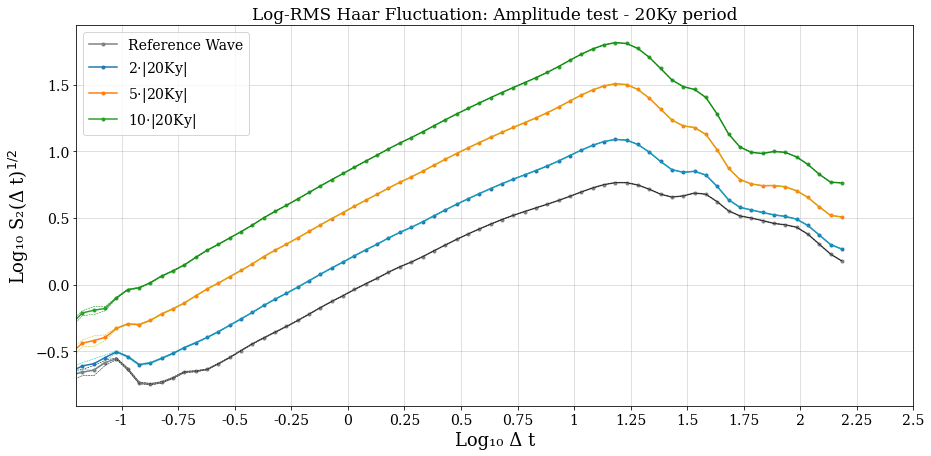

In [214]:
plt.subplots(figsize=(15, 7))
plt.plot(time,np.log10(amp),'.-',color='grey',label='Reference Wave')
plt.plot(time,np.log10(app),'--',color='black',linewidth=0.5)
plt.plot(time,np.log10(low),'--',color='black',linewidth=0.5)

plt.plot(time_amplitudD1,np.log10(amp_amplitudD1),'.-',label='2'+r'$\cdot$|20Ky|')
plt.plot(time_amplitudD1,np.log10(app_amplitudD1),'--',color='c',linewidth=0.5)
plt.plot(time_amplitudD1,np.log10(low_amplitudD1),'--',color='c',linewidth=0.5)

plt.plot(time_amplitudD2,np.log10(amp_amplitudD2),'.-',label='5'+r'$\cdot$|20Ky|')
plt.plot(time_amplitudD2,np.log10(app_amplitudD2),'--',color='y',linewidth=0.5)
plt.plot(time_amplitudD2,np.log10(low_amplitudD2),'--',color='y',linewidth=0.5)

plt.plot(time_amplitudD3,np.log10(amp_amplitudD3),'.-',label='10'+r'$\cdot$|20Ky|')
plt.plot(time_amplitudD3,np.log10(app_amplitudD3),'--',color='g',linewidth=0.5)
plt.plot(time_amplitudD3,np.log10(low_amplitudD3),'--',color='g',linewidth=0.5)


x_ticks  = [-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5]
x_labels = [-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5]
plt.xticks(ticks=x_ticks, labels=x_labels)


plt.title('Log-RMS Haar Fluctuation: Amplitude test - 20Ky period')
plt.xlabel('Log\u2081\u2080 \u0394 t',fontsize=18);plt.ylabel('Log\u2081\u2080 S\u2082(\u0394 t)'+r'$^{1/2}$',fontsize=18)
plt.xlim([-1.2,2.5]);plt.legend(loc=2)
plt.grid(alpha=0.5)


#plt.savefig('13-SinteticA2-8-amplitude4.pdf',bbox_inches='tight')
#plt.savefig('13-SinteticA2-8-amplitude4.jpg',bbox_inches='tight')
plt.show()

In [89]:
print(np.log10(20))
print(np.log10(40))
print(np.log10(100))

1.3010299956639813
1.6020599913279623
2.0


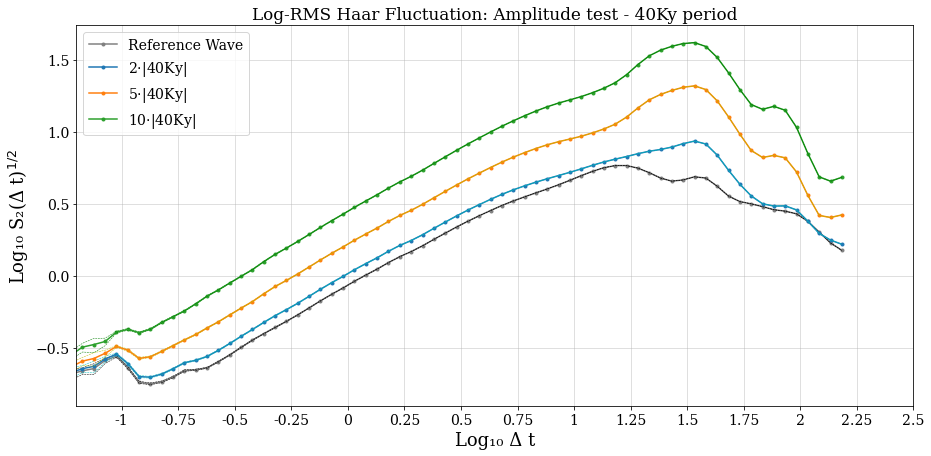

In [215]:
plt.subplots(figsize=(15, 7))
plt.plot(time,np.log10(amp),'.-',color='grey',label='Reference Wave')
plt.plot(time,np.log10(app),'--',color='black',linewidth=0.5)
plt.plot(time,np.log10(low),'--',color='black',linewidth=0.5)

plt.plot(time_amplitudE1,np.log10(amp_amplitudE1),'.-',label='2'+r'$\cdot$|40Ky|')
plt.plot(time_amplitudE1,np.log10(app_amplitudE1),'--',color='c',linewidth=0.5)
plt.plot(time_amplitudE1,np.log10(low_amplitudE1),'--',color='c',linewidth=0.5)

plt.plot(time_amplitudE2,np.log10(amp_amplitudE2),'.-',label='5'+r'$\cdot$|40Ky|')
plt.plot(time_amplitudE2,np.log10(app_amplitudE2),'--',color='y',linewidth=0.5)
plt.plot(time_amplitudE2,np.log10(low_amplitudE2),'--',color='y',linewidth=0.5)

plt.plot(time_amplitudE3,np.log10(amp_amplitudE3),'.-',label='10'+r'$\cdot$|40Ky|')
plt.plot(time_amplitudE3,np.log10(app_amplitudE3),'--',color='g',linewidth=0.5)
plt.plot(time_amplitudE3,np.log10(low_amplitudE3),'--',color='g',linewidth=0.5)


x_ticks  = [-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5]
x_labels = [-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5]
plt.xticks(ticks=x_ticks, labels=x_labels)


plt.title('Log-RMS Haar Fluctuation: Amplitude test - 40Ky period')
plt.xlabel('Log\u2081\u2080 \u0394 t',fontsize=18);plt.ylabel('Log\u2081\u2080 S\u2082(\u0394 t)'+r'$^{1/2}$',fontsize=18)
plt.xlim([-1.2,2.5]);plt.legend(loc=2)
plt.grid(alpha=0.5)


#plt.savefig('13-SinteticA2-8-amplitude5.pdf',bbox_inches='tight')
#plt.savefig('13-SinteticA2-8-amplitude5.jpg',bbox_inches='tight')
plt.show()

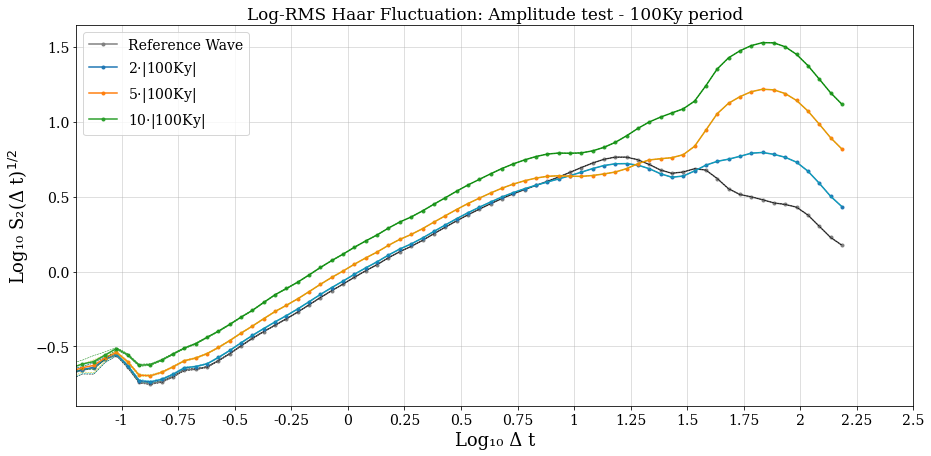

In [216]:
plt.subplots(figsize=(15, 7))
plt.plot(time,np.log10(amp),'.-',color='grey',label='Reference Wave')
plt.plot(time,np.log10(app),'--',color='black',linewidth=0.5)
plt.plot(time,np.log10(low),'--',color='black',linewidth=0.5)

plt.plot(time_amplitudF1,np.log10(amp_amplitudF1),'.-',label='2'+r'$\cdot$|100Ky|')
plt.plot(time_amplitudF1,np.log10(app_amplitudF1),'--',color='c',linewidth=0.5)
plt.plot(time_amplitudF1,np.log10(low_amplitudF1),'--',color='c',linewidth=0.5)

plt.plot(time_amplitudF2,np.log10(amp_amplitudF2),'.-',label='5'+r'$\cdot$|100Ky|')
plt.plot(time_amplitudF2,np.log10(app_amplitudF2),'--',color='y',linewidth=0.5)
plt.plot(time_amplitudF2,np.log10(low_amplitudF2),'--',color='y',linewidth=0.5)

plt.plot(time_amplitudF3,np.log10(amp_amplitudF3),'.-',label='10'+r'$\cdot$|100Ky|')
plt.plot(time_amplitudF3,np.log10(app_amplitudF3),'--',color='g',linewidth=0.5)
plt.plot(time_amplitudF3,np.log10(low_amplitudF3),'--',color='g',linewidth=0.5)


x_ticks  = [-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5]
x_labels = [-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5]
plt.xticks(ticks=x_ticks, labels=x_labels)


plt.title('Log-RMS Haar Fluctuation: Amplitude test - 100Ky period')
plt.xlabel('Log\u2081\u2080 \u0394 t',fontsize=18);plt.ylabel('Log\u2081\u2080 S\u2082(\u0394 t)'+r'$^{1/2}$',fontsize=18)
plt.xlim([-1.2,2.5]);plt.legend(loc=2)
plt.grid(alpha=0.5)


#plt.savefig('13-SinteticA2-8-amplitude6.pdf',bbox_inches='tight')
#plt.savefig('13-SinteticA2-8-amplitude6.jpg',bbox_inches='tight')
plt.show()

In [190]:
print(np.log10(20))
print(np.log10(40))
print(np.log10(100))

1.3010299956639813
1.6020599913279623
2.0


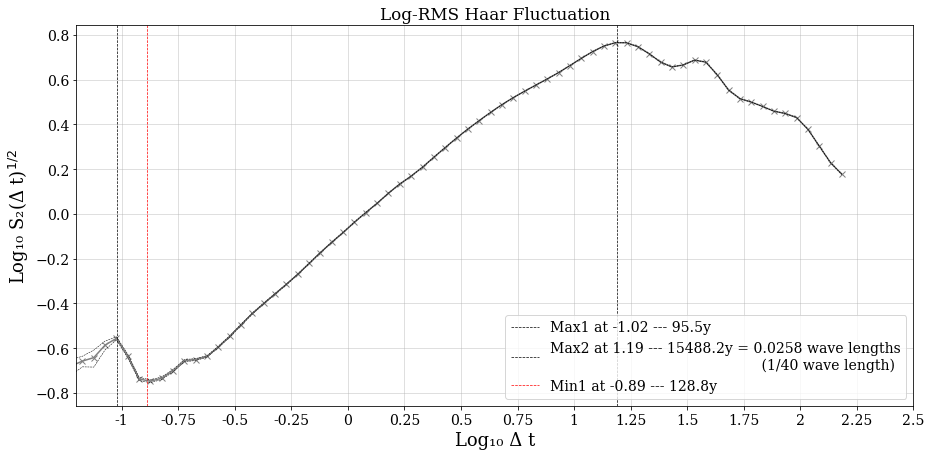

In [117]:
plt.subplots(figsize=(15, 7))
plt.plot(time,np.log10(amp),'x-',color='grey')#,label='Reference Wave')
plt.plot(time,np.log10(app),'--',color='black',linewidth=0.5)
plt.plot(time,np.log10(low),'--',color='black',linewidth=0.5)


x_ticks  = [-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5]
x_labels = [-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5]
plt.xticks(ticks=x_ticks, labels=x_labels)


plt.title('Log-RMS Haar Fluctuation')
plt.xlabel('Log\u2081\u2080 \u0394 t',fontsize=18);plt.ylabel('Log\u2081\u2080 S\u2082(\u0394 t)'+r'$^{1/2}$',fontsize=18)
plt.xlim([-1.2,2.5]);
plt.grid(alpha=0.5)

p13=np.round(np.log10(95/1000),2)
v13=np.round(np.log10(130/1000),2)
p23=np.round(np.log10(15500/1000),2)
#v23=np.round(np.log10(380/1000),2)
#p32=np.round(-0.42171043,2)
#v32=np.round(-0.32150156,2)

d1='Max1 at '+str(p13)+' --- '+str(np.round(10**p13*1000,1))+'y'
d2='Min1 at '+str(v13)+' --- '+str(np.round(10**v13*1000,1))+'y'
d3='Max2 at '+str(p23)+' --- '+str(np.round(10**p23*1000,1))+'y = '+str(np.round(10**p23*1000/600000,4))+' wave lengths\n                                               (1/40 wave length)'
#d4='Min2 at '+str(v23)+' --- '+str(np.round(10**v23*1000,1))+'y = '+str(np.round(10**v23*1000/100,1))+' wave lengths'
#b5='Max3 at '+str(p32)+' --- '+str(np.round(10**p32*1000,1))+'y = '+str(np.round(10**p32*1000/100,1))+' wave lengths'
#b6='Min3 at '+str(v32)+' --- '+str(np.round(10**v32*1000,1))+'y = '+str(np.round(10**v32*1000/100,1))+' wave lengths'

plt.axvline(x=p13,linestyle='--',linewidth=0.7,color='black',label=d1)
plt.axvline(x=p23,linestyle='--',linewidth=0.7,color='black',label=d3)
plt.axvline(x=v13,linestyle='--',linewidth=0.7,color='r',label=d2)


plt.legend()

#plt.savefig('13-SinteticA2-8-amplitude3.pdf',bbox_inches='tight')
#plt.savefig('13-SinteticA2-8-amplitude3 with vertical lines.jpg',bbox_inches='tight')
plt.show()

In [121]:
print(np.log10(3000/1000))
print(np.log10(5000/1000))
print(np.log10(10000/1000))

0.47712125471966244
0.6989700043360189
1.0


In [119]:
10**-0.89*1000

128.8249551693134

Podemos ver que no solo ela frecuencia es importante, sino también la amplitud de esta. De esta forma, si tenemos una onda de alta frecuancia pero incrementamos su amplitud, afectaremos toda la interacción, desplazando así tau_c hacia la derecha. 
Es decir, las condiciones más extremas que el antropoceno ha causado (en T°) podrían significar que la trancisión de macrotiempo a clima se desplace... verificar con los papers de lovejoy&lambert

#### Ahora veo cómo se desplaza tau_c si agrego una 4 señal de LF
##### le vuelvo a quitar el desface a wave 5yp

In [217]:
def wave3(res1,res2,res3,res4,res5,res6,name,period):    
    kyears1=2; 
    kyears2=10;
    kyears3=20;
    kyears4=50;
    kyears5=100;
    kyears6=200;    
    
    t11 = np.arange(0, kyears1+res1, res1); t21 = np.arange(0, kyears1+res1, res1); t31 = np.arange(0, kyears1+res1, res1);
    x11 = 0.1*np.sin(2000*np.pi*t11/5); x21 = 0.2*np.sin(2000*np.pi*t21/30); x31 = 0.1*np.sin(2000*np.pi*t31/100);
    t41 = np.arange(0, kyears1+res1, res1); t51 = np.arange(0, kyears1+res1, res1); t61 = np.arange(0, kyears1+res1, res1);
    x41 = 3*np.sin(2*np.pi*t41/20); x51 = 2*np.sin(2*np.pi*t51/40); x61 = 1.5*np.sin(2*np.pi*t61/100); 
    t71 = np.arange(0, kyears1+res1, res1)
    x71 = np.sin(2*np.pi*t71/period)
    
    T1=x11+x21+x31+x41+x51+x61+x71

    t12 = np.arange(kyears1, kyears2+res2, res2); t22 = np.arange(kyears1, kyears2+res2, res2); t32 = np.arange(kyears1, kyears2+res2, res2);
    x12 = 0.1*np.sin(2000*np.pi*t12/5); x22 = 0.2*np.sin(2000*np.pi*t22/30); x32 = 0.1*np.sin(2000*np.pi*t32/100);
    t42 = np.arange(kyears1, kyears2+res2, res2); t52 = np.arange(kyears1, kyears2+res2, res2); t62 = np.arange(kyears1, kyears2+res2, res2);
    x42 = 3*np.sin(2*np.pi*t42/20); x52 = 2*np.sin(2*np.pi*t52/40); x62 = 1.5*np.sin(2*np.pi*t62/100); 
    t72 = np.arange(kyears1, kyears2+res2, res2)
    x72 = np.sin(2*np.pi*t72/period)
    
    T2=x12+x22+x32+x42+x52+x62++x72

    t13 = np.arange(kyears2, kyears3+res3, res3); t23 = np.arange(kyears2, kyears3+res3, res3); t33 = np.arange(kyears2, kyears3+res3, res3);
    x13 = 0.1*np.sin(2000*np.pi*t13/5); x23 = 0.2*np.sin(2000*np.pi*t23/30); x33 = 0.1*np.sin(2000*np.pi*t33/100); 
    t43 = np.arange(kyears2, kyears3+res3, res3); t53 = np.arange(kyears2, kyears3+res3, res3); t63 = np.arange(kyears2, kyears3+res3, res3);
    x43 = 3*np.sin(2*np.pi*t43/20); x53 = 2*np.sin(2*np.pi*t53/40); x63 = 1.5*np.sin(2*np.pi*t63/100);
    t73 = np.arange(kyears2, kyears3+res3, res3)
    x73 = np.sin(2*np.pi*t73/period)
    
    T3=x13+x23+x33+x43+x53+x63+x73

    t14 = np.arange(kyears3, kyears4+res4, res4); t24 = np.arange(kyears3, kyears4+res4, res4); t34 = np.arange(kyears3, kyears4+res4, res4);
    x14 = 0.1*np.sin(2000*np.pi*t14/5); x24 = 0.2*np.sin(2000*np.pi*t24/30); x34 = 0.1*np.sin(2000*np.pi*t34/100);
    t44 = np.arange(kyears3, kyears4+res4, res4); t54 = np.arange(kyears3, kyears4+res4, res4); t64 = np.arange(kyears3, kyears4+res4, res4);
    x44 = 3*np.sin(2*np.pi*t44/20); x54 = 2*np.sin(2*np.pi*t54/40); x64 = 1.5*np.sin(2*np.pi*t64/100);
    t74 = np.arange(kyears3, kyears4+res4, res4)
    x74 = np.sin(2*np.pi*t74/period)
    
    T4=x14+x24+x34+x44+x54+x64+x74

    t15 = np.arange(kyears4, kyears5+res5, res5); t25 = np.arange(kyears4, kyears5+res5, res5); t35 = np.arange(kyears4, kyears5+res5, res5);
    x15 = 0.1*np.sin(2000*np.pi*t15/5); x25 = 0.2*np.sin(2000*np.pi*t25/30); x35 = 0.1*np.sin(2000*np.pi*t35/100); 
    t45 = np.arange(kyears4, kyears5+res5, res5); t55 = np.arange(kyears4, kyears5+res5, res5); t65 = np.arange(kyears4, kyears5+res5, res5);
    x45 = 3*np.sin(2*np.pi*t45/20); x55 = 2*np.sin(2*np.pi*t55/40); x65 = 1.5*np.sin(2*np.pi*t65/100); 
    t75 = np.arange(kyears4, kyears5+res5, res5)
    x75 = np.sin(2*np.pi*t75/period)
    
    T5=x15+x25+x35+x45+x55+x65+x75

    t16 = np.arange(kyears5, kyears6+res6, res6); t26 = np.arange(kyears5, kyears6+res6, res6); t36 = np.arange(kyears5, kyears6+res6, res6);
    x16 = 0.1*np.sin(2000*np.pi*t16/5); x26 = 0.2*np.sin(2000*np.pi*t26/30); x36 = 0.1*np.sin(2000*np.pi*t36/100);
    t46 = np.arange(kyears5, kyears6+res6, res6); t56 = np.arange(kyears5, kyears6+res6, res6); t66 = np.arange(kyears5, kyears6+res6, res6);
    x46 = 3*np.sin(2*np.pi*t46/20); x56 = 2*np.sin(2*np.pi*t56/40); x66 = 1.5*np.sin(2*np.pi*t66/100); 
    t76 = np.arange(kyears5, kyears6+res6, res6)
    x76 = np.sin(2*np.pi*t76/period)
    
    T6=x16+x26+x36+x46+x56+x66+x76

    T=np.concatenate((T1, T2, T3, T4, T5, T6)); t=np.concatenate((t11, t12, t13, t14, t15, t16))
    
    colors = ['#2D7FB8','#FF7F17','#2CA02C','#D62728','#9468BD','#A67D75']
    col_dic = {'0.005':'#2D7FB8','0.01':'#FF7F17','0.015':'#2CA02C','0.035':'#2CA02C','0.05':'#D62728','0.1':'#9468BD','0.2':'#A67D75'}

    fig, (ax1) = plt.subplots(1,figsize=(20, 7))
    #fig.suptitle('Sintetic 200ky temperature wave - Resolution '+name,fontsize=20)
    #ax1.plot(t,'--')
    #ax1.set_xlabel('Samples\n(A)', fontsize = 20.0)
    #ax1.set_ylabel('Time (Ky)', fontsize = 20)

    ax1.plot(t11,T1,'-',color=col_dic[str(res1)],label=str(int(res1*1000))+'y resolution')
    ax1.plot(t12,T2,'-',color=col_dic[str(res1)],label=str(int(res2*1000))+'y resolution')
    ax1.plot(t13,T3,'-',color=col_dic[str(res1)],label=str(int(res3*1000))+'y resolution')
    ax1.plot(t14,T4,'-',color=col_dic[str(res1)],label=str(int(res4*1000))+'y resolution')
    ax1.plot(t15,T5,'-',color=col_dic[str(res1)],label=str(int(res5*1000))+'y resolution')
    ax1.plot(t16,T6,'-',color=col_dic[str(res1)],label=str(int(res6*1000))+'y resolution')
    ax1.set_xlabel('Time (ky)', fontsize = 20.0)
    ax1.set_ylabel('T (°C)', fontsize = 20)
    #ax2.legend(loc=1)

    plt.savefig('13-SinteticA2-9-'+name+'.jpg',bbox_inches='tight')
    plt.show()  
    
    return t,T

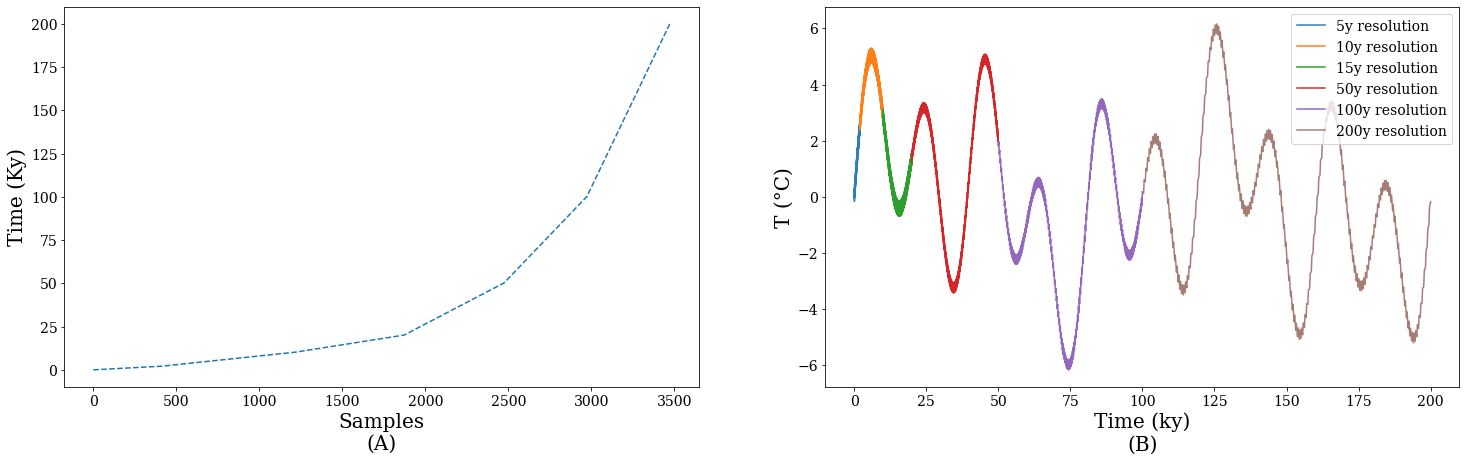

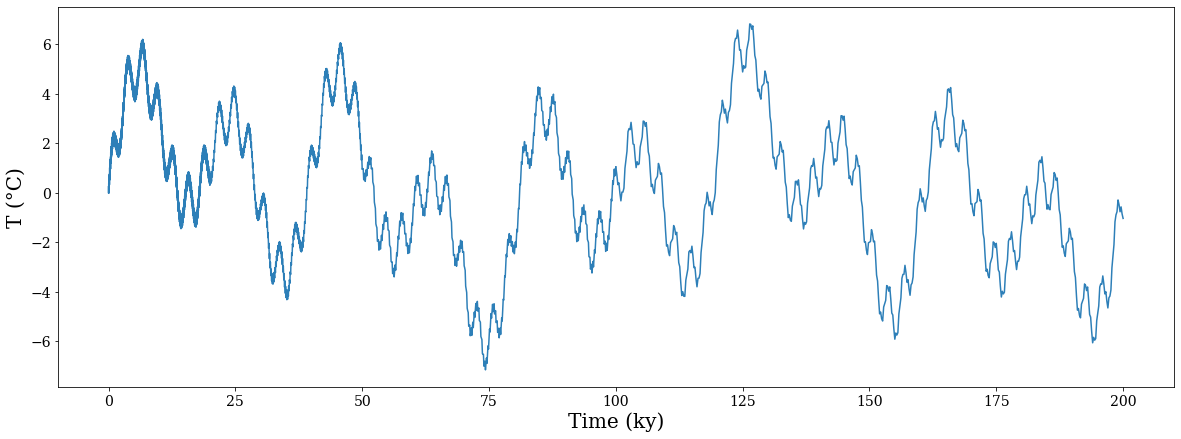

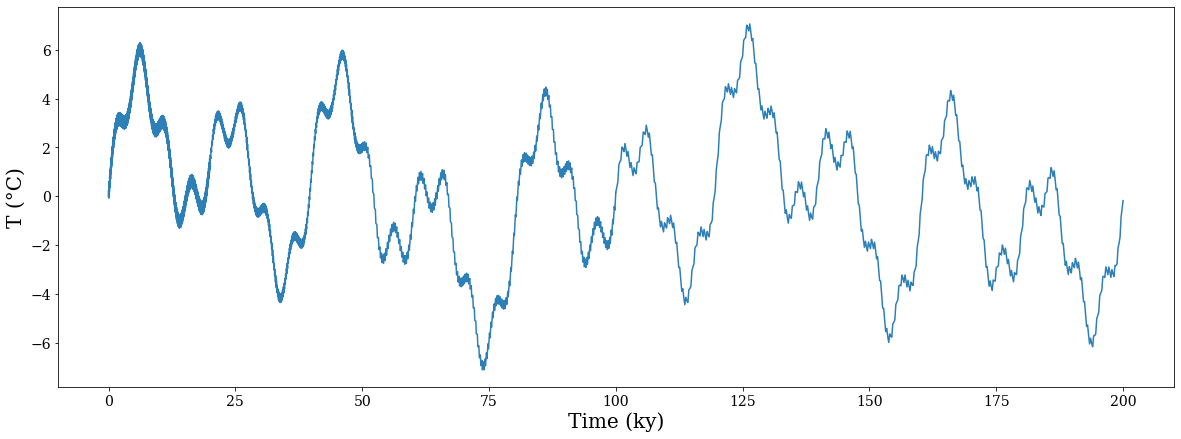

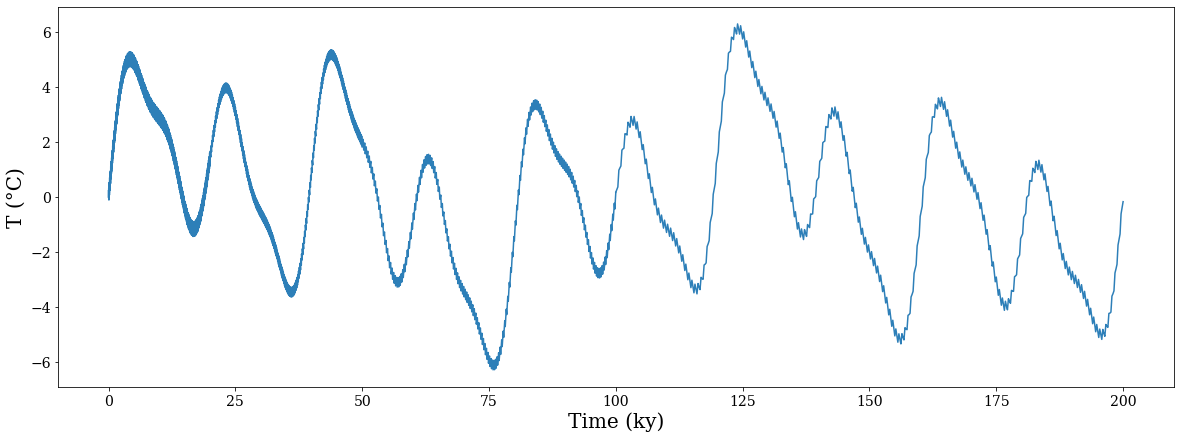

In [218]:
[s,S]=wave(0.005,0.01,0.015,0.05,0.1,0.2,'Reference')
[s1,S1]=wave3(0.005,0.01,0.015,0.05,0.1,0.2,'4ta señal 3ky',3) #con 4ta señal de periodo 3ky
[s2,S2]=wave3(0.005,0.01,0.015,0.05,0.1,0.2,'4ta señal 5ky',5) #con 4ta señal de periodo 5ky
[s3,S3]=wave3(0.005,0.01,0.015,0.05,0.1,0.2,'4ta señal 10ky',10) #con 4ta señal de periodo 10ky

In [219]:
[delta_tS,hsS,timeS,ampS,appS,lowS]=Haar(s,S,smooth=True)
[delta_tS1,hsS1,timeS1,ampS1,appS1,lowS1]=Haar(s1,S1,smooth=True) #con 4ta señal de periodo 3ky
[delta_tS2,hsS2,timeS2,ampS2,appS2,lowS2]=Haar(s2,S2,smooth=True) #con 4ta señal de periodo 5ky
[delta_tS3,hsS3,timeS3,ampS3,appS3,lowS3]=Haar(s3,S3,smooth=True) #con 4ta señal de periodo 10ky

t samples: 3472
deltas_t steps: from 1 to 1736
epsilons steps: 1736


<ipython-input-4-b432793d649f>:28: RuntimeWarning: invalid value encountered in true_divide
  int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
<ipython-input-4-b432793d649f>:27: RuntimeWarning: invalid value encountered in true_divide
  int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])


861930  fluctuaciones eliminadas ( 28.633407801742393 %)
t samples: 3472
deltas_t steps: from 1 to 1736
epsilons steps: 1736


<ipython-input-4-b432793d649f>:28: RuntimeWarning: invalid value encountered in true_divide
  int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
<ipython-input-4-b432793d649f>:27: RuntimeWarning: invalid value encountered in true_divide
  int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])


861930  fluctuaciones eliminadas ( 28.633407801742393 %)
t samples: 3472
deltas_t steps: from 1 to 1736
epsilons steps: 1736


<ipython-input-4-b432793d649f>:28: RuntimeWarning: invalid value encountered in true_divide
  int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
<ipython-input-4-b432793d649f>:27: RuntimeWarning: invalid value encountered in true_divide
  int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])


861930  fluctuaciones eliminadas ( 28.633407801742393 %)
t samples: 3472
deltas_t steps: from 1 to 1736
epsilons steps: 1736


<ipython-input-4-b432793d649f>:28: RuntimeWarning: invalid value encountered in true_divide
  int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
<ipython-input-4-b432793d649f>:27: RuntimeWarning: invalid value encountered in true_divide
  int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])


861930  fluctuaciones eliminadas ( 28.633407801742393 %)


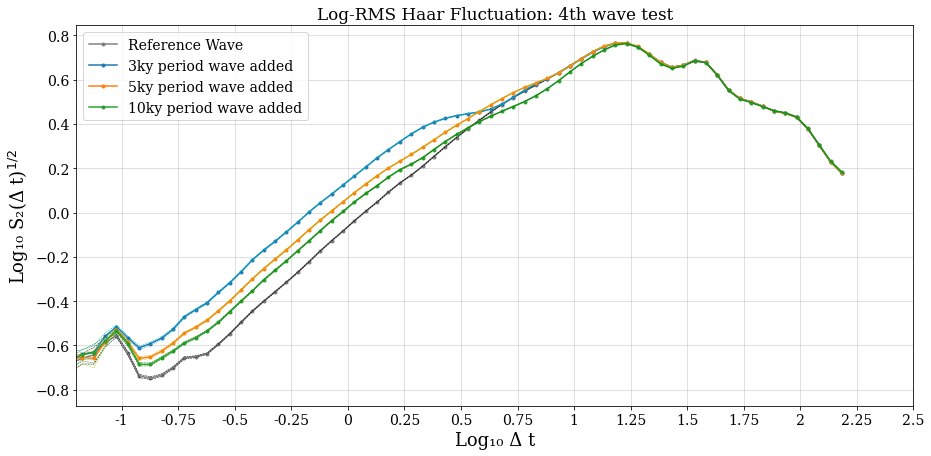

In [221]:
plt.subplots(figsize=(15, 7))
plt.plot(timeS,np.log10(ampS),'.-',color='grey',label='Reference Wave')
plt.plot(timeS,np.log10(appS),'--',color='black',linewidth=0.5)
plt.plot(timeS,np.log10(lowS),'--',color='black',linewidth=0.5)

plt.plot(timeS1,np.log10(ampS1),'.-',label='3ky period wave added')
plt.plot(timeS1,np.log10(appS1),'--',color='c',linewidth=0.5)
plt.plot(timeS1,np.log10(lowS1),'--',color='c',linewidth=0.5)

plt.plot(timeS2,np.log10(ampS2),'.-',label='5ky period wave added')
plt.plot(timeS2,np.log10(appS2),'--',color='y',linewidth=0.5)
plt.plot(timeS2,np.log10(lowS2),'--',color='y',linewidth=0.5)

plt.plot(timeS3,np.log10(ampS3),'.-',label='10ky period wave added')
plt.plot(timeS3,np.log10(appS3),'--',color='g',linewidth=0.5)
plt.plot(timeS3,np.log10(lowS3),'--',color='g',linewidth=0.5)


x_ticks  = [-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5]
x_labels = [-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5]
plt.xticks(ticks=x_ticks, labels=x_labels)


plt.title('Log-RMS Haar Fluctuation: 4th wave test')
plt.xlabel('Log\u2081\u2080 \u0394 t',fontsize=18);plt.ylabel('Log\u2081\u2080 S\u2082(\u0394 t)'+r'$^{1/2}$',fontsize=18)
plt.xlim([-1.2,2.5]);plt.legend()
plt.grid(alpha=0.5)

#plt.axvline(x=0.67,linestyle='--',linewidth=0.7,color='b')


#plt.savefig('13-SinteticA2-9-4ta señal haar.pdf',bbox_inches='tight')
#plt.savefig('13-SinteticA2-9-4ta señal haar.jpg',bbox_inches='tight')
plt.show()

### Pruebo interpolar mi onda sintética y comparar

In [222]:
#High frequencies
kyears1=10;
t11 = np.arange(0, kyears1, 0.005); # points
t21 = np.arange(0, kyears1, 0.005); # points
t31 = np.arange(0, kyears1, 0.005); # points

x11 = 0.1*np.sin(2000*np.pi*t11/5); #Periodo 5y
x21 = 0.2*np.sin(2000*np.pi*t21/30); #Periodo 30y
x31 = 0.1*np.sin(2000*np.pi*t31/100); #Periodo 100y

#Low frequencies
t41 = np.arange(0, kyears1, 0.005); # points
t51 = np.arange(0, kyears1, 0.005);
t61 = np.arange(0, kyears1, 0.005);

x41 = 3*np.sin(2*np.pi*t41/20); #Periodo 20ky
x51 = 2*np.sin(2*np.pi*t51/40); #Periodo 40ky
x61 = 1.5*np.sin(2*np.pi*t61/100); #Periodo 100ky

reference_time=t11#+t21+t31+t41+t51+t61
reference_val=x11+x21+x31+x41+x51+x61
print('Len: ',len(reference_time))

Len:  2000


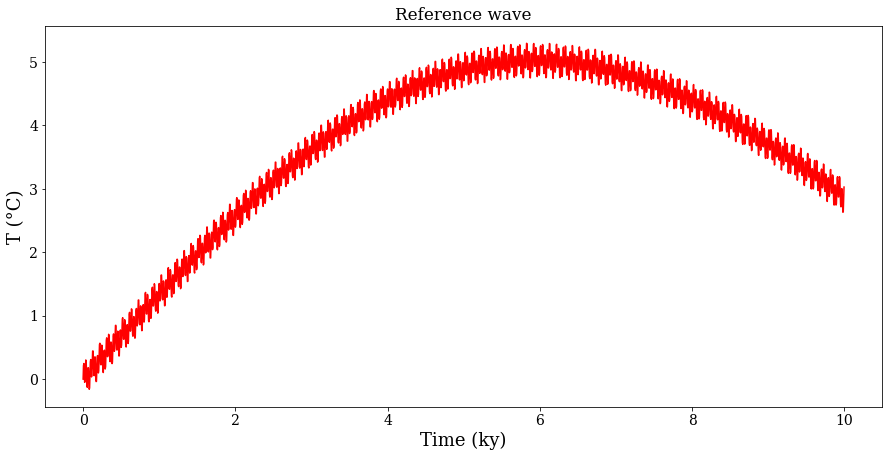

In [227]:
plt.subplots(figsize=(15, 7))
plt.plot(reference_time,reference_val,'-',color='r',label='Reference Wave')

#x_ticks  = [-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5]
#x_labels = [-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5]
#plt.xticks(ticks=x_ticks, labels=x_labels)

plt.title('Reference wave')
plt.xlabel('Time (ky)',fontsize=18);plt.ylabel('T (°C)',fontsize=18)
#plt.xlim([-1.2,2.5]);plt.legend()
#plt.grid(alpha=0.5)

#plt.savefig('13-SinteticA2-10-0reference wave1.jpg',bbox_inches='tight')

plt.show()

In [223]:
#x = np.sin(np.pi*t); x2 = x[t2]# Periodos: 2t
points=200; 
tt = np.arange(0, points, 0.1); #son los 2000 samples
#n=1500; t2 = np.sort(random.sample(range(len(tt)),n)) #voy a tomar 1500 de los 2000 puntos
n=800; t2 = np.sort(random.sample(range(len(tt)),n)) #voy a tomar 800 de los 2000 puntos

p=np.copy(reference_time[t2])
P=np.copy(reference_val[t2])

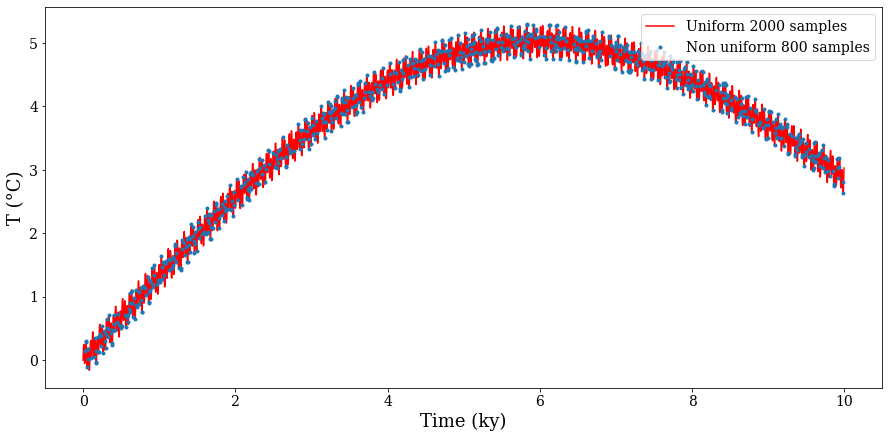

In [224]:
plt.subplots(figsize=(15, 7))
plt.plot(reference_time,reference_val,'-',color='red',label='Uniform 2000 samples')
plt.plot(p,P,'.',label='Non uniform 800 samples')

#plt.title('Neference wave')
plt.xlabel('Time (ky)',fontsize=18);plt.ylabel('T (°C)',fontsize=18)
plt.legend(loc=1)
plt.savefig('13-SinteticA2-10-0reference wave1.pdf',bbox_inches='tight')
plt.show()

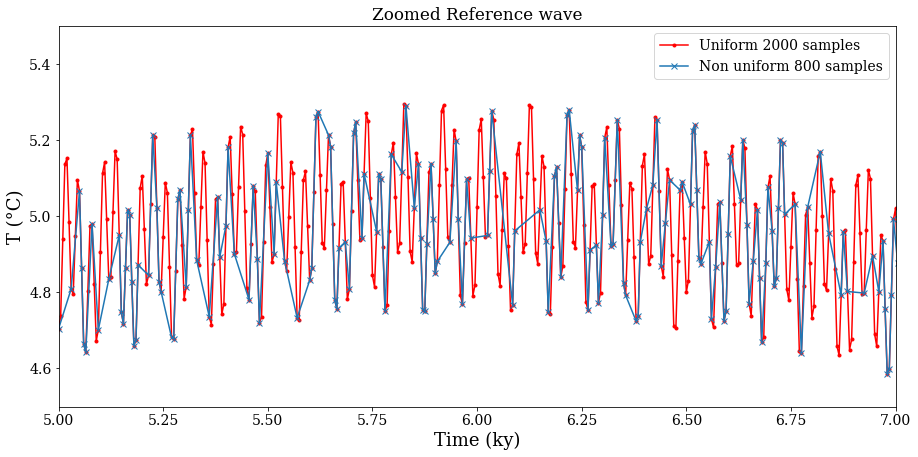

In [238]:
plt.subplots(figsize=(15, 7))
plt.plot(reference_time,reference_val,'.-',color='red',label='Uniform 2000 samples')
plt.plot(p,P,'x-',label='Non uniform 800 samples')
plt.axis([5, 7, 4.5,5.5])
plt.title('Zoomed Reference wave')
plt.xlabel('Time (ky)',fontsize=18);plt.ylabel('T (°C)',fontsize=18)
plt.legend()
#plt.savefig('13-SinteticA2-10-0reference wave2-800.jpg',bbox_inches='tight')
plt.show()

In [225]:
[delta_t_uniforme,hsS_uniforme,timeS_uniforme,ampS_uniforme,appS_uniforme,lowS_uniforme]=Haar(reference_time,reference_val,smooth=True)
[delta_t_nouniforme,hsS_nouniforme,timeS_nouniforme,ampS_nouniforme,appS_nouniforme,lowS_nouniforme]=Haar(p,P,smooth=True)

t samples: 1999
deltas_t steps: from 1 to 1000
epsilons steps: 1000
0  fluctuaciones eliminadas ( 0.0 %)
t samples: 799
deltas_t steps: from 1 to 400
epsilons steps: 400
550  fluctuaciones eliminadas ( 0.34634324504729164 %)


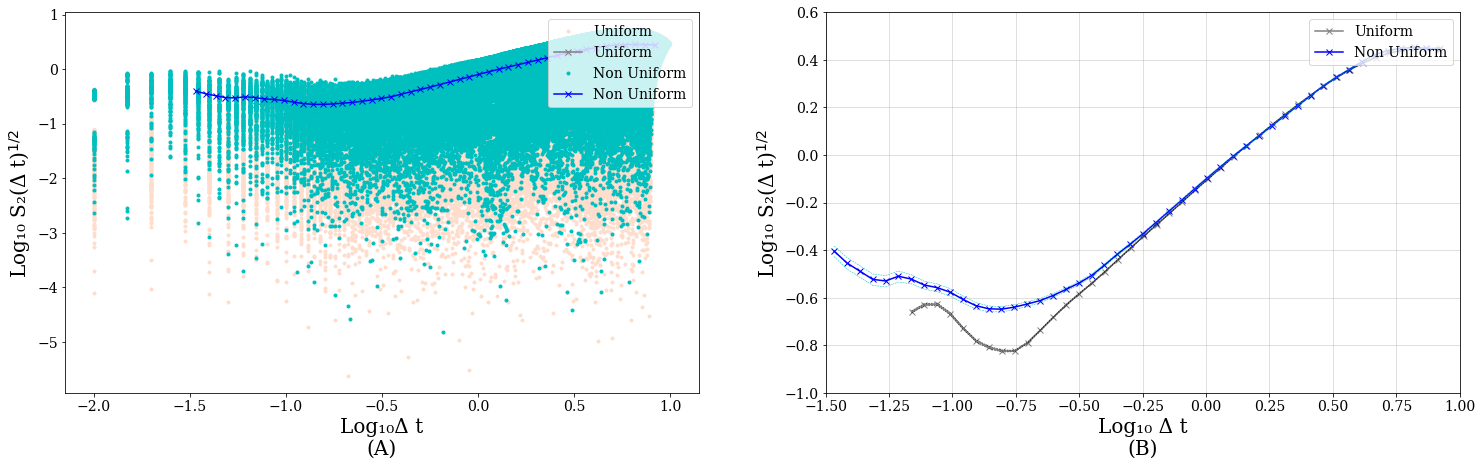

In [226]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(25, 7))

ax1.plot(np.log10(delta_t_uniforme),np.log10(np.sqrt(hsS_uniforme)),'.',color='#FFDDCD',label='Uniform')
ax1.plot(timeS_uniforme,np.log10(ampS_uniforme),'x-',color='grey',label='Uniform')
#ax1.set(title='RMS Haar Fluctuation')
ax1.set_xlabel('Log\u2081\u2080\u0394 t\n(A)', fontsize = 20.0)
ax1.set_ylabel('Log\u2081\u2080 S\u2082(\u0394 t)'+r'$^{1/2}$', fontsize = 20)
#ax1.set(xlim=[-2,1.5])
ax1.legend(loc=1)

ax2.plot(timeS_uniforme,np.log10(ampS_uniforme),'x-',color='grey',label='Uniform')
ax2.plot(timeS_uniforme,np.log10(appS_uniforme),'--',color='black',linewidth=0.5)
ax2.plot(timeS_uniforme,np.log10(lowS_uniforme),'--',color='black',linewidth=0.5)
#ax2.set(title='Log-RMS Haar Fluctuation: Resolution test 6')
ax2.set_xlabel('Log\u2081\u2080 \u0394 t\n(B)', fontsize = 20.0)
ax2.set_ylabel('Log\u2081\u2080 S\u2082(\u0394 t)'+r'$^{1/2}$', fontsize = 20)
ax2.set_xticks([-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5])



ax1.plot(np.log10(delta_t_nouniforme),np.log10(np.sqrt(hsS_nouniforme)),'.',color='c',label='Non Uniform')
ax1.plot(timeS_nouniforme,np.log10(ampS_nouniforme),'x-',color='blue',label='Non Uniform')
#ax1.set(title='RMS Haar Fluctuation')
ax1.set_xlabel('Log\u2081\u2080\u0394 t\n(A)', fontsize = 20.0)
ax1.set_ylabel('Log\u2081\u2080 S\u2082(\u0394 t)'+r'$^{1/2}$', fontsize = 20)
#ax1.set(xlim=[-2,1.5])
ax1.legend(loc=1)

ax2.plot(timeS_nouniforme,np.log10(ampS_nouniforme),'x-',color='blue',label='Non Uniform')
ax2.plot(timeS_nouniforme,np.log10(appS_nouniforme),'--',color='c',linewidth=0.5)
ax2.plot(timeS_nouniforme,np.log10(lowS_nouniforme),'--',color='c',linewidth=0.5)
#ax2.set(title='Log-RMS Haar Fluctuation: Resolution test 6')
ax2.set_xlabel('Log\u2081\u2080 \u0394 t\n(B)', fontsize = 20.0)
ax2.set_ylabel('Log\u2081\u2080 S\u2082(\u0394 t)'+r'$^{1/2}$', fontsize = 20)
ax2.set_xticks([-1.5,-1.25,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5])




ax2.set(xlim=[-1.5,1])
ax2.set(ylim=[-1,0.6])
ax2.legend(loc=1)
ax2.grid(alpha=0.5)

#plt.savefig('13-SinteticA2-10-1Haar1-800.jpg',bbox_inches='tight')

plt.show()

In [245]:
len(p)

800

In [247]:
uniform_age=np.copy(reference_time)
nuniform_values=np.array([])
j=0
for i in range(len(reference_time)-1):
    #print(i)
    if reference_time[i]==p[j]:
        nuniform_values=np.append(nuniform_values,P[j])
        j+=1  
    else:
        nuniform_values=np.append(nuniform_values,np.nan)


In [248]:
values_nan=pd.DataFrame(nuniform_values, columns = ['values'])
values_nan.to_excel('13-valores_a_interpolar-800.xlsx')

In [227]:
interpolado_excel='13-valores_interpolados_listos-800.xlsx'
df_data=pd.read_excel(interpolado_excel,sheet_name=0,skiprows=0)

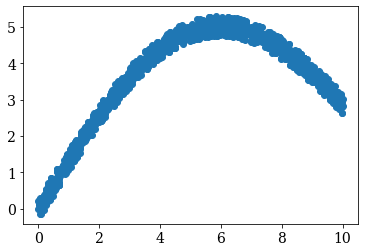

In [228]:
plt.plot(df_data[df_data.columns[0]],df_data[df_data.columns[1]],'o')
plt.show()

In [251]:
len(df_data[df_data.columns[0]])

2000

In [252]:
df_data

age     value
0      0.005  0.000000
1      0.010  0.210861
2      0.015  0.245492
3      0.020  0.101165
4      0.025  0.128580
...      ...       ...
1995   9.980  2.808211
1996   9.985  2.630681
1997   9.990  2.640559
1998   9.995  2.831559
1999  10.000  3.028312

[2000 rows x 2 columns]

In [229]:
time_interpolado=np.array(df_data[df_data.columns[0]])
val_interpolado=np.array(df_data[df_data.columns[1]])

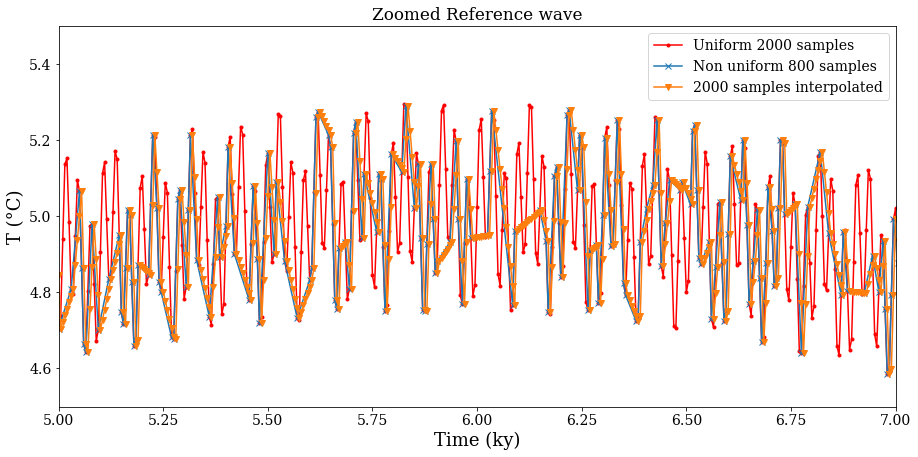

In [255]:
plt.subplots(figsize=(15, 7))
plt.plot(reference_time,reference_val,'.-',color='red',label='Uniform 2000 samples')
plt.plot(p,P,'x-',label='Non uniform 800 samples')
plt.plot(time_interpolado,val_interpolado,'v-',label='2000 samples interpolated')
plt.axis([5, 7, 4.5,5.5])
plt.title('Zoomed Reference wave')
plt.xlabel('Time (ky)',fontsize=18);plt.ylabel('T (°C)',fontsize=18)
plt.legend()

#plt.savefig('13-SinteticA2-10-2interpolated wave-800.jpg',bbox_inches='tight')

plt.show()

In [230]:
[delta_t_interpol,hsS_interpol,timeS_interpol,ampS_interpol,appS_interpol,lowS_interpol]=Haar(time_interpolado,val_interpolado,smooth=True)

t samples: 1999
deltas_t steps: from 1 to 1000
epsilons steps: 1000
0  fluctuaciones eliminadas ( 0.0 %)


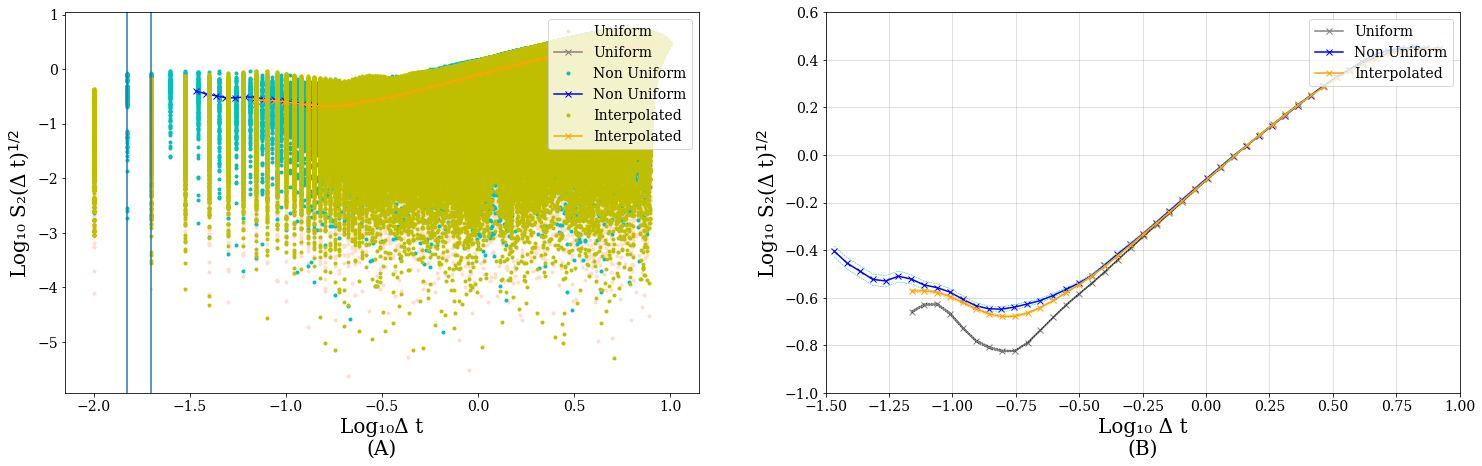

In [231]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(25, 7))

ax1.plot(np.log10(delta_t_uniforme),np.log10(np.sqrt(hsS_uniforme)),'.',color='#FFDDCD',label='Uniform')
ax1.plot(timeS_uniforme,np.log10(ampS_uniforme),'x-',color='grey',label='Uniform')
#ax1.set(title='RMS Haar Fluctuation')
ax1.set_xlabel('Log\u2081\u2080\u0394 t\n(A)', fontsize = 20.0)
ax1.set_ylabel('Log\u2081\u2080 S\u2082(\u0394 t)'+r'$^{1/2}$', fontsize = 20)
#ax1.set(xlim=[-2,1.5])
ax1.legend(loc=1)

ax2.plot(timeS_uniforme,np.log10(ampS_uniforme),'x-',color='grey',label='Uniform')
ax2.plot(timeS_uniforme,np.log10(appS_uniforme),'--',color='black',linewidth=0.5)
ax2.plot(timeS_uniforme,np.log10(lowS_uniforme),'--',color='black',linewidth=0.5)
#ax2.set(title='Log-RMS Haar Fluctuation: Resolution test 6')
ax2.set_xlabel('Log\u2081\u2080 \u0394 t\n(B)', fontsize = 20.0)
ax2.set_ylabel('Log\u2081\u2080 S\u2082(\u0394 t)'+r'$^{1/2}$', fontsize = 20)
ax2.set_xticks([-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5])



ax1.plot(np.log10(delta_t_nouniforme),np.log10(np.sqrt(hsS_nouniforme)),'.',color='c',label='Non Uniform')
ax1.plot(timeS_nouniforme,np.log10(ampS_nouniforme),'x-',color='blue',label='Non Uniform')
#ax1.set(title='RMS Haar Fluctuation')
ax1.set_xlabel('Log\u2081\u2080\u0394 t\n(A)', fontsize = 20.0)
ax1.set_ylabel('Log\u2081\u2080 S\u2082(\u0394 t)'+r'$^{1/2}$', fontsize = 20)
#ax1.set(xlim=[-2,1.5])
ax1.legend(loc=1)

ax2.plot(timeS_nouniforme,np.log10(ampS_nouniforme),'x-',color='blue',label='Non Uniform')
ax2.plot(timeS_nouniforme,np.log10(appS_nouniforme),'--',color='c',linewidth=0.5)
ax2.plot(timeS_nouniforme,np.log10(lowS_nouniforme),'--',color='c',linewidth=0.5)
#ax2.set(title='Log-RMS Haar Fluctuation: Resolution test 6')
ax2.set_xlabel('Log\u2081\u2080 \u0394 t\n(B)', fontsize = 20.0)
ax2.set_ylabel('Log\u2081\u2080 S\u2082(\u0394 t)'+r'$^{1/2}$', fontsize = 20)
ax2.set_xticks([-1.5,-1.25,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5])


ax1.plot(np.log10(delta_t_interpol),np.log10(np.sqrt(hsS_interpol)),'.',color='y',label='Interpolated')
ax1.plot(timeS_interpol,np.log10(ampS_interpol),'x-',color='orange',label='Interpolated')
#ax1.set(title='RMS Haar Fluctuation')
ax1.set_xlabel('Log\u2081\u2080\u0394 t\n(A)', fontsize = 20.0)
ax1.set_ylabel('Log\u2081\u2080 S\u2082(\u0394 t)'+r'$^{1/2}$', fontsize = 20)
#ax1.set(xlim=[-2,1.5])
ax1.legend(loc=1)

ax2.plot(timeS_interpol,np.log10(ampS_interpol),'x-',color='orange',label='Interpolated')
ax2.plot(timeS_interpol,np.log10(appS_interpol),'--',color='orange',linewidth=0.5)
ax2.plot(timeS_interpol,np.log10(lowS_interpol),'--',color='orange',linewidth=0.5)
#ax2.set(title='Log-RMS Haar Fluctuation: Resolution test 6')
ax2.set_xlabel('Log\u2081\u2080 \u0394 t\n(B)', fontsize = 20.0)
ax2.set_ylabel('Log\u2081\u2080 S\u2082(\u0394 t)'+r'$^{1/2}$', fontsize = 20)
ax2.set_xticks([-1.5,-1.25,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5])

ax1.axvline(np.log10(10/1000*2))
ax1.axvline(np.log10(15/1000))




ax2.set(xlim=[-1.5,1])
ax2.set(ylim=[-1,0.6])
ax2.legend(loc=1)
ax2.grid(alpha=0.5)

#plt.savefig('13-SinteticA2-10-3haar2-800.jpg',bbox_inches='tight')
plt.show()

In [260]:
print(np.log10(5/1000*2))
print(np.log10(10/1000*2))
print(np.log10(15/1000*2))
print(np.log10(50/1000*2))
print(np.log10(100/1000*2))
print(np.log10(200/1000*2))

-2.0
-1.6989700043360187
-1.5228787452803376
-1.0
-0.6989700043360187
-0.3979400086720376


In [318]:
10**-1.824*1000

14.996848355023733

In [326]:
print(len(p),len(delta_t_nouniforme))

800 158369


In [324]:
for i in range(len(delta_t_nouniforme)):
    print(i,'- ',delta_t_nouniforme[i]*1000)

0 -  9.999999999999787
1 -  9.999999999999787
2 -  9.999999999999787
3 -  9.999999999999787
4 -  9.999999999999787
5 -  9.999999999999787
6 -  9.999999999999787
7 -  9.999999999999787
8 -  9.999999999999787
9 -  9.999999999999787
10 -  9.999999999999787
11 -  9.999999999999787
12 -  9.999999999999787
13 -  9.999999999999787
14 -  9.999999999999787
15 -  9.999999999999787
16 -  9.999999999999787
17 -  9.999999999999787
18 -  9.999999999999787
19 -  9.999999999999787
20 -  9.999999999999787
21 -  9.999999999999787
22 -  9.999999999999787
23 -  9.999999999999787
24 -  9.999999999999787
25 -  9.999999999999787
26 -  9.999999999999787
27 -  9.999999999999787
28 -  9.999999999999787
29 -  9.999999999999787
30 -  9.999999999999787
31 -  9.999999999999787
32 -  9.999999999999787
33 -  9.999999999999787
34 -  9.999999999999787
35 -  9.999999999999787
36 -  9.999999999999787
37 -  9.999999999999787
38 -  9.999999999999787
39 -  9.999999999999787
40 -  9.999999999999787
41 -  9.999999999999787
42

702 -  35.00000000000014
703 -  35.00000000000014
704 -  35.00000000000014
705 -  35.00000000000014
706 -  35.00000000000014
707 -  35.00000000000014
708 -  35.00000000000014
709 -  35.00000000000014
710 -  35.00000000000014
711 -  35.00000000000014
712 -  35.00000000000014
713 -  35.00000000000014
714 -  35.00000000000014
715 -  35.00000000000014
716 -  35.00000000000014
717 -  35.00000000000014
718 -  35.00000000000014
719 -  35.00000000000014
720 -  35.00000000000014
721 -  35.00000000000014
722 -  35.00000000000014
723 -  35.00000000000014
724 -  35.00000000000014
725 -  35.00000000000014
726 -  35.00000000000014
727 -  35.00000000000014
728 -  35.00000000000014
729 -  35.00000000000014
730 -  35.00000000000014
731 -  35.00000000000014
732 -  35.00000000000014
733 -  35.00000000000014
734 -  35.00000000000014
735 -  35.00000000000014
736 -  35.00000000000014
737 -  35.00000000000014
738 -  35.00000000000014
739 -  35.00000000000014
740 -  35.00000000000014
741 -  35.00000000000014


1414 -  60.0000000000005
1415 -  60.0000000000005
1416 -  60.0000000000005
1417 -  60.0000000000005
1418 -  60.0000000000005
1419 -  60.0000000000005
1420 -  60.0000000000005
1421 -  60.0000000000005
1422 -  60.0000000000005
1423 -  60.0000000000005
1424 -  60.0000000000005
1425 -  60.0000000000005
1426 -  60.0000000000005
1427 -  60.0000000000005
1428 -  60.0000000000005
1429 -  60.0000000000005
1430 -  60.0000000000005
1431 -  60.0000000000005
1432 -  60.0000000000005
1433 -  60.0000000000005
1434 -  60.0000000000005
1435 -  60.0000000000005
1436 -  60.0000000000005
1437 -  60.0000000000005
1438 -  60.0000000000005
1439 -  60.0000000000005
1440 -  60.0000000000005
1441 -  60.0000000000005
1442 -  60.0000000000005
1443 -  60.0000000000005
1444 -  60.0000000000005
1445 -  60.0000000000005
1446 -  60.0000000000005
1447 -  60.0000000000005
1448 -  60.0000000000005
1449 -  60.0000000000005
1450 -  60.0000000000005
1451 -  60.0000000000005
1452 -  60.0000000000005
1453 -  60.0000000000005


2201 -  89.99999999999986
2202 -  89.99999999999986
2203 -  89.99999999999986
2204 -  89.99999999999986
2205 -  89.99999999999986
2206 -  89.99999999999986
2207 -  89.99999999999986
2208 -  89.99999999999986
2209 -  89.99999999999986
2210 -  89.99999999999986
2211 -  89.99999999999986
2212 -  89.99999999999986
2213 -  89.99999999999986
2214 -  89.99999999999986
2215 -  89.99999999999986
2216 -  89.99999999999986
2217 -  89.99999999999986
2218 -  89.99999999999986
2219 -  89.99999999999986
2220 -  89.99999999999986
2221 -  89.99999999999986
2222 -  89.99999999999986
2223 -  89.99999999999986
2224 -  89.99999999999986
2225 -  89.99999999999986
2226 -  89.99999999999986
2227 -  89.99999999999986
2228 -  89.99999999999986
2229 -  89.99999999999986
2230 -  89.99999999999986
2231 -  89.99999999999986
2232 -  89.99999999999986
2233 -  89.99999999999986
2234 -  89.99999999999986
2235 -  89.99999999999986
2236 -  89.99999999999986
2237 -  89.99999999999986
2238 -  89.99999999999986
2239 -  89.9

2868 -  110.00000000000031
2869 -  110.00000000000031
2870 -  110.00000000000031
2871 -  110.00000000000031
2872 -  110.00000000000031
2873 -  110.00000000000031
2874 -  110.00000000000031
2875 -  110.00000000000031
2876 -  110.00000000000031
2877 -  110.00000000000031
2878 -  110.00000000000031
2879 -  110.00000000000031
2880 -  110.00000000000031
2881 -  110.00000000000031
2882 -  110.00000000000031
2883 -  110.00000000000031
2884 -  110.00000000000031
2885 -  110.00000000000031
2886 -  110.00000000000031
2887 -  110.00000000000031
2888 -  110.00000000000031
2889 -  110.00000000000031
2890 -  110.00000000000031
2891 -  110.00000000000031
2892 -  110.00000000000031
2893 -  110.00000000000031
2894 -  110.00000000000031
2895 -  110.00000000000031
2896 -  110.00000000000031
2897 -  110.00000000000031
2898 -  110.00000000000031
2899 -  110.00000000000031
2900 -  110.00000000000031
2901 -  110.00000000000031
2902 -  110.00000000000031
2903 -  110.00000000000031
2904 -  110.00000000000031
2

3701 -  135.00000000000023
3702 -  135.00000000000023
3703 -  135.00000000000023
3704 -  135.00000000000068
3705 -  135.00000000000068
3706 -  135.00000000000068
3707 -  135.00000000000068
3708 -  135.00000000000068
3709 -  135.00000000000068
3710 -  135.00000000000068
3711 -  135.00000000000068
3712 -  135.00000000000068
3713 -  135.00000000000068
3714 -  135.00000000000068
3715 -  135.00000000000068
3716 -  135.00000000000068
3717 -  135.00000000000068
3718 -  135.00000000000068
3719 -  135.00000000000068
3720 -  135.00000000000068
3721 -  135.00000000000068
3722 -  135.00000000000068
3723 -  135.00000000000156
3724 -  139.9999999999988
3725 -  139.9999999999988
3726 -  139.9999999999988
3727 -  139.9999999999988
3728 -  139.9999999999988
3729 -  139.9999999999988
3730 -  139.9999999999988
3731 -  139.9999999999988
3732 -  139.9999999999988
3733 -  139.9999999999988
3734 -  139.9999999999997
3735 -  139.9999999999997
3736 -  139.9999999999997
3737 -  139.9999999999997
3738 -  139.999

4534 -  165.00000000000003
4535 -  165.00000000000003
4536 -  165.00000000000003
4537 -  165.00000000000003
4538 -  165.00000000000003
4539 -  165.00000000000003
4540 -  165.00000000000003
4541 -  165.00000000000003
4542 -  165.00000000000003
4543 -  165.00000000000003
4544 -  165.00000000000003
4545 -  165.00000000000003
4546 -  165.00000000000003
4547 -  165.00000000000003
4548 -  165.00000000000003
4549 -  165.00000000000003
4550 -  165.00000000000003
4551 -  165.00000000000003
4552 -  165.00000000000003
4553 -  165.00000000000003
4554 -  165.00000000000003
4555 -  165.00000000000003
4556 -  165.00000000000003
4557 -  165.00000000000003
4558 -  165.00000000000003
4559 -  165.00000000000003
4560 -  165.00000000000003
4561 -  165.00000000000003
4562 -  165.00000000000003
4563 -  165.00000000000003
4564 -  165.00000000000003
4565 -  165.00000000000003
4566 -  165.00000000000003
4567 -  165.00000000000003
4568 -  165.00000000000003
4569 -  165.00000000000003
4570 -  165.00000000000003
4

5201 -  185.00000000000006
5202 -  185.00000000000006
5203 -  185.00000000000006
5204 -  185.00000000000006
5205 -  185.00000000000006
5206 -  185.00000000000006
5207 -  185.00000000000006
5208 -  185.00000000000028
5209 -  185.0000000000005
5210 -  185.0000000000005
5211 -  185.0000000000005
5212 -  185.0000000000005
5213 -  185.0000000000005
5214 -  185.0000000000005
5215 -  185.0000000000005
5216 -  185.0000000000005
5217 -  185.0000000000005
5218 -  185.0000000000005
5219 -  185.0000000000005
5220 -  185.0000000000005
5221 -  185.0000000000005
5222 -  185.0000000000005
5223 -  185.0000000000005
5224 -  185.0000000000005
5225 -  185.0000000000005
5226 -  185.0000000000005
5227 -  185.0000000000005
5228 -  185.0000000000005
5229 -  185.0000000000005
5230 -  185.0000000000005
5231 -  185.0000000000005
5232 -  185.0000000000005
5233 -  185.0000000000005
5234 -  185.0000000000005
5235 -  185.0000000000005
5236 -  185.0000000000005
5237 -  185.0000000000005
5238 -  185.0000000000005
5239

6025 -  210.0000000000004
6026 -  210.0000000000004
6027 -  210.0000000000004
6028 -  210.0000000000004
6029 -  210.0000000000004
6030 -  210.00000000000085
6031 -  210.00000000000085
6032 -  210.00000000000085
6033 -  210.00000000000085
6034 -  210.00000000000085
6035 -  210.00000000000085
6036 -  210.00000000000085
6037 -  210.00000000000085
6038 -  210.00000000000085
6039 -  210.00000000000085
6040 -  210.00000000000085
6041 -  210.00000000000085
6042 -  210.00000000000085
6043 -  210.00000000000085
6044 -  210.00000000000085
6045 -  210.00000000000085
6046 -  210.00000000000085
6047 -  210.00000000000085
6048 -  210.00000000000085
6049 -  210.00000000000085
6050 -  214.99999999999898
6051 -  214.99999999999986
6052 -  214.99999999999986
6053 -  214.99999999999986
6054 -  214.99999999999986
6055 -  214.99999999999986
6056 -  214.99999999999986
6057 -  214.99999999999986
6058 -  214.99999999999986
6059 -  214.99999999999986
6060 -  214.99999999999986
6061 -  214.99999999999986
6062 -

6867 -  240.0
6868 -  240.0
6869 -  240.0
6870 -  240.0
6871 -  240.0
6872 -  240.0
6873 -  240.0
6874 -  240.0
6875 -  240.0
6876 -  240.0
6877 -  240.00000000000003
6878 -  240.00000000000003
6879 -  240.00000000000003
6880 -  240.00000000000003
6881 -  240.00000000000006
6882 -  240.0000000000001
6883 -  240.0000000000001
6884 -  240.0000000000001
6885 -  240.00000000000023
6886 -  240.00000000000023
6887 -  240.00000000000023
6888 -  240.00000000000023
6889 -  240.00000000000023
6890 -  240.00000000000023
6891 -  240.00000000000023
6892 -  240.00000000000023
6893 -  240.00000000000023
6894 -  240.00000000000023
6895 -  240.00000000000023
6896 -  240.00000000000023
6897 -  240.00000000000023
6898 -  240.00000000000023
6899 -  240.00000000000023
6900 -  240.00000000000023
6901 -  240.00000000000023
6902 -  240.00000000000023
6903 -  240.00000000000023
6904 -  240.00000000000023
6905 -  240.00000000000023
6906 -  240.00000000000023
6907 -  240.00000000000023
6908 -  240.00000000000023

7733 -  269.99999999999955
7734 -  269.99999999999955
7735 -  269.99999999999955
7736 -  269.99999999999955
7737 -  269.99999999999955
7738 -  269.99999999999955
7739 -  269.99999999999955
7740 -  269.99999999999955
7741 -  269.99999999999955
7742 -  269.99999999999955
7743 -  269.99999999999955
7744 -  269.99999999999955
7745 -  269.99999999999955
7746 -  269.99999999999955
7747 -  269.99999999999955
7748 -  269.99999999999955
7749 -  269.99999999999955
7750 -  269.99999999999955
7751 -  269.99999999999955
7752 -  269.99999999999955
7753 -  269.99999999999955
7754 -  269.99999999999955
7755 -  269.99999999999955
7756 -  269.99999999999955
7757 -  269.99999999999955
7758 -  269.99999999999955
7759 -  269.99999999999955
7760 -  269.99999999999955
7761 -  269.99999999999955
7762 -  269.99999999999955
7763 -  269.99999999999955
7764 -  269.99999999999955
7765 -  269.99999999999955
7766 -  269.99999999999955
7767 -  269.99999999999955
7768 -  269.99999999999955
7769 -  269.99999999999955
7

8700 -  299.99999999999983
8701 -  299.99999999999983
8702 -  299.99999999999983
8703 -  299.99999999999983
8704 -  299.99999999999983
8705 -  299.99999999999983
8706 -  299.99999999999983
8707 -  299.99999999999983
8708 -  299.99999999999983
8709 -  299.99999999999983
8710 -  299.99999999999983
8711 -  299.99999999999983
8712 -  299.99999999999983
8713 -  299.99999999999983
8714 -  299.99999999999983
8715 -  299.99999999999983
8716 -  299.99999999999983
8717 -  299.99999999999983
8718 -  299.99999999999983
8719 -  299.99999999999983
8720 -  299.99999999999983
8721 -  299.99999999999983
8722 -  299.99999999999983
8723 -  299.99999999999983
8724 -  299.99999999999983
8725 -  299.99999999999983
8726 -  299.99999999999983
8727 -  299.99999999999983
8728 -  299.99999999999983
8729 -  299.99999999999983
8730 -  299.99999999999983
8731 -  299.99999999999983
8732 -  299.99999999999983
8733 -  299.99999999999983
8734 -  299.99999999999983
8735 -  299.99999999999983
8736 -  299.99999999999983
8

9568 -  325.00000000000017
9569 -  325.00000000000017
9570 -  325.00000000000017
9571 -  325.00000000000017
9572 -  325.00000000000017
9573 -  325.00000000000017
9574 -  325.0000000000011
9575 -  325.0000000000011
9576 -  325.0000000000011
9577 -  325.0000000000011
9578 -  325.0000000000011
9579 -  325.0000000000011
9580 -  325.0000000000011
9581 -  325.0000000000011
9582 -  325.0000000000011
9583 -  325.0000000000011
9584 -  325.0000000000011
9585 -  329.9999999999992
9586 -  329.9999999999992
9587 -  329.9999999999992
9588 -  329.9999999999992
9589 -  329.9999999999992
9590 -  329.9999999999992
9591 -  329.9999999999992
9592 -  329.9999999999996
9593 -  329.9999999999996
9594 -  329.9999999999996
9595 -  329.9999999999996
9596 -  329.9999999999996
9597 -  329.9999999999996
9598 -  329.9999999999996
9599 -  329.9999999999996
9600 -  329.9999999999996
9601 -  329.9999999999996
9602 -  329.9999999999996
9603 -  329.99999999999983
9604 -  329.99999999999983
9605 -  329.99999999999983
960

10464 -  355.00000000000045
10465 -  355.00000000000045
10466 -  355.00000000000045
10467 -  355.00000000000045
10468 -  355.00000000000045
10469 -  355.00000000000045
10470 -  355.00000000000045
10471 -  355.00000000000045
10472 -  355.00000000000045
10473 -  355.00000000000045
10474 -  355.00000000000045
10475 -  355.00000000000045
10476 -  355.00000000000045
10477 -  355.00000000000045
10478 -  355.00000000000045
10479 -  355.00000000000045
10480 -  355.00000000000045
10481 -  355.00000000000045
10482 -  355.00000000000045
10483 -  355.00000000000045
10484 -  355.00000000000045
10485 -  355.00000000000045
10486 -  355.00000000000045
10487 -  355.00000000000045
10488 -  355.00000000000045
10489 -  355.00000000000045
10490 -  355.00000000000045
10491 -  355.00000000000045
10492 -  355.00000000000045
10493 -  355.00000000000045
10494 -  355.00000000000045
10495 -  355.00000000000045
10496 -  355.00000000000045
10497 -  355.00000000000045
10498 -  355.00000000000045
10499 -  355.0000000

11366 -  385.0
11367 -  385.0
11368 -  385.0
11369 -  385.0
11370 -  385.0
11371 -  385.0
11372 -  385.0
11373 -  385.0
11374 -  385.0
11375 -  385.0
11376 -  385.0
11377 -  385.0
11378 -  385.0
11379 -  385.0
11380 -  385.0
11381 -  385.0
11382 -  385.0
11383 -  385.0
11384 -  385.0
11385 -  385.0
11386 -  385.0
11387 -  385.0
11388 -  385.0
11389 -  385.0
11390 -  385.00000000000006
11391 -  385.0000000000002
11392 -  385.0000000000002
11393 -  385.0000000000002
11394 -  385.0000000000002
11395 -  385.0000000000002
11396 -  385.0000000000002
11397 -  385.0000000000002
11398 -  385.0000000000002
11399 -  385.0000000000002
11400 -  385.0000000000002
11401 -  385.0000000000002
11402 -  385.0000000000002
11403 -  385.0000000000002
11404 -  385.0000000000002
11405 -  385.0000000000002
11406 -  385.0000000000002
11407 -  385.0000000000002
11408 -  385.0000000000002
11409 -  385.0000000000007
11410 -  385.0000000000007
11411 -  385.0000000000007
11412 -  385.0000000000007
11413 -  385.00000

12199 -  415.00000000000006
12200 -  415.00000000000006
12201 -  415.00000000000006
12202 -  415.00000000000006
12203 -  415.00000000000006
12204 -  415.00000000000006
12205 -  415.00000000000006
12206 -  415.00000000000006
12207 -  415.00000000000006
12208 -  415.00000000000006
12209 -  415.00000000000006
12210 -  415.00000000000006
12211 -  415.00000000000006
12212 -  415.00000000000006
12213 -  415.00000000000006
12214 -  415.00000000000006
12215 -  415.00000000000006
12216 -  415.00000000000006
12217 -  415.00000000000006
12218 -  415.00000000000006
12219 -  415.00000000000006
12220 -  415.00000000000006
12221 -  415.00000000000006
12222 -  415.00000000000006
12223 -  415.00000000000006
12224 -  415.00000000000006
12225 -  415.00000000000006
12226 -  415.00000000000006
12227 -  415.00000000000006
12228 -  415.00000000000006
12229 -  415.00000000000006
12230 -  415.00000000000006
12231 -  415.00000000000006
12232 -  415.00000000000006
12233 -  415.00000000000006
12234 -  415.0000000

13352 -  450.00000000000017
13353 -  450.00000000000017
13354 -  450.00000000000017
13355 -  450.00000000000017
13356 -  450.00000000000017
13357 -  450.00000000000017
13358 -  450.00000000000017
13359 -  450.00000000000017
13360 -  450.00000000000017
13361 -  450.00000000000017
13362 -  450.00000000000017
13363 -  450.00000000000017
13364 -  450.00000000000017
13365 -  450.00000000000017
13366 -  450.00000000000017
13367 -  450.0000000000011
13368 -  450.0000000000011
13369 -  450.0000000000011
13370 -  450.0000000000011
13371 -  450.0000000000011
13372 -  450.0000000000011
13373 -  450.0000000000011
13374 -  450.0000000000011
13375 -  450.0000000000011
13376 -  450.0000000000011
13377 -  450.0000000000011
13378 -  450.0000000000011
13379 -  450.0000000000011
13380 -  450.0000000000011
13381 -  450.0000000000011
13382 -  454.9999999999983
13383 -  454.9999999999992
13384 -  454.9999999999992
13385 -  454.9999999999992
13386 -  454.9999999999992
13387 -  454.9999999999992
13388 -  454.

14199 -  480.0
14200 -  480.0
14201 -  480.0
14202 -  480.0
14203 -  480.0
14204 -  480.0
14205 -  480.0
14206 -  480.0
14207 -  480.0
14208 -  480.0
14209 -  480.0
14210 -  480.0
14211 -  480.00000000000006
14212 -  480.00000000000006
14213 -  480.0000000000001
14214 -  480.0000000000001
14215 -  480.0000000000001
14216 -  480.0000000000001
14217 -  480.0000000000001
14218 -  480.0000000000002
14219 -  480.0000000000002
14220 -  480.0000000000002
14221 -  480.0000000000002
14222 -  480.0000000000002
14223 -  480.00000000000045
14224 -  480.00000000000045
14225 -  480.00000000000045
14226 -  480.00000000000045
14227 -  480.00000000000045
14228 -  480.00000000000045
14229 -  480.00000000000045
14230 -  480.00000000000045
14231 -  480.00000000000045
14232 -  480.00000000000045
14233 -  480.00000000000045
14234 -  480.00000000000045
14235 -  480.00000000000045
14236 -  480.00000000000045
14237 -  480.00000000000045
14238 -  480.00000000000045
14239 -  480.00000000000045
14240 -  480.00000

15199 -  514.9999999999987
15200 -  514.9999999999987
15201 -  514.9999999999987
15202 -  514.9999999999987
15203 -  514.9999999999987
15204 -  514.9999999999987
15205 -  514.9999999999997
15206 -  514.9999999999997
15207 -  514.9999999999997
15208 -  514.9999999999997
15209 -  514.9999999999997
15210 -  514.9999999999997
15211 -  514.9999999999997
15212 -  514.9999999999997
15213 -  514.9999999999997
15214 -  514.9999999999997
15215 -  514.9999999999997
15216 -  514.9999999999997
15217 -  514.9999999999997
15218 -  514.9999999999997
15219 -  514.9999999999997
15220 -  514.9999999999997
15221 -  514.9999999999997
15222 -  514.9999999999997
15223 -  514.9999999999997
15224 -  514.9999999999997
15225 -  514.9999999999997
15226 -  514.9999999999997
15227 -  514.9999999999997
15228 -  514.9999999999997
15229 -  514.9999999999997
15230 -  514.9999999999997
15231 -  514.9999999999997
15232 -  514.9999999999997
15233 -  514.9999999999997
15234 -  514.9999999999997
15235 -  514.9999999999997
1

16199 -  544.9999999999999
16200 -  544.9999999999999
16201 -  544.9999999999999
16202 -  544.9999999999999
16203 -  544.9999999999999
16204 -  544.9999999999999
16205 -  544.9999999999999
16206 -  544.9999999999999
16207 -  544.9999999999999
16208 -  544.9999999999999
16209 -  544.9999999999999
16210 -  544.9999999999999
16211 -  544.9999999999999
16212 -  545.0
16213 -  545.0
16214 -  545.0
16215 -  545.0
16216 -  545.0
16217 -  545.0
16218 -  545.0
16219 -  545.0000000000001
16220 -  545.0000000000001
16221 -  545.0000000000001
16222 -  545.0000000000001
16223 -  545.0000000000001
16224 -  545.0000000000001
16225 -  545.0000000000001
16226 -  545.0000000000001
16227 -  545.0000000000001
16228 -  545.0000000000003
16229 -  545.0000000000003
16230 -  545.0000000000003
16231 -  545.0000000000003
16232 -  545.0000000000008
16233 -  545.0000000000008
16234 -  545.0000000000008
16235 -  545.0000000000008
16236 -  545.0000000000008
16237 -  545.0000000000017
16238 -  549.999999999999
16239

17115 -  575.000000000001
17116 -  575.000000000001
17117 -  575.000000000001
17118 -  575.000000000001
17119 -  575.000000000001
17120 -  575.000000000001
17121 -  579.9999999999983
17122 -  579.9999999999992
17123 -  579.9999999999992
17124 -  579.9999999999992
17125 -  579.9999999999992
17126 -  579.9999999999992
17127 -  579.9999999999992
17128 -  579.9999999999992
17129 -  579.9999999999992
17130 -  579.9999999999992
17131 -  579.9999999999992
17132 -  579.9999999999992
17133 -  579.9999999999992
17134 -  579.9999999999992
17135 -  579.9999999999992
17136 -  579.9999999999997
17137 -  579.9999999999997
17138 -  579.9999999999997
17139 -  579.9999999999997
17140 -  579.9999999999997
17141 -  579.9999999999997
17142 -  579.9999999999997
17143 -  579.9999999999997
17144 -  579.9999999999999
17145 -  579.9999999999999
17146 -  579.9999999999999
17147 -  579.9999999999999
17148 -  579.9999999999999
17149 -  579.9999999999999
17150 -  579.9999999999999
17151 -  579.9999999999999
17152 -

18032 -  609.9999999999994
18033 -  609.9999999999994
18034 -  609.9999999999994
18035 -  609.9999999999994
18036 -  609.9999999999994
18037 -  609.9999999999994
18038 -  609.9999999999994
18039 -  609.9999999999994
18040 -  609.9999999999994
18041 -  609.9999999999994
18042 -  609.9999999999994
18043 -  609.9999999999994
18044 -  609.9999999999994
18045 -  609.9999999999994
18046 -  609.9999999999994
18047 -  609.9999999999994
18048 -  609.9999999999994
18049 -  609.9999999999994
18050 -  609.9999999999994
18051 -  609.9999999999994
18052 -  609.9999999999994
18053 -  609.9999999999994
18054 -  609.9999999999994
18055 -  609.9999999999994
18056 -  609.9999999999999
18057 -  609.9999999999999
18058 -  609.9999999999999
18059 -  609.9999999999999
18060 -  609.9999999999999
18061 -  609.9999999999999
18062 -  609.9999999999999
18063 -  609.9999999999999
18064 -  609.9999999999999
18065 -  609.9999999999999
18066 -  609.9999999999999
18067 -  609.9999999999999
18068 -  609.9999999999999
1

18865 -  635.0000000000001
18866 -  635.0000000000002
18867 -  635.0000000000002
18868 -  635.0000000000002
18869 -  635.0000000000002
18870 -  635.0000000000002
18871 -  635.0000000000002
18872 -  635.0000000000002
18873 -  635.0000000000002
18874 -  635.0000000000002
18875 -  635.0000000000002
18876 -  635.0000000000002
18877 -  635.0000000000002
18878 -  635.0000000000002
18879 -  635.0000000000002
18880 -  635.0000000000002
18881 -  635.0000000000002
18882 -  635.0000000000002
18883 -  635.0000000000002
18884 -  635.0000000000007
18885 -  635.0000000000007
18886 -  635.0000000000007
18887 -  635.0000000000007
18888 -  635.0000000000007
18889 -  635.0000000000007
18890 -  635.0000000000007
18891 -  635.0000000000007
18892 -  635.0000000000007
18893 -  635.0000000000007
18894 -  635.0000000000016
18895 -  635.0000000000016
18896 -  635.0000000000016
18897 -  639.9999999999987
18898 -  639.9999999999987
18899 -  639.9999999999987
18900 -  639.9999999999987
18901 -  639.9999999999987
1

19865 -  669.9999999999999
19866 -  669.9999999999999
19867 -  669.9999999999999
19868 -  669.9999999999999
19869 -  669.9999999999999
19870 -  669.9999999999999
19871 -  669.9999999999999
19872 -  669.9999999999999
19873 -  669.9999999999999
19874 -  669.9999999999999
19875 -  669.9999999999999
19876 -  669.9999999999999
19877 -  669.9999999999999
19878 -  669.9999999999999
19879 -  669.9999999999999
19880 -  669.9999999999999
19881 -  669.9999999999999
19882 -  669.9999999999999
19883 -  669.9999999999999
19884 -  669.9999999999999
19885 -  669.9999999999999
19886 -  669.9999999999999
19887 -  669.9999999999999
19888 -  669.9999999999999
19889 -  669.9999999999999
19890 -  669.9999999999999
19891 -  669.9999999999999
19892 -  669.9999999999999
19893 -  669.9999999999999
19894 -  669.9999999999999
19895 -  669.9999999999999
19896 -  669.9999999999999
19897 -  669.9999999999999
19898 -  669.9999999999999
19899 -  669.9999999999999
19900 -  669.9999999999999
19901 -  669.9999999999999
1

20615 -  695.0000000000002
20616 -  695.0000000000002
20617 -  695.0000000000002
20618 -  695.0000000000002
20619 -  695.0000000000002
20620 -  695.0000000000002
20621 -  695.0000000000002
20622 -  695.0000000000002
20623 -  695.0000000000002
20624 -  695.0000000000002
20625 -  695.0000000000002
20626 -  695.0000000000002
20627 -  695.0000000000002
20628 -  695.0000000000002
20629 -  695.0000000000002
20630 -  695.0000000000002
20631 -  695.0000000000002
20632 -  695.0000000000002
20633 -  695.0000000000002
20634 -  695.0000000000002
20635 -  695.0000000000002
20636 -  695.0000000000002
20637 -  695.0000000000002
20638 -  695.0000000000002
20639 -  695.0000000000002
20640 -  695.0000000000002
20641 -  695.0000000000002
20642 -  695.0000000000002
20643 -  695.0000000000002
20644 -  695.0000000000002
20645 -  695.0000000000002
20646 -  695.0000000000002
20647 -  695.0000000000002
20648 -  695.0000000000002
20649 -  695.0000000000002
20650 -  695.0000000000002
20651 -  695.0000000000002
2

21404 -  720.0000000000002
21405 -  720.0000000000002
21406 -  720.0000000000002
21407 -  720.0000000000002
21408 -  720.0000000000002
21409 -  720.0000000000002
21410 -  720.0000000000002
21411 -  720.0000000000002
21412 -  720.0000000000002
21413 -  720.0000000000002
21414 -  720.0000000000002
21415 -  720.0000000000007
21416 -  720.0000000000007
21417 -  720.0000000000007
21418 -  720.0000000000007
21419 -  720.0000000000007
21420 -  720.0000000000007
21421 -  720.0000000000007
21422 -  720.0000000000007
21423 -  720.0000000000007
21424 -  720.0000000000007
21425 -  720.0000000000007
21426 -  720.0000000000007
21427 -  720.0000000000007
21428 -  720.0000000000007
21429 -  720.0000000000007
21430 -  720.0000000000007
21431 -  720.0000000000007
21432 -  720.0000000000007
21433 -  720.0000000000007
21434 -  720.0000000000007
21435 -  720.0000000000007
21436 -  720.0000000000007
21437 -  720.0000000000007
21438 -  720.0000000000007
21439 -  720.0000000000007
21440 -  720.0000000000007
2

22198 -  750.0
22199 -  750.0
22200 -  750.0
22201 -  750.0
22202 -  750.0
22203 -  750.0
22204 -  750.0
22205 -  750.0
22206 -  750.0
22207 -  750.0
22208 -  750.0
22209 -  750.0
22210 -  750.0
22211 -  750.0
22212 -  750.0
22213 -  750.0
22214 -  750.0
22215 -  750.0
22216 -  750.0
22217 -  750.0
22218 -  750.0
22219 -  750.0
22220 -  750.0
22221 -  750.0
22222 -  750.0
22223 -  750.0
22224 -  750.0
22225 -  750.0
22226 -  750.0
22227 -  750.0
22228 -  750.0
22229 -  750.0
22230 -  750.0
22231 -  750.0
22232 -  750.0
22233 -  750.0
22234 -  750.0
22235 -  750.0
22236 -  750.0
22237 -  750.0
22238 -  750.0
22239 -  750.0
22240 -  750.0
22241 -  750.0
22242 -  750.0
22243 -  750.0
22244 -  750.0
22245 -  750.0
22246 -  750.0
22247 -  750.0
22248 -  750.0
22249 -  750.0
22250 -  750.0
22251 -  750.0
22252 -  750.0
22253 -  750.0
22254 -  750.0
22255 -  750.0
22256 -  750.0
22257 -  750.0
22258 -  750.0
22259 -  750.0
22260 -  750.0
22261 -  750.0
22262 -  750.0
22263 -  750.0
22264 -  7

23031 -  779.9999999999993
23032 -  779.9999999999993
23033 -  779.9999999999993
23034 -  779.9999999999993
23035 -  779.9999999999993
23036 -  779.9999999999993
23037 -  779.9999999999993
23038 -  779.9999999999993
23039 -  779.9999999999993
23040 -  779.9999999999993
23041 -  779.9999999999993
23042 -  779.9999999999993
23043 -  779.9999999999993
23044 -  779.9999999999993
23045 -  779.9999999999993
23046 -  779.9999999999993
23047 -  779.9999999999993
23048 -  779.9999999999993
23049 -  779.9999999999993
23050 -  779.9999999999993
23051 -  779.9999999999993
23052 -  779.9999999999993
23053 -  779.9999999999993
23054 -  779.9999999999998
23055 -  779.9999999999998
23056 -  779.9999999999998
23057 -  779.9999999999998
23058 -  779.9999999999998
23059 -  779.9999999999998
23060 -  779.9999999999998
23061 -  779.9999999999998
23062 -  779.9999999999998
23063 -  779.9999999999998
23064 -  779.9999999999998
23065 -  779.9999999999998
23066 -  779.9999999999998
23067 -  779.9999999999998
2

23864 -  805.0000000000001
23865 -  805.0000000000001
23866 -  805.0000000000001
23867 -  805.0000000000001
23868 -  805.0000000000001
23869 -  805.0000000000001
23870 -  805.0000000000001
23871 -  805.0000000000001
23872 -  805.0000000000001
23873 -  805.0000000000001
23874 -  805.0000000000001
23875 -  805.0000000000001
23876 -  805.0000000000001
23877 -  805.0000000000001
23878 -  805.0000000000001
23879 -  805.0000000000006
23880 -  805.0000000000006
23881 -  805.0000000000006
23882 -  805.0000000000006
23883 -  805.0000000000006
23884 -  805.0000000000006
23885 -  805.0000000000006
23886 -  805.0000000000006
23887 -  805.0000000000006
23888 -  805.0000000000006
23889 -  805.0000000000006
23890 -  805.0000000000006
23891 -  805.0000000000006
23892 -  805.0000000000006
23893 -  805.0000000000006
23894 -  805.0000000000006
23895 -  805.0000000000006
23896 -  805.0000000000006
23897 -  805.0000000000006
23898 -  805.0000000000006
23899 -  805.0000000000006
23900 -  805.0000000000006
2

24864 -  839.9999999999999
24865 -  839.9999999999999
24866 -  839.9999999999999
24867 -  839.9999999999999
24868 -  839.9999999999999
24869 -  839.9999999999999
24870 -  839.9999999999999
24871 -  839.9999999999999
24872 -  839.9999999999999
24873 -  839.9999999999999
24874 -  839.9999999999999
24875 -  839.9999999999999
24876 -  840.0
24877 -  840.0
24878 -  840.0
24879 -  840.0
24880 -  840.0
24881 -  840.0
24882 -  840.0000000000001
24883 -  840.0000000000001
24884 -  840.0000000000001
24885 -  840.0000000000001
24886 -  840.0000000000001
24887 -  840.0000000000001
24888 -  840.0000000000001
24889 -  840.0000000000001
24890 -  840.0000000000001
24891 -  840.0000000000001
24892 -  840.0000000000001
24893 -  840.0000000000001
24894 -  840.0000000000001
24895 -  840.0000000000001
24896 -  840.0000000000001
24897 -  840.0000000000001
24898 -  840.0000000000001
24899 -  840.0000000000001
24900 -  840.0000000000001
24901 -  840.0000000000003
24902 -  840.0000000000003
24903 -  840.000000

26009 -  879.9999999999999
26010 -  879.9999999999999
26011 -  880.0
26012 -  880.0
26013 -  880.0
26014 -  880.0
26015 -  880.0
26016 -  880.0000000000001
26017 -  880.0000000000001
26018 -  880.0000000000001
26019 -  880.0000000000001
26020 -  880.0000000000001
26021 -  880.0000000000001
26022 -  880.0000000000001
26023 -  880.0000000000001
26024 -  880.0000000000001
26025 -  880.0000000000001
26026 -  880.0000000000001
26027 -  880.0000000000001
26028 -  880.0000000000001
26029 -  880.0000000000003
26030 -  880.0000000000003
26031 -  880.0000000000003
26032 -  880.0000000000003
26033 -  880.0000000000003
26034 -  880.0000000000003
26035 -  880.0000000000003
26036 -  880.0000000000003
26037 -  880.0000000000003
26038 -  880.0000000000003
26039 -  880.0000000000003
26040 -  880.0000000000008
26041 -  880.0000000000008
26042 -  880.0000000000008
26043 -  880.0000000000008
26044 -  880.0000000000008
26045 -  880.0000000000008
26046 -  880.0000000000008
26047 -  880.0000000000008
26048 -

26907 -  914.9999999999991
26908 -  914.9999999999991
26909 -  914.9999999999991
26910 -  914.9999999999991
26911 -  914.9999999999991
26912 -  914.9999999999991
26913 -  914.9999999999991
26914 -  914.9999999999995
26915 -  914.9999999999995
26916 -  914.9999999999995
26917 -  914.9999999999995
26918 -  914.9999999999995
26919 -  914.9999999999995
26920 -  914.9999999999995
26921 -  914.9999999999998
26922 -  914.9999999999998
26923 -  914.9999999999998
26924 -  914.9999999999998
26925 -  914.9999999999999
26926 -  914.9999999999999
26927 -  914.9999999999999
26928 -  914.9999999999999
26929 -  915.0
26930 -  915.0
26931 -  915.0
26932 -  915.0
26933 -  915.0
26934 -  915.0
26935 -  915.0
26936 -  915.0
26937 -  915.0
26938 -  915.0
26939 -  915.0
26940 -  915.0
26941 -  915.0
26942 -  915.0
26943 -  915.0
26944 -  915.0
26945 -  915.0
26946 -  915.0
26947 -  915.0
26948 -  915.0
26949 -  915.0
26950 -  915.0
26951 -  915.0
26952 -  915.0
26953 -  915.0
26954 -  915.0
26955 -  915.0
2

28032 -  954.9999999999992
28033 -  954.9999999999992
28034 -  954.9999999999992
28035 -  954.9999999999992
28036 -  954.9999999999992
28037 -  954.9999999999992
28038 -  954.9999999999992
28039 -  954.9999999999992
28040 -  954.9999999999992
28041 -  954.9999999999997
28042 -  954.9999999999997
28043 -  954.9999999999997
28044 -  954.9999999999997
28045 -  954.9999999999997
28046 -  954.9999999999997
28047 -  954.9999999999997
28048 -  954.9999999999997
28049 -  954.9999999999997
28050 -  954.9999999999997
28051 -  954.9999999999997
28052 -  954.9999999999999
28053 -  954.9999999999999
28054 -  954.9999999999999
28055 -  954.9999999999999
28056 -  954.9999999999999
28057 -  954.9999999999999
28058 -  955.0
28059 -  955.0
28060 -  955.0
28061 -  955.0
28062 -  955.0
28063 -  955.0000000000001
28064 -  955.0000000000001
28065 -  955.0000000000001
28066 -  955.0000000000001
28067 -  955.0000000000001
28068 -  955.0000000000001
28069 -  955.0000000000001
28070 -  955.0000000000001
28071 -

29054 -  989.9999999999998
29055 -  989.9999999999998
29056 -  989.9999999999998
29057 -  989.9999999999998
29058 -  989.9999999999998
29059 -  989.9999999999998
29060 -  989.9999999999998
29061 -  989.9999999999998
29062 -  989.9999999999998
29063 -  989.9999999999998
29064 -  989.9999999999998
29065 -  989.9999999999998
29066 -  989.9999999999998
29067 -  989.9999999999998
29068 -  989.9999999999998
29069 -  989.9999999999998
29070 -  989.9999999999998
29071 -  989.9999999999998
29072 -  989.9999999999998
29073 -  989.9999999999998
29074 -  989.9999999999998
29075 -  989.9999999999998
29076 -  989.9999999999998
29077 -  989.9999999999998
29078 -  989.9999999999999
29079 -  990.0
29080 -  990.0
29081 -  990.0
29082 -  990.0
29083 -  990.0
29084 -  990.0
29085 -  990.0
29086 -  990.0
29087 -  990.0
29088 -  990.0
29089 -  990.0
29090 -  990.0
29091 -  990.0
29092 -  990.0
29093 -  990.0
29094 -  990.0
29095 -  990.0
29096 -  990.0000000000001
29097 -  990.0000000000001
29098 -  990.000

30022 -  1020.0000000000005
30023 -  1020.0000000000005
30024 -  1020.0000000000005
30025 -  1020.0000000000005
30026 -  1020.0000000000005
30027 -  1020.0000000000005
30028 -  1020.0000000000005
30029 -  1020.0000000000014
30030 -  1020.0000000000014
30031 -  1020.0000000000014
30032 -  1020.0000000000014
30033 -  1020.0000000000014
30034 -  1020.0000000000014
30035 -  1024.9999999999986
30036 -  1024.9999999999986
30037 -  1024.9999999999986
30038 -  1024.9999999999995
30039 -  1024.9999999999995
30040 -  1024.9999999999995
30041 -  1024.9999999999995
30042 -  1024.9999999999995
30043 -  1024.9999999999995
30044 -  1024.9999999999995
30045 -  1024.9999999999995
30046 -  1024.9999999999995
30047 -  1024.9999999999995
30048 -  1024.9999999999995
30049 -  1024.9999999999995
30050 -  1024.9999999999995
30051 -  1024.9999999999995
30052 -  1024.9999999999995
30053 -  1024.9999999999995
30054 -  1024.9999999999995
30055 -  1024.9999999999995
30056 -  1024.9999999999995
30057 -  1024.999999

30863 -  1050.0000000000007
30864 -  1050.0000000000007
30865 -  1050.0000000000007
30866 -  1050.0000000000007
30867 -  1050.0000000000007
30868 -  1050.0000000000007
30869 -  1050.0000000000007
30870 -  1050.0000000000007
30871 -  1050.0000000000007
30872 -  1050.0000000000007
30873 -  1050.0000000000007
30874 -  1050.0000000000007
30875 -  1050.0000000000007
30876 -  1050.0000000000007
30877 -  1050.0000000000007
30878 -  1050.0000000000007
30879 -  1050.0000000000007
30880 -  1050.0000000000007
30881 -  1050.0000000000007
30882 -  1050.0000000000007
30883 -  1050.0000000000007
30884 -  1054.9999999999998
30885 -  1054.9999999999998
30886 -  1054.9999999999998
30887 -  1054.9999999999998
30888 -  1054.9999999999998
30889 -  1054.9999999999998
30890 -  1054.9999999999998
30891 -  1054.9999999999998
30892 -  1054.9999999999998
30893 -  1054.9999999999998
30894 -  1054.9999999999998
30895 -  1054.9999999999998
30896 -  1054.9999999999998
30897 -  1054.9999999999998
30898 -  1054.999999

31696 -  1080.0
31697 -  1080.0
31698 -  1080.0
31699 -  1080.0
31700 -  1080.0
31701 -  1080.0
31702 -  1080.0
31703 -  1080.0
31704 -  1080.0
31705 -  1080.0
31706 -  1080.0
31707 -  1080.0
31708 -  1080.0
31709 -  1080.0
31710 -  1080.0
31711 -  1080.0
31712 -  1080.0
31713 -  1080.0
31714 -  1080.0
31715 -  1080.0
31716 -  1080.0
31717 -  1080.0
31718 -  1080.0
31719 -  1080.0
31720 -  1080.0
31721 -  1080.0
31722 -  1080.0000000000002
31723 -  1080.0000000000002
31724 -  1080.0000000000005
31725 -  1080.0000000000005
31726 -  1080.000000000001
31727 -  1080.000000000001
31728 -  1080.000000000001
31729 -  1084.999999999999
31730 -  1084.999999999999
31731 -  1084.999999999999
31732 -  1084.999999999999
31733 -  1084.999999999999
31734 -  1084.999999999999
31735 -  1084.999999999999
31736 -  1084.9999999999995
31737 -  1084.9999999999995
31738 -  1084.9999999999995
31739 -  1084.9999999999995
31740 -  1084.9999999999995
31741 -  1084.9999999999998
31742 -  1084.9999999999998
31743 

32696 -  1115.0000000000002
32697 -  1115.0000000000002
32698 -  1115.0000000000002
32699 -  1115.0000000000002
32700 -  1115.0000000000002
32701 -  1115.0000000000002
32702 -  1115.0000000000002
32703 -  1115.0000000000002
32704 -  1115.0000000000002
32705 -  1115.0000000000002
32706 -  1115.0000000000011
32707 -  1115.0000000000011
32708 -  1119.9999999999993
32709 -  1119.9999999999993
32710 -  1119.9999999999993
32711 -  1119.9999999999993
32712 -  1119.9999999999993
32713 -  1119.9999999999993
32714 -  1119.9999999999993
32715 -  1119.9999999999993
32716 -  1119.9999999999993
32717 -  1119.9999999999993
32718 -  1119.9999999999993
32719 -  1119.9999999999993
32720 -  1119.9999999999993
32721 -  1119.9999999999993
32722 -  1119.9999999999993
32723 -  1119.9999999999993
32724 -  1119.9999999999998
32725 -  1119.9999999999998
32726 -  1119.9999999999998
32727 -  1119.9999999999998
32728 -  1119.9999999999998
32729 -  1119.9999999999998
32730 -  1119.9999999999998
32731 -  1119.999999

33695 -  1154.9999999999993
33696 -  1154.9999999999993
33697 -  1154.9999999999993
33698 -  1154.9999999999993
33699 -  1154.9999999999993
33700 -  1154.9999999999993
33701 -  1154.9999999999993
33702 -  1154.9999999999993
33703 -  1154.9999999999993
33704 -  1154.9999999999993
33705 -  1154.9999999999993
33706 -  1154.9999999999993
33707 -  1154.9999999999993
33708 -  1154.9999999999993
33709 -  1154.9999999999993
33710 -  1154.9999999999993
33711 -  1154.9999999999993
33712 -  1154.9999999999993
33713 -  1154.9999999999993
33714 -  1154.9999999999993
33715 -  1154.9999999999993
33716 -  1154.9999999999993
33717 -  1154.9999999999993
33718 -  1154.9999999999998
33719 -  1154.9999999999998
33720 -  1154.9999999999998
33721 -  1154.9999999999998
33722 -  1154.9999999999998
33723 -  1154.9999999999998
33724 -  1154.9999999999998
33725 -  1154.9999999999998
33726 -  1154.9999999999998
33727 -  1154.9999999999998
33728 -  1154.9999999999998
33729 -  1154.9999999999998
33730 -  1154.999999

34695 -  1189.9999999999995
34696 -  1189.9999999999995
34697 -  1189.9999999999995
34698 -  1189.9999999999995
34699 -  1189.9999999999995
34700 -  1189.9999999999995
34701 -  1189.9999999999995
34702 -  1189.9999999999995
34703 -  1189.9999999999995
34704 -  1189.9999999999998
34705 -  1190.0
34706 -  1190.0
34707 -  1190.0
34708 -  1190.0
34709 -  1190.0
34710 -  1190.0
34711 -  1190.0
34712 -  1190.0
34713 -  1190.0
34714 -  1190.0
34715 -  1190.0
34716 -  1190.0
34717 -  1190.0
34718 -  1190.0
34719 -  1190.0
34720 -  1190.0
34721 -  1190.0
34722 -  1190.0
34723 -  1190.0
34724 -  1190.0
34725 -  1190.0
34726 -  1190.0
34727 -  1190.0
34728 -  1190.0
34729 -  1190.0
34730 -  1190.0
34731 -  1190.0
34732 -  1190.0
34733 -  1190.0
34734 -  1190.0
34735 -  1190.0
34736 -  1190.0
34737 -  1190.0
34738 -  1190.0
34739 -  1190.0
34740 -  1190.0
34741 -  1190.0
34742 -  1190.0
34743 -  1190.0
34744 -  1190.0
34745 -  1190.0
34746 -  1190.0000000000002
34747 -  1190.0000000000002
34748 - 

35695 -  1224.9999999999995
35696 -  1224.9999999999995
35697 -  1224.9999999999998
35698 -  1224.9999999999998
35699 -  1224.9999999999998
35700 -  1224.9999999999998
35701 -  1224.9999999999998
35702 -  1224.9999999999998
35703 -  1224.9999999999998
35704 -  1224.9999999999998
35705 -  1224.9999999999998
35706 -  1224.9999999999998
35707 -  1225.0
35708 -  1225.0
35709 -  1225.0
35710 -  1225.0
35711 -  1225.0
35712 -  1225.0
35713 -  1225.0
35714 -  1225.0
35715 -  1225.0
35716 -  1225.0
35717 -  1225.0
35718 -  1225.0
35719 -  1225.0
35720 -  1225.0
35721 -  1225.0
35722 -  1225.0
35723 -  1225.0
35724 -  1225.0
35725 -  1225.0
35726 -  1225.0
35727 -  1225.0
35728 -  1225.0
35729 -  1225.0
35730 -  1225.0
35731 -  1225.0
35732 -  1225.0
35733 -  1225.0
35734 -  1225.0
35735 -  1225.0
35736 -  1225.0
35737 -  1225.0
35738 -  1225.0
35739 -  1225.0
35740 -  1225.0
35741 -  1225.0
35742 -  1225.0
35743 -  1225.0
35744 -  1225.0
35745 -  1225.0
35746 -  1225.0
35747 -  1225.0
35748 - 

36787 -  1260.0000000000002
36788 -  1260.0000000000007
36789 -  1260.0000000000007
36790 -  1260.0000000000007
36791 -  1260.0000000000007
36792 -  1260.0000000000007
36793 -  1260.0000000000007
36794 -  1260.0000000000007
36795 -  1260.0000000000007
36796 -  1260.0000000000007
36797 -  1260.0000000000007
36798 -  1260.0000000000007
36799 -  1260.0000000000007
36800 -  1260.0000000000007
36801 -  1260.0000000000007
36802 -  1260.0000000000007
36803 -  1260.0000000000007
36804 -  1264.9999999999989
36805 -  1264.9999999999989
36806 -  1264.9999999999989
36807 -  1264.9999999999998
36808 -  1264.9999999999998
36809 -  1264.9999999999998
36810 -  1264.9999999999998
36811 -  1264.9999999999998
36812 -  1264.9999999999998
36813 -  1264.9999999999998
36814 -  1264.9999999999998
36815 -  1264.9999999999998
36816 -  1264.9999999999998
36817 -  1264.9999999999998
36818 -  1264.9999999999998
36819 -  1264.9999999999998
36820 -  1264.9999999999998
36821 -  1264.9999999999998
36822 -  1264.999999

37874 -  1300.0
37875 -  1300.0
37876 -  1300.0
37877 -  1300.0
37878 -  1300.0
37879 -  1300.0000000000002
37880 -  1300.0000000000002
37881 -  1300.0000000000002
37882 -  1300.0000000000002
37883 -  1300.0000000000002
37884 -  1300.0000000000002
37885 -  1300.0000000000002
37886 -  1300.0000000000002
37887 -  1300.0000000000002
37888 -  1300.0000000000002
37889 -  1300.0000000000002
37890 -  1300.0000000000002
37891 -  1300.0000000000002
37892 -  1300.0000000000002
37893 -  1300.0000000000002
37894 -  1300.0000000000002
37895 -  1300.0000000000002
37896 -  1300.0000000000002
37897 -  1300.0000000000002
37898 -  1300.0000000000002
37899 -  1300.0000000000002
37900 -  1300.0000000000002
37901 -  1300.0000000000002
37902 -  1300.0000000000007
37903 -  1300.0000000000007
37904 -  1300.0000000000007
37905 -  1300.0000000000007
37906 -  1300.0000000000007
37907 -  1300.0000000000007
37908 -  1300.0000000000007
37909 -  1300.0000000000007
37910 -  1300.0000000000007
37911 -  1300.0000000000

38839 -  1335.0
38840 -  1335.0
38841 -  1335.0
38842 -  1335.0
38843 -  1335.0
38844 -  1335.0
38845 -  1335.0000000000002
38846 -  1335.0000000000002
38847 -  1335.0000000000002
38848 -  1335.0000000000002
38849 -  1335.0000000000002
38850 -  1335.0000000000002
38851 -  1335.0000000000002
38852 -  1335.0000000000002
38853 -  1335.0000000000002
38854 -  1335.0000000000002
38855 -  1335.0000000000002
38856 -  1335.0000000000002
38857 -  1335.0000000000005
38858 -  1335.0000000000005
38859 -  1335.0000000000005
38860 -  1335.0000000000005
38861 -  1335.0000000000005
38862 -  1335.0000000000005
38863 -  1335.0000000000005
38864 -  1335.000000000001
38865 -  1335.000000000001
38866 -  1335.000000000001
38867 -  1335.000000000001
38868 -  1335.000000000001
38869 -  1335.000000000001
38870 -  1335.000000000001
38871 -  1335.000000000001
38872 -  1335.000000000001
38873 -  1335.000000000001
38874 -  1335.000000000001
38875 -  1335.000000000001
38876 -  1335.000000000001
38877 -  1335.0000000

39694 -  1365.0000000000002
39695 -  1365.0000000000002
39696 -  1365.0000000000002
39697 -  1365.0000000000002
39698 -  1365.0000000000007
39699 -  1365.0000000000011
39700 -  1365.0000000000011
39701 -  1369.9999999999993
39702 -  1369.9999999999993
39703 -  1369.9999999999993
39704 -  1369.9999999999993
39705 -  1369.9999999999993
39706 -  1369.9999999999993
39707 -  1369.9999999999993
39708 -  1369.9999999999993
39709 -  1369.9999999999993
39710 -  1369.9999999999993
39711 -  1369.9999999999993
39712 -  1369.9999999999993
39713 -  1369.9999999999993
39714 -  1369.9999999999993
39715 -  1369.9999999999993
39716 -  1369.9999999999993
39717 -  1369.9999999999993
39718 -  1369.9999999999993
39719 -  1369.9999999999998
39720 -  1369.9999999999998
39721 -  1369.9999999999998
39722 -  1369.9999999999998
39723 -  1369.9999999999998
39724 -  1369.9999999999998
39725 -  1369.9999999999998
39726 -  1369.9999999999998
39727 -  1369.9999999999998
39728 -  1369.9999999999998
39729 -  1369.999999

40528 -  1395.0000000000005
40529 -  1395.0000000000005
40530 -  1395.0000000000005
40531 -  1395.0000000000005
40532 -  1395.0000000000005
40533 -  1395.0000000000005
40534 -  1395.0000000000005
40535 -  1395.0000000000005
40536 -  1395.0000000000005
40537 -  1395.0000000000005
40538 -  1395.0000000000005
40539 -  1395.0000000000005
40540 -  1395.0000000000005
40541 -  1395.0000000000014
40542 -  1395.0000000000014
40543 -  1395.0000000000014
40544 -  1395.0000000000014
40545 -  1399.9999999999986
40546 -  1399.9999999999995
40547 -  1399.9999999999995
40548 -  1399.9999999999995
40549 -  1399.9999999999995
40550 -  1399.9999999999995
40551 -  1399.9999999999995
40552 -  1399.9999999999995
40553 -  1399.9999999999995
40554 -  1399.9999999999995
40555 -  1399.9999999999995
40556 -  1399.9999999999995
40557 -  1399.9999999999995
40558 -  1399.9999999999995
40559 -  1399.9999999999995
40560 -  1399.9999999999995
40561 -  1399.9999999999995
40562 -  1399.9999999999995
40563 -  1399.999999

41361 -  1425.0000000000007
41362 -  1425.0000000000007
41363 -  1425.0000000000007
41364 -  1425.0000000000007
41365 -  1425.0000000000007
41366 -  1425.0000000000007
41367 -  1425.0000000000007
41368 -  1425.0000000000007
41369 -  1425.0000000000007
41370 -  1429.9999999999989
41371 -  1429.9999999999989
41372 -  1429.9999999999989
41373 -  1429.9999999999989
41374 -  1429.9999999999998
41375 -  1429.9999999999998
41376 -  1429.9999999999998
41377 -  1429.9999999999998
41378 -  1429.9999999999998
41379 -  1429.9999999999998
41380 -  1429.9999999999998
41381 -  1429.9999999999998
41382 -  1429.9999999999998
41383 -  1429.9999999999998
41384 -  1429.9999999999998
41385 -  1429.9999999999998
41386 -  1429.9999999999998
41387 -  1429.9999999999998
41388 -  1429.9999999999998
41389 -  1429.9999999999998
41390 -  1429.9999999999998
41391 -  1429.9999999999998
41392 -  1429.9999999999998
41393 -  1429.9999999999998
41394 -  1429.9999999999998
41395 -  1429.9999999999998
41396 -  1429.999999

42194 -  1455.0000000000002
42195 -  1455.0000000000005
42196 -  1455.0000000000005
42197 -  1455.0000000000005
42198 -  1455.0000000000005
42199 -  1455.000000000001
42200 -  1455.000000000001
42201 -  1455.000000000001
42202 -  1459.999999999999
42203 -  1459.999999999999
42204 -  1459.999999999999
42205 -  1459.999999999999
42206 -  1459.999999999999
42207 -  1459.9999999999995
42208 -  1459.9999999999995
42209 -  1459.9999999999998
42210 -  1460.0
42211 -  1460.0
42212 -  1460.0
42213 -  1460.0
42214 -  1460.0
42215 -  1460.0
42216 -  1460.0
42217 -  1460.0
42218 -  1460.0
42219 -  1460.0
42220 -  1460.0
42221 -  1460.0
42222 -  1460.0
42223 -  1460.0
42224 -  1460.0
42225 -  1460.0
42226 -  1460.0
42227 -  1460.0
42228 -  1460.0
42229 -  1460.0
42230 -  1460.0
42231 -  1460.0
42232 -  1460.0
42233 -  1460.0
42234 -  1460.0
42235 -  1460.0
42236 -  1460.0
42237 -  1460.0
42238 -  1460.0
42239 -  1460.0
42240 -  1460.0
42241 -  1460.0
42242 -  1460.0
42243 -  1460.0
42244 -  1460.0


43027 -  1489.9999999999998
43028 -  1489.9999999999998
43029 -  1489.9999999999998
43030 -  1489.9999999999998
43031 -  1489.9999999999998
43032 -  1489.9999999999998
43033 -  1489.9999999999998
43034 -  1489.9999999999998
43035 -  1489.9999999999998
43036 -  1489.9999999999998
43037 -  1490.0
43038 -  1490.0
43039 -  1490.0
43040 -  1490.0
43041 -  1490.0
43042 -  1490.0
43043 -  1490.0
43044 -  1490.0
43045 -  1490.0
43046 -  1490.0
43047 -  1490.0
43048 -  1490.0
43049 -  1490.0
43050 -  1490.0
43051 -  1490.0
43052 -  1490.0
43053 -  1490.0
43054 -  1490.0
43055 -  1490.0
43056 -  1490.0000000000002
43057 -  1490.0000000000002
43058 -  1490.0000000000002
43059 -  1490.0000000000002
43060 -  1490.0000000000002
43061 -  1490.0000000000002
43062 -  1490.0000000000002
43063 -  1490.0000000000002
43064 -  1490.0000000000002
43065 -  1490.0000000000002
43066 -  1490.0000000000002
43067 -  1490.0000000000002
43068 -  1490.0000000000002
43069 -  1490.0000000000002
43070 -  1490.0000000000

43832 -  1519.9999999999995
43833 -  1519.9999999999995
43834 -  1519.9999999999995
43835 -  1519.9999999999995
43836 -  1519.9999999999995
43837 -  1519.9999999999995
43838 -  1519.9999999999995
43839 -  1519.9999999999995
43840 -  1519.9999999999995
43841 -  1519.9999999999995
43842 -  1519.9999999999995
43843 -  1519.9999999999995
43844 -  1519.9999999999995
43845 -  1519.9999999999995
43846 -  1519.9999999999995
43847 -  1519.9999999999998
43848 -  1519.9999999999998
43849 -  1519.9999999999998
43850 -  1519.9999999999998
43851 -  1519.9999999999998
43852 -  1519.9999999999998
43853 -  1519.9999999999998
43854 -  1519.9999999999998
43855 -  1519.9999999999998
43856 -  1520.0
43857 -  1520.0
43858 -  1520.0
43859 -  1520.0
43860 -  1520.0
43861 -  1520.0
43862 -  1520.0
43863 -  1520.0
43864 -  1520.0
43865 -  1520.0
43866 -  1520.0
43867 -  1520.0
43868 -  1520.0
43869 -  1520.0
43870 -  1520.0
43871 -  1520.0
43872 -  1520.0
43873 -  1520.0
43874 -  1520.0
43875 -  1520.0
43876 - 

44527 -  1545.0
44528 -  1545.0
44529 -  1545.0
44530 -  1545.0
44531 -  1545.0
44532 -  1545.0
44533 -  1545.0
44534 -  1545.0
44535 -  1545.0
44536 -  1545.0
44537 -  1545.0
44538 -  1545.0
44539 -  1545.0
44540 -  1545.0
44541 -  1545.0
44542 -  1545.0
44543 -  1545.0
44544 -  1545.0
44545 -  1545.0
44546 -  1545.0
44547 -  1545.0
44548 -  1545.0
44549 -  1545.0
44550 -  1545.0
44551 -  1545.0
44552 -  1545.0
44553 -  1545.0
44554 -  1545.0
44555 -  1545.0
44556 -  1545.0
44557 -  1545.0
44558 -  1545.0
44559 -  1545.0
44560 -  1545.0
44561 -  1545.0
44562 -  1545.0
44563 -  1545.0
44564 -  1545.0
44565 -  1545.0
44566 -  1545.0
44567 -  1545.0
44568 -  1545.0
44569 -  1545.0
44570 -  1545.0
44571 -  1545.0
44572 -  1545.0
44573 -  1545.0
44574 -  1545.0
44575 -  1545.0000000000002
44576 -  1545.0000000000002
44577 -  1545.0000000000002
44578 -  1545.0000000000002
44579 -  1545.0000000000002
44580 -  1545.0000000000002
44581 -  1545.0000000000002
44582 -  1545.0000000000002
44583 - 

45393 -  1575.0000000000002
45394 -  1575.0000000000002
45395 -  1575.0000000000002
45396 -  1575.0000000000002
45397 -  1575.0000000000002
45398 -  1575.0000000000002
45399 -  1575.0000000000002
45400 -  1575.0000000000002
45401 -  1575.0000000000002
45402 -  1575.0000000000002
45403 -  1575.0000000000002
45404 -  1575.0000000000002
45405 -  1575.0000000000002
45406 -  1575.0000000000002
45407 -  1575.0000000000002
45408 -  1575.0000000000002
45409 -  1575.0000000000007
45410 -  1575.0000000000007
45411 -  1575.0000000000007
45412 -  1575.0000000000011
45413 -  1575.0000000000011
45414 -  1575.0000000000011
45415 -  1575.0000000000011
45416 -  1575.0000000000011
45417 -  1575.0000000000011
45418 -  1575.0000000000011
45419 -  1575.0000000000011
45420 -  1575.0000000000011
45421 -  1575.0000000000011
45422 -  1575.0000000000011
45423 -  1575.0000000000011
45424 -  1579.999999999999
45425 -  1579.999999999999
45426 -  1579.999999999999
45427 -  1579.999999999999
45428 -  1579.9999999999

46322 -  1610.0000000000002
46323 -  1610.0000000000002
46324 -  1610.0000000000002
46325 -  1610.0000000000002
46326 -  1610.0000000000002
46327 -  1610.0000000000002
46328 -  1610.0000000000002
46329 -  1610.0000000000002
46330 -  1610.0000000000002
46331 -  1610.0000000000002
46332 -  1610.0000000000002
46333 -  1610.0000000000002
46334 -  1610.0000000000002
46335 -  1610.0000000000002
46336 -  1610.0000000000002
46337 -  1610.0000000000002
46338 -  1610.0000000000002
46339 -  1610.0000000000002
46340 -  1610.0000000000002
46341 -  1610.0000000000002
46342 -  1610.0000000000002
46343 -  1610.0000000000002
46344 -  1610.0000000000002
46345 -  1610.0000000000002
46346 -  1610.0000000000002
46347 -  1610.0000000000002
46348 -  1610.0000000000002
46349 -  1610.0000000000002
46350 -  1610.0000000000002
46351 -  1610.0000000000002
46352 -  1610.0000000000002
46353 -  1610.0000000000002
46354 -  1610.0000000000002
46355 -  1610.0000000000002
46356 -  1610.0000000000002
46357 -  1610.000000

47010 -  1635.0000000000002
47011 -  1635.0000000000002
47012 -  1635.0000000000002
47013 -  1635.0000000000002
47014 -  1635.0000000000002
47015 -  1635.0000000000002
47016 -  1635.0000000000007
47017 -  1635.0000000000007
47018 -  1635.0000000000007
47019 -  1635.0000000000007
47020 -  1635.0000000000007
47021 -  1635.0000000000007
47022 -  1635.0000000000007
47023 -  1635.0000000000007
47024 -  1635.0000000000007
47025 -  1635.0000000000007
47026 -  1635.0000000000007
47027 -  1635.0000000000007
47028 -  1635.0000000000007
47029 -  1635.0000000000007
47030 -  1635.0000000000007
47031 -  1635.0000000000007
47032 -  1635.0000000000007
47033 -  1635.0000000000007
47034 -  1635.0000000000007
47035 -  1635.0000000000007
47036 -  1635.0000000000016
47037 -  1639.9999999999989
47038 -  1639.9999999999989
47039 -  1639.9999999999989
47040 -  1639.9999999999998
47041 -  1639.9999999999998
47042 -  1639.9999999999998
47043 -  1639.9999999999998
47044 -  1639.9999999999998
47045 -  1639.999999

47687 -  1660.0000000000011
47688 -  1660.0000000000011
47689 -  1660.0000000000011
47690 -  1660.0000000000011
47691 -  1660.0000000000011
47692 -  1664.999999999999
47693 -  1664.999999999999
47694 -  1664.999999999999
47695 -  1664.999999999999
47696 -  1664.999999999999
47697 -  1664.999999999999
47698 -  1664.999999999999
47699 -  1664.9999999999995
47700 -  1664.9999999999995
47701 -  1664.9999999999995
47702 -  1664.9999999999995
47703 -  1664.9999999999995
47704 -  1664.9999999999995
47705 -  1664.9999999999995
47706 -  1664.9999999999995
47707 -  1664.9999999999998
47708 -  1664.9999999999998
47709 -  1664.9999999999998
47710 -  1664.9999999999998
47711 -  1664.9999999999998
47712 -  1664.9999999999998
47713 -  1664.9999999999998
47714 -  1664.9999999999998
47715 -  1664.9999999999998
47716 -  1665.0
47717 -  1665.0
47718 -  1665.0
47719 -  1665.0
47720 -  1665.0
47721 -  1665.0
47722 -  1665.0
47723 -  1665.0
47724 -  1665.0
47725 -  1665.0
47726 -  1665.0
47727 -  1665.0
477

48526 -  1695.0
48527 -  1695.0
48528 -  1695.0
48529 -  1695.0
48530 -  1695.0
48531 -  1695.0
48532 -  1695.0
48533 -  1695.0
48534 -  1695.0
48535 -  1695.0
48536 -  1695.0
48537 -  1695.0
48538 -  1695.0000000000002
48539 -  1695.0000000000002
48540 -  1695.0000000000002
48541 -  1695.0000000000002
48542 -  1695.0000000000002
48543 -  1695.0000000000002
48544 -  1695.0000000000002
48545 -  1695.0000000000002
48546 -  1695.0000000000002
48547 -  1695.0000000000002
48548 -  1695.0000000000002
48549 -  1695.0000000000002
48550 -  1695.0000000000002
48551 -  1695.0000000000002
48552 -  1695.0000000000002
48553 -  1695.0000000000002
48554 -  1695.0000000000002
48555 -  1695.0000000000002
48556 -  1695.0000000000002
48557 -  1695.0000000000002
48558 -  1695.0000000000002
48559 -  1695.0000000000002
48560 -  1695.0000000000002
48561 -  1695.0000000000002
48562 -  1695.0000000000002
48563 -  1695.0000000000002
48564 -  1695.0000000000002
48565 -  1695.0000000000002
48566 -  1695.0000000000

49359 -  1725.0000000000005
49360 -  1725.0000000000005
49361 -  1725.0000000000005
49362 -  1725.0000000000005
49363 -  1725.0000000000005
49364 -  1725.0000000000005
49365 -  1725.0000000000005
49366 -  1725.0000000000005
49367 -  1725.0000000000005
49368 -  1725.0000000000005
49369 -  1725.0000000000005
49370 -  1725.0000000000005
49371 -  1725.0000000000005
49372 -  1725.0000000000005
49373 -  1725.0000000000005
49374 -  1725.0000000000005
49375 -  1725.0000000000005
49376 -  1725.0000000000005
49377 -  1725.0000000000005
49378 -  1725.0000000000005
49379 -  1725.0000000000005
49380 -  1725.0000000000005
49381 -  1725.0000000000005
49382 -  1725.0000000000005
49383 -  1729.9999999999995
49384 -  1729.9999999999995
49385 -  1729.9999999999995
49386 -  1729.9999999999995
49387 -  1729.9999999999995
49388 -  1729.9999999999995
49389 -  1729.9999999999995
49390 -  1729.9999999999995
49391 -  1729.9999999999995
49392 -  1729.9999999999995
49393 -  1729.9999999999995
49394 -  1729.999999

50026 -  1750.0000000000018
50027 -  1754.999999999999
50028 -  1754.999999999999
50029 -  1754.999999999999
50030 -  1754.999999999999
50031 -  1754.999999999999
50032 -  1754.999999999999
50033 -  1754.999999999999
50034 -  1754.999999999999
50035 -  1754.9999999999995
50036 -  1754.9999999999995
50037 -  1755.0
50038 -  1755.0
50039 -  1755.0
50040 -  1755.0
50041 -  1755.0
50042 -  1755.0
50043 -  1755.0
50044 -  1755.0
50045 -  1755.0
50046 -  1755.0
50047 -  1755.0
50048 -  1755.0
50049 -  1755.0
50050 -  1755.0
50051 -  1755.0
50052 -  1755.0
50053 -  1755.0
50054 -  1755.0
50055 -  1755.0
50056 -  1755.0
50057 -  1755.0
50058 -  1755.0
50059 -  1755.0
50060 -  1755.0
50061 -  1755.0
50062 -  1755.0
50063 -  1755.0
50064 -  1755.0
50065 -  1755.0
50066 -  1755.0
50067 -  1755.0
50068 -  1755.0
50069 -  1755.0
50070 -  1755.0
50071 -  1755.0
50072 -  1755.0
50073 -  1755.0
50074 -  1755.0
50075 -  1755.0
50076 -  1755.0
50077 -  1755.0
50078 -  1755.0
50079 -  1755.0
50080 -  175

51025 -  1790.0
51026 -  1790.0
51027 -  1790.0
51028 -  1790.0
51029 -  1790.0
51030 -  1790.0
51031 -  1790.0
51032 -  1790.0
51033 -  1790.0
51034 -  1790.0
51035 -  1790.0
51036 -  1790.0
51037 -  1790.0
51038 -  1790.0
51039 -  1790.0
51040 -  1790.0
51041 -  1790.0000000000002
51042 -  1790.0000000000002
51043 -  1790.0000000000002
51044 -  1790.0000000000002
51045 -  1790.0000000000002
51046 -  1790.0000000000002
51047 -  1790.0000000000005
51048 -  1790.0000000000005
51049 -  1790.0000000000005
51050 -  1790.0000000000005
51051 -  1790.000000000001
51052 -  1790.000000000001
51053 -  1790.000000000001
51054 -  1790.000000000001
51055 -  1790.000000000001
51056 -  1790.000000000001
51057 -  1794.999999999999
51058 -  1794.999999999999
51059 -  1794.999999999999
51060 -  1794.999999999999
51061 -  1794.999999999999
51062 -  1794.999999999999
51063 -  1794.999999999999
51064 -  1794.9999999999995
51065 -  1794.9999999999995
51066 -  1794.9999999999995
51067 -  1794.9999999999995
5

52192 -  1835.0
52193 -  1835.0
52194 -  1835.0
52195 -  1835.0
52196 -  1835.0
52197 -  1835.0
52198 -  1835.0
52199 -  1835.0
52200 -  1835.0
52201 -  1835.0
52202 -  1835.0
52203 -  1835.0
52204 -  1835.0
52205 -  1835.0
52206 -  1835.0
52207 -  1835.0
52208 -  1835.0
52209 -  1835.0
52210 -  1835.0000000000002
52211 -  1835.0000000000002
52212 -  1835.0000000000002
52213 -  1835.0000000000002
52214 -  1835.0000000000002
52215 -  1835.0000000000002
52216 -  1835.0000000000002
52217 -  1835.0000000000002
52218 -  1835.0000000000002
52219 -  1835.0000000000002
52220 -  1835.0000000000002
52221 -  1835.0000000000002
52222 -  1835.0000000000002
52223 -  1835.0000000000002
52224 -  1835.0000000000002
52225 -  1835.0000000000002
52226 -  1835.0000000000002
52227 -  1835.0000000000002
52228 -  1835.0000000000002
52229 -  1835.0000000000002
52230 -  1835.0000000000005
52231 -  1835.0000000000005
52232 -  1835.0000000000005
52233 -  1835.0000000000005
52234 -  1835.0000000000005
52235 -  183

53025 -  1869.9999999999998
53026 -  1869.9999999999998
53027 -  1869.9999999999998
53028 -  1869.9999999999998
53029 -  1869.9999999999998
53030 -  1869.9999999999998
53031 -  1869.9999999999998
53032 -  1869.9999999999998
53033 -  1869.9999999999998
53034 -  1870.0
53035 -  1870.0
53036 -  1870.0
53037 -  1870.0
53038 -  1870.0
53039 -  1870.0
53040 -  1870.0
53041 -  1870.0
53042 -  1870.0
53043 -  1870.0
53044 -  1870.0
53045 -  1870.0
53046 -  1870.0
53047 -  1870.0
53048 -  1870.0
53049 -  1870.0
53050 -  1870.0
53051 -  1870.0
53052 -  1870.0
53053 -  1870.0
53054 -  1870.0
53055 -  1870.0
53056 -  1870.0
53057 -  1870.0
53058 -  1870.0
53059 -  1870.0
53060 -  1870.0
53061 -  1870.0
53062 -  1870.0
53063 -  1870.0
53064 -  1870.0
53065 -  1870.0
53066 -  1870.0
53067 -  1870.0
53068 -  1870.0
53069 -  1870.0
53070 -  1870.0
53071 -  1870.0
53072 -  1870.0
53073 -  1870.0
53074 -  1870.0
53075 -  1870.0
53076 -  1870.0
53077 -  1870.0
53078 -  1870.0
53079 -  1870.0
53080 -  187

53954 -  1905.0000000000002
53955 -  1905.0000000000002
53956 -  1905.0000000000002
53957 -  1905.0000000000002
53958 -  1905.0000000000002
53959 -  1905.0000000000002
53960 -  1905.0000000000002
53961 -  1905.0000000000002
53962 -  1905.0000000000002
53963 -  1905.0000000000002
53964 -  1905.0000000000002
53965 -  1905.0000000000002
53966 -  1905.0000000000002
53967 -  1905.0000000000002
53968 -  1905.0000000000002
53969 -  1905.0000000000002
53970 -  1905.0000000000002
53971 -  1905.0000000000002
53972 -  1905.0000000000002
53973 -  1905.0000000000002
53974 -  1905.0000000000002
53975 -  1905.0000000000002
53976 -  1905.0000000000002
53977 -  1905.0000000000002
53978 -  1905.0000000000002
53979 -  1905.0000000000002
53980 -  1905.0000000000002
53981 -  1905.0000000000002
53982 -  1905.0000000000002
53983 -  1905.0000000000002
53984 -  1905.0000000000002
53985 -  1905.0000000000002
53986 -  1905.0000000000002
53987 -  1905.0000000000002
53988 -  1905.0000000000002
53989 -  1905.000000

54922 -  1940.0000000000005
54923 -  1940.0000000000005
54924 -  1940.0000000000005
54925 -  1940.0000000000014
54926 -  1940.0000000000014
54927 -  1944.9999999999993
54928 -  1944.9999999999993
54929 -  1944.9999999999993
54930 -  1944.9999999999993
54931 -  1944.9999999999993
54932 -  1944.9999999999993
54933 -  1944.9999999999993
54934 -  1944.9999999999993
54935 -  1944.9999999999993
54936 -  1944.9999999999993
54937 -  1944.9999999999993
54938 -  1944.9999999999993
54939 -  1944.9999999999993
54940 -  1944.9999999999993
54941 -  1944.9999999999993
54942 -  1944.9999999999993
54943 -  1944.9999999999993
54944 -  1944.9999999999993
54945 -  1944.9999999999993
54946 -  1944.9999999999993
54947 -  1944.9999999999998
54948 -  1944.9999999999998
54949 -  1944.9999999999998
54950 -  1944.9999999999998
54951 -  1944.9999999999998
54952 -  1944.9999999999998
54953 -  1944.9999999999998
54954 -  1944.9999999999998
54955 -  1944.9999999999998
54956 -  1944.9999999999998
54957 -  1944.999999

55691 -  1970.0000000000007
55692 -  1970.0000000000007
55693 -  1970.0000000000007
55694 -  1970.0000000000007
55695 -  1970.0000000000007
55696 -  1970.0000000000007
55697 -  1970.0000000000007
55698 -  1970.0000000000007
55699 -  1970.0000000000007
55700 -  1974.9999999999995
55701 -  1974.9999999999995
55702 -  1974.9999999999995
55703 -  1974.9999999999995
55704 -  1974.9999999999995
55705 -  1974.9999999999995
55706 -  1974.9999999999995
55707 -  1974.9999999999995
55708 -  1974.9999999999995
55709 -  1974.9999999999995
55710 -  1974.9999999999995
55711 -  1974.9999999999995
55712 -  1974.9999999999995
55713 -  1974.9999999999995
55714 -  1974.9999999999995
55715 -  1974.9999999999995
55716 -  1974.9999999999995
55717 -  1974.9999999999995
55718 -  1974.9999999999995
55719 -  1974.9999999999995
55720 -  1974.9999999999995
55721 -  1974.9999999999995
55722 -  1974.9999999999995
55723 -  1974.9999999999995
55724 -  1974.9999999999995
55725 -  1974.9999999999995
55726 -  1974.999999

56524 -  2005.0
56525 -  2005.0
56526 -  2005.0
56527 -  2005.0
56528 -  2005.0
56529 -  2005.0
56530 -  2005.0
56531 -  2005.0
56532 -  2005.0
56533 -  2005.0
56534 -  2005.0
56535 -  2005.0
56536 -  2005.0
56537 -  2005.0
56538 -  2005.0
56539 -  2005.0
56540 -  2005.0
56541 -  2005.0
56542 -  2005.0
56543 -  2005.0
56544 -  2005.0
56545 -  2005.0
56546 -  2005.0
56547 -  2005.0
56548 -  2005.0
56549 -  2005.0
56550 -  2005.0
56551 -  2005.0
56552 -  2005.0
56553 -  2005.0000000000002
56554 -  2005.0000000000002
56555 -  2005.0000000000002
56556 -  2005.0000000000002
56557 -  2005.0000000000002
56558 -  2005.0000000000002
56559 -  2005.0000000000002
56560 -  2005.0000000000002
56561 -  2005.0000000000002
56562 -  2005.0000000000002
56563 -  2005.0000000000002
56564 -  2005.0000000000002
56565 -  2005.0000000000002
56566 -  2005.0000000000002
56567 -  2005.0000000000002
56568 -  2005.0000000000007
56569 -  2005.0000000000007
56570 -  2005.0000000000007
56571 -  2005.0000000000007
5657

57493 -  2044.9999999999995
57494 -  2045.0
57495 -  2045.0
57496 -  2045.0
57497 -  2045.0
57498 -  2045.0
57499 -  2045.0
57500 -  2045.0
57501 -  2045.0
57502 -  2045.0
57503 -  2045.0
57504 -  2045.0
57505 -  2045.0
57506 -  2045.0
57507 -  2045.0
57508 -  2045.0
57509 -  2045.0
57510 -  2045.0
57511 -  2045.0
57512 -  2045.0
57513 -  2045.0
57514 -  2045.0
57515 -  2045.0
57516 -  2045.0
57517 -  2045.0
57518 -  2045.0
57519 -  2045.0
57520 -  2045.0
57521 -  2045.0
57522 -  2045.0
57523 -  2045.0
57524 -  2045.0
57525 -  2045.0
57526 -  2045.0
57527 -  2045.0
57528 -  2045.0
57529 -  2045.0
57530 -  2045.0
57531 -  2045.0
57532 -  2045.0
57533 -  2045.0
57534 -  2045.0
57535 -  2045.0
57536 -  2045.0
57537 -  2045.0
57538 -  2045.0
57539 -  2045.0
57540 -  2045.0
57541 -  2045.0
57542 -  2045.0
57543 -  2045.0
57544 -  2045.0
57545 -  2045.0
57546 -  2045.0
57547 -  2045.0
57548 -  2045.0
57549 -  2045.0
57550 -  2045.0
57551 -  2045.0
57552 -  2045.0
57553 -  2045.0
57554 -  204

58368 -  2079.999999999999
58369 -  2079.999999999999
58370 -  2079.9999999999995
58371 -  2079.9999999999995
58372 -  2079.9999999999995
58373 -  2079.9999999999995
58374 -  2079.9999999999995
58375 -  2079.9999999999995
58376 -  2079.9999999999995
58377 -  2079.9999999999995
58378 -  2080.0
58379 -  2080.0
58380 -  2080.0
58381 -  2080.0
58382 -  2080.0
58383 -  2080.0
58384 -  2080.0
58385 -  2080.0
58386 -  2080.0
58387 -  2080.0
58388 -  2080.0
58389 -  2080.0
58390 -  2080.0
58391 -  2080.0
58392 -  2080.0
58393 -  2080.0
58394 -  2080.0
58395 -  2080.0
58396 -  2080.0
58397 -  2080.0
58398 -  2080.0
58399 -  2080.0
58400 -  2080.0
58401 -  2080.0
58402 -  2080.0
58403 -  2080.0
58404 -  2080.0
58405 -  2080.0
58406 -  2080.0
58407 -  2080.0
58408 -  2080.0
58409 -  2080.0
58410 -  2080.0
58411 -  2080.0
58412 -  2080.0
58413 -  2080.0
58414 -  2080.0
58415 -  2080.0
58416 -  2080.0
58417 -  2080.0
58418 -  2080.0
58419 -  2080.0
58420 -  2080.0
58421 -  2080.0
58422 -  2080.0
58

59024 -  2105.0
59025 -  2105.0
59026 -  2105.0
59027 -  2105.0
59028 -  2105.0
59029 -  2105.0
59030 -  2105.0
59031 -  2105.0
59032 -  2105.0
59033 -  2105.0
59034 -  2105.0
59035 -  2105.0
59036 -  2105.0
59037 -  2105.0
59038 -  2105.0
59039 -  2105.0
59040 -  2105.0
59041 -  2105.0
59042 -  2105.0
59043 -  2105.0
59044 -  2105.0
59045 -  2105.0
59046 -  2105.0
59047 -  2105.0
59048 -  2105.0
59049 -  2105.0
59050 -  2105.0
59051 -  2105.0
59052 -  2105.0
59053 -  2105.0
59054 -  2105.0
59055 -  2105.0
59056 -  2105.0
59057 -  2105.0000000000005
59058 -  2105.0000000000005
59059 -  2105.0000000000005
59060 -  2105.0000000000005
59061 -  2105.0000000000005
59062 -  2105.0000000000005
59063 -  2105.0000000000005
59064 -  2105.0000000000005
59065 -  2105.0000000000005
59066 -  2105.0000000000005
59067 -  2105.0000000000005
59068 -  2105.0000000000005
59069 -  2105.0000000000005
59070 -  2105.0000000000005
59071 -  2105.0000000000005
59072 -  2105.0000000000005
59073 -  2105.0000000000

59812 -  2135.0000000000005
59813 -  2135.0000000000005
59814 -  2135.0000000000005
59815 -  2135.0000000000005
59816 -  2135.0000000000005
59817 -  2135.0000000000005
59818 -  2135.0000000000005
59819 -  2135.0000000000005
59820 -  2135.0000000000005
59821 -  2135.0000000000005
59822 -  2135.0000000000005
59823 -  2135.0000000000005
59824 -  2135.0000000000005
59825 -  2135.0000000000005
59826 -  2135.0000000000005
59827 -  2135.0000000000005
59828 -  2135.0000000000005
59829 -  2135.0000000000005
59830 -  2135.0000000000005
59831 -  2135.0000000000005
59832 -  2135.0000000000005
59833 -  2135.0000000000005
59834 -  2135.0000000000005
59835 -  2135.0000000000005
59836 -  2135.0000000000005
59837 -  2135.0000000000005
59838 -  2135.0000000000005
59839 -  2135.0000000000005
59840 -  2135.0000000000005
59841 -  2135.0000000000005
59842 -  2135.0000000000005
59843 -  2135.0000000000005
59844 -  2135.0000000000005
59845 -  2135.0000000000005
59846 -  2135.0000000000005
59847 -  2135.000000

60632 -  2170.0
60633 -  2170.0
60634 -  2170.0
60635 -  2170.0
60636 -  2170.0
60637 -  2170.0
60638 -  2170.0
60639 -  2170.0
60640 -  2170.0
60641 -  2170.0
60642 -  2170.0
60643 -  2170.0
60644 -  2170.0
60645 -  2170.0
60646 -  2170.0
60647 -  2170.0
60648 -  2170.0
60649 -  2170.0
60650 -  2170.0
60651 -  2170.0
60652 -  2170.0
60653 -  2170.0
60654 -  2170.0
60655 -  2170.0
60656 -  2170.0
60657 -  2170.0
60658 -  2170.0
60659 -  2170.0
60660 -  2170.0
60661 -  2170.0
60662 -  2170.0
60663 -  2170.0
60664 -  2170.0
60665 -  2170.0
60666 -  2170.0
60667 -  2170.0
60668 -  2170.0
60669 -  2170.0
60670 -  2170.0
60671 -  2170.0
60672 -  2170.0
60673 -  2170.0
60674 -  2170.0
60675 -  2170.0
60676 -  2170.0
60677 -  2170.0
60678 -  2170.0
60679 -  2170.0
60680 -  2170.0
60681 -  2170.0
60682 -  2170.0
60683 -  2170.0
60684 -  2170.0
60685 -  2170.0
60686 -  2170.0
60687 -  2170.0
60688 -  2170.0
60689 -  2170.0
60690 -  2170.0
60691 -  2170.0
60692 -  2170.0
60693 -  2170.0
60694 - 

61523 -  2205.0
61524 -  2205.0
61525 -  2205.0
61526 -  2205.0
61527 -  2205.0
61528 -  2205.0
61529 -  2205.0
61530 -  2205.0
61531 -  2205.0
61532 -  2205.0
61533 -  2205.0
61534 -  2205.0
61535 -  2205.0
61536 -  2205.0
61537 -  2205.0
61538 -  2205.0
61539 -  2205.0
61540 -  2205.0
61541 -  2205.0
61542 -  2205.0
61543 -  2205.0
61544 -  2205.0
61545 -  2205.0
61546 -  2205.0
61547 -  2205.0
61548 -  2205.0
61549 -  2205.0
61550 -  2205.0
61551 -  2205.0
61552 -  2205.0
61553 -  2205.0
61554 -  2205.0
61555 -  2205.0
61556 -  2205.0
61557 -  2205.0
61558 -  2205.0
61559 -  2205.0
61560 -  2205.0
61561 -  2205.0
61562 -  2205.0
61563 -  2205.0
61564 -  2205.0
61565 -  2205.0
61566 -  2205.0
61567 -  2205.0
61568 -  2205.0
61569 -  2205.0
61570 -  2205.0
61571 -  2205.0
61572 -  2205.0000000000005
61573 -  2205.0000000000005
61574 -  2205.0000000000005
61575 -  2205.0000000000005
61576 -  2205.0000000000005
61577 -  2205.000000000001
61578 -  2205.000000000001
61579 -  2205.00000000

62357 -  2239.9999999999995
62358 -  2239.9999999999995
62359 -  2239.9999999999995
62360 -  2239.9999999999995
62361 -  2239.9999999999995
62362 -  2240.0
62363 -  2240.0
62364 -  2240.0
62365 -  2240.0
62366 -  2240.0
62367 -  2240.0
62368 -  2240.0
62369 -  2240.0
62370 -  2240.0
62371 -  2240.0
62372 -  2240.0
62373 -  2240.0
62374 -  2240.0
62375 -  2240.0
62376 -  2240.0
62377 -  2240.0
62378 -  2240.0
62379 -  2240.0
62380 -  2240.0
62381 -  2240.0
62382 -  2240.0
62383 -  2240.0
62384 -  2240.0
62385 -  2240.0
62386 -  2240.0
62387 -  2240.0
62388 -  2240.0
62389 -  2240.0
62390 -  2240.0
62391 -  2240.0
62392 -  2240.0
62393 -  2240.0
62394 -  2240.0
62395 -  2240.0
62396 -  2240.0
62397 -  2240.0
62398 -  2240.0
62399 -  2240.0
62400 -  2240.0
62401 -  2240.0
62402 -  2240.0
62403 -  2240.0
62404 -  2240.0
62405 -  2240.0
62406 -  2240.0
62407 -  2240.0
62408 -  2240.0
62409 -  2240.0
62410 -  2240.0
62411 -  2240.0
62412 -  2240.0
62413 -  2240.0
62414 -  2240.0
62415 -  224

63116 -  2270.0
63117 -  2270.0
63118 -  2270.0
63119 -  2270.0
63120 -  2270.0
63121 -  2270.0
63122 -  2270.0
63123 -  2270.0
63124 -  2270.0
63125 -  2270.0
63126 -  2270.0
63127 -  2270.0
63128 -  2270.0
63129 -  2270.0
63130 -  2270.0
63131 -  2270.0
63132 -  2270.0
63133 -  2270.0
63134 -  2270.0
63135 -  2270.0
63136 -  2270.0
63137 -  2270.0
63138 -  2270.0
63139 -  2270.0
63140 -  2270.0
63141 -  2270.0
63142 -  2270.0
63143 -  2270.0000000000005
63144 -  2270.0000000000005
63145 -  2270.0000000000005
63146 -  2270.0000000000005
63147 -  2270.0000000000005
63148 -  2270.0000000000005
63149 -  2270.0000000000005
63150 -  2270.0000000000005
63151 -  2270.0000000000005
63152 -  2270.0000000000005
63153 -  2270.0000000000005
63154 -  2270.0000000000005
63155 -  2270.0000000000005
63156 -  2270.0000000000005
63157 -  2270.0000000000005
63158 -  2270.0000000000005
63159 -  2270.0000000000005
63160 -  2270.0000000000005
63161 -  2270.0000000000005
63162 -  2270.0000000000005
63163 - 

63991 -  2305.0
63992 -  2305.0
63993 -  2305.0
63994 -  2305.0
63995 -  2305.0
63996 -  2305.0
63997 -  2305.0
63998 -  2305.0
63999 -  2305.0
64000 -  2305.0
64001 -  2305.0
64002 -  2305.0
64003 -  2305.0
64004 -  2305.0
64005 -  2305.0
64006 -  2305.0
64007 -  2305.0
64008 -  2305.0
64009 -  2305.0
64010 -  2305.0
64011 -  2305.0
64012 -  2305.0
64013 -  2305.0
64014 -  2305.0
64015 -  2305.0
64016 -  2305.0
64017 -  2305.0
64018 -  2305.0
64019 -  2305.0
64020 -  2305.0
64021 -  2305.0
64022 -  2305.0
64023 -  2305.0
64024 -  2305.0
64025 -  2305.0
64026 -  2305.0000000000005
64027 -  2305.0000000000005
64028 -  2305.0000000000005
64029 -  2305.0000000000005
64030 -  2305.0000000000005
64031 -  2305.0000000000005
64032 -  2305.0000000000005
64033 -  2305.0000000000005
64034 -  2305.0000000000005
64035 -  2305.0000000000005
64036 -  2305.0000000000005
64037 -  2305.0000000000005
64038 -  2305.0000000000005
64039 -  2305.0000000000005
64040 -  2305.0000000000005
64041 -  2305.000000

64948 -  2344.9999999999995
64949 -  2344.9999999999995
64950 -  2344.9999999999995
64951 -  2344.9999999999995
64952 -  2344.9999999999995
64953 -  2344.9999999999995
64954 -  2344.9999999999995
64955 -  2344.9999999999995
64956 -  2344.9999999999995
64957 -  2344.9999999999995
64958 -  2344.9999999999995
64959 -  2344.9999999999995
64960 -  2344.9999999999995
64961 -  2344.9999999999995
64962 -  2344.9999999999995
64963 -  2345.0
64964 -  2345.0
64965 -  2345.0
64966 -  2345.0
64967 -  2345.0
64968 -  2345.0
64969 -  2345.0
64970 -  2345.0
64971 -  2345.0
64972 -  2345.0
64973 -  2345.0
64974 -  2345.0
64975 -  2345.0
64976 -  2345.0
64977 -  2345.0
64978 -  2345.0
64979 -  2345.0
64980 -  2345.0
64981 -  2345.0
64982 -  2345.0
64983 -  2345.0
64984 -  2345.0
64985 -  2345.0
64986 -  2345.0
64987 -  2345.0
64988 -  2345.0
64989 -  2345.0
64990 -  2345.0
64991 -  2345.0
64992 -  2345.0
64993 -  2345.0000000000005
64994 -  2345.0000000000005
64995 -  2345.0000000000005
64996 -  2345.00

65587 -  2370.0
65588 -  2370.0
65589 -  2370.0
65590 -  2370.0
65591 -  2370.0
65592 -  2370.0
65593 -  2370.0
65594 -  2370.0
65595 -  2370.0
65596 -  2370.0
65597 -  2370.0
65598 -  2370.0
65599 -  2370.0
65600 -  2370.0
65601 -  2370.0
65602 -  2370.0
65603 -  2370.0
65604 -  2370.0
65605 -  2370.0
65606 -  2370.0
65607 -  2370.0
65608 -  2370.0
65609 -  2370.0
65610 -  2370.0
65611 -  2370.0
65612 -  2370.0
65613 -  2370.0
65614 -  2370.0
65615 -  2370.0
65616 -  2370.0
65617 -  2370.0
65618 -  2370.0
65619 -  2370.0
65620 -  2370.0
65621 -  2370.0
65622 -  2370.0
65623 -  2370.0
65624 -  2370.0
65625 -  2370.0
65626 -  2370.0
65627 -  2370.0
65628 -  2370.0
65629 -  2370.0
65630 -  2370.0
65631 -  2370.0
65632 -  2370.0
65633 -  2370.0
65634 -  2370.0
65635 -  2370.0
65636 -  2370.0
65637 -  2370.0
65638 -  2370.0
65639 -  2370.0
65640 -  2370.0
65641 -  2370.0
65642 -  2370.0
65643 -  2370.0
65644 -  2370.0
65645 -  2370.0
65646 -  2370.0
65647 -  2370.0
65648 -  2370.0000000000

66461 -  2405.0000000000005
66462 -  2405.0000000000005
66463 -  2405.0000000000005
66464 -  2405.0000000000005
66465 -  2405.0000000000005
66466 -  2405.0000000000005
66467 -  2405.0000000000005
66468 -  2405.0000000000005
66469 -  2405.0000000000005
66470 -  2405.0000000000005
66471 -  2405.0000000000005
66472 -  2405.0000000000005
66473 -  2405.0000000000005
66474 -  2405.0000000000005
66475 -  2405.0000000000005
66476 -  2405.0000000000005
66477 -  2405.0000000000005
66478 -  2405.0000000000005
66479 -  2405.0000000000005
66480 -  2405.0000000000005
66481 -  2405.0000000000005
66482 -  2405.0000000000005
66483 -  2405.0000000000005
66484 -  2405.0000000000005
66485 -  2405.0000000000005
66486 -  2405.0000000000005
66487 -  2405.0000000000005
66488 -  2405.0000000000005
66489 -  2405.0000000000005
66490 -  2405.0000000000005
66491 -  2405.0000000000005
66492 -  2405.0000000000005
66493 -  2405.0000000000005
66494 -  2405.0000000000005
66495 -  2405.0000000000005
66496 -  2405.000000

67322 -  2440.0000000000005
67323 -  2440.0000000000005
67324 -  2440.0000000000005
67325 -  2440.0000000000005
67326 -  2440.0000000000005
67327 -  2440.0000000000005
67328 -  2440.0000000000005
67329 -  2440.0000000000005
67330 -  2444.9999999999995
67331 -  2444.9999999999995
67332 -  2444.9999999999995
67333 -  2444.9999999999995
67334 -  2444.9999999999995
67335 -  2444.9999999999995
67336 -  2444.9999999999995
67337 -  2444.9999999999995
67338 -  2444.9999999999995
67339 -  2444.9999999999995
67340 -  2444.9999999999995
67341 -  2444.9999999999995
67342 -  2444.9999999999995
67343 -  2444.9999999999995
67344 -  2444.9999999999995
67345 -  2444.9999999999995
67346 -  2444.9999999999995
67347 -  2444.9999999999995
67348 -  2444.9999999999995
67349 -  2444.9999999999995
67350 -  2444.9999999999995
67351 -  2445.0
67352 -  2445.0
67353 -  2445.0
67354 -  2445.0
67355 -  2445.0
67356 -  2445.0
67357 -  2445.0
67358 -  2445.0
67359 -  2445.0
67360 -  2445.0
67361 -  2445.0
67362 -  244

68355 -  2485.0000000000005
68356 -  2485.0000000000005
68357 -  2485.0000000000005
68358 -  2485.0000000000005
68359 -  2485.0000000000005
68360 -  2485.0000000000005
68361 -  2485.0000000000005
68362 -  2485.0000000000005
68363 -  2485.0000000000005
68364 -  2485.0000000000005
68365 -  2485.0000000000005
68366 -  2485.0000000000005
68367 -  2485.0000000000005
68368 -  2485.0000000000005
68369 -  2485.0000000000005
68370 -  2485.0000000000005
68371 -  2485.0000000000005
68372 -  2485.0000000000005
68373 -  2485.0000000000005
68374 -  2485.0000000000005
68375 -  2485.0000000000005
68376 -  2485.0000000000005
68377 -  2485.0000000000005
68378 -  2485.0000000000005
68379 -  2485.0000000000005
68380 -  2485.0000000000005
68381 -  2485.0000000000005
68382 -  2485.0000000000005
68383 -  2485.0000000000005
68384 -  2485.0000000000005
68385 -  2485.0000000000005
68386 -  2485.0000000000005
68387 -  2485.0000000000005
68388 -  2485.0000000000005
68389 -  2485.0000000000005
68390 -  2485.000000

69468 -  2530.0000000000005
69469 -  2530.0000000000005
69470 -  2530.0000000000005
69471 -  2530.0000000000005
69472 -  2530.0000000000005
69473 -  2530.0000000000005
69474 -  2530.0000000000005
69475 -  2530.0000000000005
69476 -  2530.0000000000005
69477 -  2530.0000000000005
69478 -  2530.0000000000005
69479 -  2530.0000000000005
69480 -  2530.0000000000005
69481 -  2530.0000000000005
69482 -  2530.0000000000005
69483 -  2530.0000000000005
69484 -  2530.0000000000005
69485 -  2530.0000000000005
69486 -  2530.0000000000005
69487 -  2530.0000000000005
69488 -  2530.0000000000005
69489 -  2530.0000000000005
69490 -  2530.0000000000005
69491 -  2530.0000000000005
69492 -  2530.0000000000005
69493 -  2530.0000000000005
69494 -  2530.0000000000005
69495 -  2530.0000000000005
69496 -  2530.0000000000005
69497 -  2530.0000000000005
69498 -  2530.0000000000005
69499 -  2530.0000000000005
69500 -  2530.0000000000005
69501 -  2530.0000000000005
69502 -  2530.0000000000005
69503 -  2530.000000

KeyboardInterrupt: 

In [325]:
for i in range(len(p)):
    print(i,'- ',p[i]*1000)

0 -  10.0
1 -  15.0
2 -  30.0
3 -  40.0
4 -  55.0
5 -  70.0
6 -  85.0
7 -  135.0
8 -  170.0
9 -  175.00000000000003
10 -  185.0
11 -  190.0
12 -  195.0
13 -  225.0
14 -  230.0
15 -  245.0
16 -  250.0
17 -  255.0
18 -  260.0
19 -  275.0
20 -  280.0
21 -  295.0
22 -  300.0
23 -  310.0
24 -  320.0
25 -  335.0
26 -  355.0
27 -  370.0
28 -  375.0
29 -  380.0
30 -  385.0
31 -  390.0
32 -  395.0
33 -  400.0
34 -  410.00000000000006
35 -  420.0
36 -  425.0
37 -  430.0
38 -  440.0
39 -  465.0
40 -  470.00000000000006
41 -  490.0
42 -  510.0
43 -  525.0
44 -  530.0
45 -  540.0
46 -  565.0000000000001
47 -  570.0000000000001
48 -  585.0
49 -  590.0
50 -  605.0
51 -  610.0
52 -  635.0
53 -  650.0
54 -  680.0
55 -  685.0
56 -  705.0
57 -  735.0
58 -  750.0
59 -  760.0
60 -  795.0
61 -  810.0
62 -  825.0000000000001
63 -  830.0000000000001
64 -  835.0
65 -  840.0
66 -  845.0
67 -  855.0
68 -  875.0
69 -  880.0
70 -  890.0
71 -  895.0
72 -  900.0
73 -  905.0
74 -  915.0
75 -  935.0
76 -  940.00000000

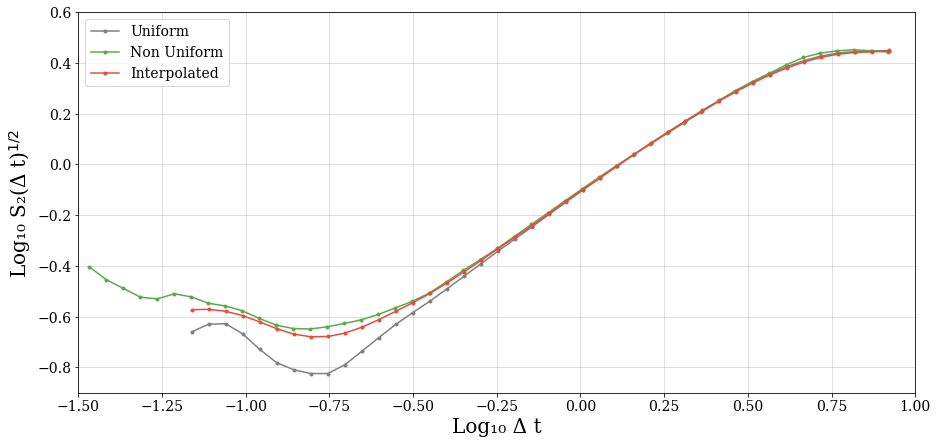

In [249]:
fig, (ax2) = plt.subplots(1,figsize=(15, 7))

ax2.plot(timeS_uniforme,np.log10(ampS_uniforme),'.-',color='grey',label='Uniform')
#ax2.plot(timeS_uniforme,np.log10(appS_uniforme),'--',color='g',linewidth=0.5)
#ax2.plot(timeS_uniforme,np.log10(lowS_uniforme),'--',color='g',linewidth=0.5)
#ax2.set(title='Log-RMS Haar Fluctuation: Resolution test 6')
ax2.set_xlabel('Log\u2081\u2080 \u0394 t\n(B)', fontsize = 20.0)
ax2.set_ylabel('Log\u2081\u2080 S\u2082(\u0394 t)'+r'$^{1/2}$', fontsize = 20)
ax2.set_xticks([-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5])

ax2.plot(timeS_nouniforme,np.log10(ampS_nouniforme),'.-',color='#5ba84b',label='Non Uniform')
#ax2.plot(timeS_nouniforme,np.log10(appS_nouniforme),'--',color='c',linewidth=0.5)
#ax2.plot(timeS_nouniforme,np.log10(lowS_nouniforme),'--',color='c',linewidth=0.5)
#ax2.set(title='Log-RMS Haar Fluctuation: Resolution test 6')
ax2.set_xlabel('Log\u2081\u2080 \u0394 t\n(B)', fontsize = 20.0)
ax2.set_ylabel('Log\u2081\u2080 S\u2082(\u0394 t)'+r'$^{1/2}$', fontsize = 20)
ax2.set_xticks([-1.5,-1.25,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5])


ax2.plot(timeS_interpol,np.log10(ampS_interpol),'.-',color='#ea4a3a',label='Interpolated')
#ax2.plot(timeS_interpol,np.log10(appS_interpol),'--',color='r',linewidth=0.5)
#ax2.plot(timeS_interpol,np.log10(lowS_interpol),'--',color='r',linewidth=0.5)
#ax2.set(title='Log-RMS Haar Fluctuation: Resolution test 6')
ax2.set_xlabel('Log\u2081\u2080 \u0394 t', fontsize = 20.0)
ax2.set_ylabel('Log\u2081\u2080 S\u2082(\u0394 t)'+r'$^{1/2}$', fontsize = 20)
ax2.set_xticks([-1.5,-1.25,-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5])

ax2.set(xlim=[-1.5,1])
ax2.set(ylim=[-0.9,0.6])
ax2.legend(loc=0)
ax2.grid(alpha=0.5)

#plt.savefig('13-SinteticA2-10-3haar2-800.pdf',bbox_inches='tight')
plt.show()